<a href="https://colab.research.google.com/github/pvilas/fotovoltaica/blob/main/Producci%C3%B3n_vs_consumo_de_una_instalaci%C3%B3n_fotovoltaica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Producción y consumo de una instalación fotovoltáica

Con este cuaderno es posible calcular, a partir de los datos que pueden descargarse en endesa o energiaxxi, el consumo horario medio de un periodo y compararlo con la generación posible para el mismo.

De la anterior comparación horaria, será posible determinar si nos es rentable la instalación de un sistema de autoconsumo.

Como usamos la base de datos de radiación de pvgis, los cálculos sólo pueden realizarse para España (Península e Illes Balears). Es importante hacer notar que pasamos esos datos a horario CET, sumando directamente una hora al GMT. 
Por lo tanto, los cálculos de radiación en horario de verano estarán retrasados una hora respecto al horario civil.

Para más explicaciones, ver el vídeo de youtube.

Si encuentra algún error, te ruego que lo comentes en issues o hagas un pull request.

## Bibliotecas

In [1]:
!pip install pvlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 27.6 MB 1.3 MB/s 


In [2]:
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import pvlib
import pytz

## Datos
Podemos hacerlo desde un fichero externo o bien asignándolo a un string, en este caso, es muy cómodo hacer copiar/pegar.

In [3]:
datos_raw="""
2022-02-16 , 1.0 , 824.0 , 0.222526297 , 0.183361668728
2022-02-16 , 2.0 , 542.0 , 0.215829757 , 0.11697972829400001
2022-02-16 , 3.0 , 464.0 , 0.213415363 , 0.099024728432
2022-02-16 , 4.0 , 826.0 , 0.20581812 , 0.17000576712
2022-02-16 , 5.0 , 453.0 , 0.203201028 , 0.09205006568400001
2022-02-16 , 6.0 , 555.0 , 0.206452115 , 0.114580923825
2022-02-16 , 7.0 , 453.0 , 0.216016917 , 0.097855663401
2022-02-16 , 8.0 , 1601.0 , 0.269291031 , 0.431134940631
2022-02-16 , 9.0 , 1246.0 , 0.3010417 , 0.3750979582
2022-02-16 , 10.0 , 187.0 , 0.296663895 , 0.055476148365
2022-02-16 , 11.0 , 112.0 , 0.317730976 , 0.035585869312
2022-02-16 , 12.0 , 115.0 , 0.303910884 , 0.03494975166
2022-02-16 , 13.0 , 104.0 , 0.308101787 , 0.032042585848
2022-02-16 , 14.0 , 431.0 , 0.296271352 , 0.12769295271199999
2022-02-16 , 15.0 , 154.0 , 0.212469161 , 0.032720250794000004
2022-02-16 , 16.0 , 1024.0 , 0.207070628 , 0.21204032307200002
2022-02-16 , 17.0 , 719.0 , 0.20698231 , 0.14882028089
2022-02-16 , 18.0 , 868.0 , 0.235943443 , 0.204798908524
2022-02-16 , 19.0 , 135.0 , 0.365488143 , 0.049340899305
2022-02-16 , 20.0 , 160.0 , 0.379839868 , 0.06077437888
2022-02-16 , 21.0 , 753.0 , 0.392081661 , 0.29523749073300004
2022-02-16 , 22.0 , 242.0 , 0.380246681 , 0.09201969680199999
2022-02-16 , 23.0 , 523.0 , 0.288251511 , 0.15075554025300003
2022-02-17 , 24.0 , 231.0 , 0.247146375 , 0.057090812625

2022-02-17 , 1.0 , 189.0 , 0.176519951 , 0.033362270739000006
2022-02-17 , 2.0 , 186.0 , 0.175758071 , 0.032691001206
2022-02-17 , 3.0 , 163.0 , 0.149065175 , 0.024297623525
2022-02-17 , 4.0 , 440.0 , 0.143598384 , 0.06318328896
2022-02-17 , 5.0 , 102.0 , 0.143588325 , 0.01464600915
2022-02-17 , 6.0 , 110.0 , 0.157442466 , 0.01731867126
2022-02-17 , 7.0 , 108.0 , 0.186520009 , 0.020144160972
2022-02-17 , 8.0 , 634.0 , 0.216479581 , 0.137248054354
2022-02-17 , 9.0 , 657.0 , 0.272640591 , 0.179124868287
2022-02-17 , 10.0 , 168.0 , 0.267610912 , 0.044958633215999994
2022-02-17 , 11.0 , 111.0 , 0.309201358 , 0.034321350738
2022-02-17 , 12.0 , 105.0 , 0.291476391 , 0.030605021055
2022-02-17 , 13.0 , 108.0 , 0.280911355 , 0.03033842634
2022-02-17 , 14.0 , 177.0 , 0.266301353 , 0.047135339481
2022-02-17 , 15.0 , 421.0 , 0.202791251 , 0.085375116671
2022-02-17 , 16.0 , 865.0 , 0.195340758 , 0.16896975567
2022-02-17 , 17.0 , 1847.0 , 0.225973785 , 0.41737358089500004
2022-02-17 , 18.0 , 730.0 , 0.232673912 , 0.16985195576
2022-02-17 , 19.0 , 108.0 , 0.363968159 , 0.039308561172
2022-02-17 , 20.0 , 442.0 , 0.395885577 , 0.174981425034
2022-02-17 , 21.0 , 122.0 , 0.42982556 , 0.05243871832
2022-02-17 , 22.0 , 1354.0 , 0.393454802 , 0.5327378019079999
2022-02-17 , 23.0 , 1217.0 , 0.287566967 , 0.349968998839
2022-02-18 , 24.0 , 461.0 , 0.27428001 , 0.12644308461

2022-02-18 , 1.0 , 127.0 , 0.262687071 , 0.033361258016999996
2022-02-18 , 2.0 , 108.0 , 0.258791755 , 0.02794950954
2022-02-18 , 3.0 , 230.0 , 0.249995913 , 0.05749905999
2022-02-18 , 4.0 , 297.0 , 0.238289529 , 0.070771990113
2022-02-18 , 5.0 , 105.0 , 0.230578694 , 0.02421076287
2022-02-18 , 6.0 , 104.0 , 0.229519802 , 0.023870059408
2022-02-18 , 7.0 , 103.0 , 0.255897517 , 0.026357444251
2022-02-18 , 8.0 , 1075.0 , 0.264959796 , 0.28483178070000004
2022-02-18 , 9.0 , 1290.0 , 0.295133882 , 0.38072270778
2022-02-18 , 10.0 , 157.0 , 0.289242424 , 0.045411060568
2022-02-18 , 11.0 , 106.0 , 0.351946268 , 0.037306304408
2022-02-18 , 12.0 , 109.0 , 0.345172052 , 0.037623753668
2022-02-18 , 13.0 , 459.0 , 0.332550129 , 0.15264050921100003
2022-02-18 , 14.0 , 132.0 , 0.32371092 , 0.04272984144
2022-02-18 , 15.0 , 995.0 , 0.230183444 , 0.22903252678
2022-02-18 , 16.0 , 1208.0 , 0.224108363 , 0.270722902504
2022-02-18 , 17.0 , 173.0 , 0.226202104 , 0.039132963992
2022-02-18 , 18.0 , 503.0 , 0.230389733 , 0.11588603569900001
2022-02-18 , 19.0 , 194.0 , 0.341706078 , 0.06629097913200001
2022-02-18 , 20.0 , 143.0 , 0.352082983 , 0.050347866569000005
2022-02-18 , 21.0 , 514.0 , 0.341369032 , 0.175463682448
2022-02-18 , 22.0 , 930.0 , 0.324772196 , 0.30203814228
2022-02-18 , 23.0 , 1356.0 , 0.224849688 , 0.304896176928
2022-02-19 , 24.0 , 156.0 , 0.217303578 , 0.033899358168

2022-02-19 , 1.0 , 156.0 , 0.177032069 , 0.027617002764
2022-02-19 , 2.0 , 86.0 , 0.160425591 , 0.013796600826
2022-02-19 , 3.0 , 391.0 , 0.146887269 , 0.05743292217899999
2022-02-19 , 4.0 , 86.0 , 0.123651511 , 0.010634029946
2022-02-19 , 5.0 , 87.0 , 0.130697735 , 0.011370702945000002
2022-02-19 , 6.0 , 82.0 , 0.147223403 , 0.012072319046
2022-02-19 , 7.0 , 83.0 , 0.163474272 , 0.013568364576
2022-02-19 , 8.0 , 383.0 , 0.187854803 , 0.071948389549
2022-02-19 , 9.0 , 84.0 , 0.187936582 , 0.015786672888
2022-02-19 , 10.0 , 236.0 , 0.217689649 , 0.051374757164
2022-02-19 , 11.0 , 1023.0 , 0.181464443 , 0.185638125189
2022-02-19 , 12.0 , 469.0 , 0.171880223 , 0.080611824587
2022-02-19 , 13.0 , 170.0 , 0.160512238 , 0.027287080459999998
2022-02-19 , 14.0 , 87.0 , 0.160032561 , 0.013922832807
2022-02-19 , 15.0 , 83.0 , 0.160793489 , 0.013345859587000002
2022-02-19 , 16.0 , 91.0 , 0.149208887 , 0.013578008717000002
2022-02-19 , 17.0 , 781.0 , 0.15163329 , 0.11842559948999999
2022-02-19 , 18.0 , 2215.0 , 0.174572419 , 0.386677908085
2022-02-19 , 19.0 , 1862.0 , 0.220323751 , 0.41024282436200005
2022-02-19 , 20.0 , 1577.0 , 0.251198756 , 0.39614043821200007
2022-02-19 , 21.0 , 821.0 , 0.258118081 , 0.211914944501
2022-02-19 , 22.0 , 661.0 , 0.258754656 , 0.171036827616
2022-02-19 , 23.0 , 372.0 , 0.253071082 , 0.094142442504
2022-02-20 , 24.0 , 424.0 , 0.245130435 , 0.10393530444000001

2022-02-20 , 1.0 , 134.0 , 0.254685102 , 0.034127803668
2022-02-20 , 2.0 , 161.0 , 0.235038489 , 0.037841196729
2022-02-20 , 3.0 , 104.0 , 0.209223753 , 0.021759270312000003
2022-02-20 , 4.0 , 413.0 , 0.200678984 , 0.082880420392
2022-02-20 , 5.0 , 95.0 , 0.201976216 , 0.01918774052
2022-02-20 , 6.0 , 151.0 , 0.207583942 , 0.031345175242
2022-02-20 , 7.0 , 102.0 , 0.222909454 , 0.022736764308
2022-02-20 , 8.0 , 93.0 , 0.23400607 , 0.021762564510000002
2022-02-20 , 9.0 , 93.0 , 0.204594962 , 0.019027331466
2022-02-20 , 10.0 , 569.0 , 0.190178791 , 0.108211732079
2022-02-20 , 11.0 , 361.0 , 0.178113509 , 0.06429897674900001
2022-02-20 , 12.0 , 2036.0 , 0.171302914 , 0.348772732904
2022-02-20 , 13.0 , 782.0 , 0.170354739 , 0.13321740589800002
2022-02-20 , 14.0 , 452.0 , 0.171294636 , 0.07742517547200001
2022-02-20 , 15.0 , 165.0 , 0.170437012 , 0.02812210698
2022-02-20 , 16.0 , 92.0 , 0.167840183 , 0.015441296836
2022-02-20 , 17.0 , 141.0 , 0.174687823 , 0.024630983043
2022-02-20 , 18.0 , 356.0 , 0.185012962 , 0.065864614472
2022-02-20 , 19.0 , 1090.0 , 0.25895084 , 0.28225641560000003
2022-02-20 , 20.0 , 1433.0 , 0.27743423 , 0.39756325159
2022-02-20 , 21.0 , 782.0 , 0.284528751 , 0.222501483282
2022-02-20 , 22.0 , 1320.0 , 0.281952948 , 0.37217789136
2022-02-20 , 23.0 , 340.0 , 0.270473632 , 0.09196103488
2022-02-21 , 24.0 , 473.0 , 0.260452171 , 0.123193876883

2022-02-21 , 1.0 , 108.0 , 0.260140909 , 0.028095218171999996
2022-02-21 , 2.0 , 130.0 , 0.225728058 , 0.02934464754
2022-02-21 , 3.0 , 118.0 , 0.221616999 , 0.026150805882
2022-02-21 , 4.0 , 392.0 , 0.208263878 , 0.08163944017600001
2022-02-21 , 5.0 , 90.0 , 0.202287027 , 0.018205832430000003
2022-02-21 , 6.0 , 93.0 , 0.217092393 , 0.020189592549
2022-02-21 , 7.0 , 99.0 , 0.263258653 , 0.026062606647000004
2022-02-21 , 8.0 , 677.0 , 0.280666432 , 0.190011174464
2022-02-21 , 9.0 , 727.0 , 0.307211578 , 0.22334281720599997
2022-02-21 , 10.0 , 538.0 , 0.300415492 , 0.16162353469600002
2022-02-21 , 11.0 , 714.0 , 0.345704802 , 0.24683322862799997
2022-02-21 , 12.0 , 1472.0 , 0.313859843 , 0.462001688896
2022-02-21 , 13.0 , 1207.0 , 0.304698118 , 0.36777062842600006
2022-02-21 , 14.0 , 741.0 , 0.287728185 , 0.21320658508500004
2022-02-21 , 15.0 , 934.0 , 0.211387343 , 0.19743577836200002
2022-02-21 , 16.0 , 557.0 , 0.193995632 , 0.108055567024
2022-02-21 , 17.0 , 112.0 , 0.214567615 , 0.024031572879999998
2022-02-21 , 18.0 , 522.0 , 0.239289321 , 0.124909025562
2022-02-21 , 19.0 , 150.0 , 0.375121201 , 0.05626818015
2022-02-21 , 20.0 , 1620.0 , 0.383264632 , 0.62088870384
2022-02-21 , 21.0 , 1059.0 , 0.392449469 , 0.415603987671
2022-02-21 , 22.0 , 556.0 , 0.381315905 , 0.21201164318
2022-02-21 , 23.0 , 658.0 , 0.297705518 , 0.195890230844
2022-02-22 , 24.0 , 739.0 , 0.266388614 , 0.196861185746

2022-02-22 , 1.0 , 177.0 , 0.229313622 , 0.040588511093999996
2022-02-22 , 2.0 , 89.0 , 0.224708615 , 0.019999066735
2022-02-22 , 3.0 , 90.0 , 0.221700556 , 0.01995305004
2022-02-22 , 4.0 , 300.0 , 0.22006265 , 0.06601879499999999
2022-02-22 , 5.0 , 162.0 , 0.214170509 , 0.034695622458
2022-02-22 , 6.0 , 82.0 , 0.221244671 , 0.018142063022000002
2022-02-22 , 7.0 , 89.0 , 0.249401133 , 0.022196700836999997
2022-02-22 , 8.0 , 541.0 , 0.257810427 , 0.139475441007
2022-02-22 , 9.0 , 1284.0 , 0.293087229 , 0.376324002036
2022-02-22 , 10.0 , 424.0 , 0.279642281 , 0.118568327144
2022-02-22 , 11.0 , 900.0 , 0.338305993 , 0.30447539370000004
2022-02-22 , 12.0 , 1574.0 , 0.318467405 , 0.5012676954699999
2022-02-22 , 13.0 , 1076.0 , 0.315581861 , 0.33956608243600006
2022-02-22 , 14.0 , 440.0 , 0.301628163 , 0.13271639172
2022-02-22 , 15.0 , 382.0 , 0.214248111 , 0.081842778402
2022-02-22 , 16.0 , 945.0 , 0.209369113 , 0.197853811785
2022-02-22 , 17.0 , 286.0 , 0.214534804 , 0.061356953943999995
2022-02-22 , 18.0 , 127.0 , 0.235200917 , 0.029870516459
2022-02-22 , 19.0 , 532.0 , 0.358431037 , 0.190685311684
2022-02-22 , 20.0 , 128.0 , 0.36809145 , 0.047115705599999995
2022-02-22 , 21.0 , 1100.0 , 0.374043968 , 0.41144836479999997
2022-02-22 , 22.0 , 935.0 , 0.362446613 , 0.33888758315499995
2022-02-22 , 23.0 , 1834.0 , 0.272454936 , 0.49968235262399996
2022-02-23 , 24.0 , 1053.0 , 0.250811455 , 0.264104462115

2022-02-23 , 1.0 , 95.0 , 0.231219163 , 0.021965820485000002
2022-02-23 , 2.0 , 91.0 , 0.228116772 , 0.020758626252
2022-02-23 , 3.0 , 84.0 , 0.224037309 , 0.018819133956
2022-02-23 , 4.0 , 84.0 , 0.220347234 , 0.018509167655999997
2022-02-23 , 5.0 , 404.0 , 0.219711726 , 0.088763537304
2022-02-23 , 6.0 , 107.0 , 0.22680939 , 0.02426860473
2022-02-23 , 7.0 , 93.0 , 0.260512845 , 0.024227694584999997
2022-02-23 , 8.0 , 322.0 , 0.267433259 , 0.08611350939799998
2022-02-23 , 9.0 , 744.0 , 0.29829611 , 0.22193230584
2022-02-23 , 10.0 , 321.0 , 0.295964752 , 0.095004685392
2022-02-23 , 11.0 , 91.0 , 0.353310976 , 0.032151298816
2022-02-23 , 12.0 , 85.0 , 0.341183871 , 0.029000629035000003
2022-02-23 , 13.0 , 83.0 , 0.328682267 , 0.027280628161
2022-02-23 , 14.0 , 89.0 , 0.320769845 , 0.028548516205
2022-02-23 , 15.0 , 684.0 , 0.238370612 , 0.163045498608
2022-02-23 , 16.0 , 1076.0 , 0.242211643 , 0.260619727868
2022-02-23 , 17.0 , 134.0 , 0.255744958 , 0.034269824372000005
2022-02-23 , 18.0 , 458.0 , 0.286720743 , 0.131318100294
2022-02-23 , 19.0 , 90.0 , 0.388231851 , 0.03494086659
2022-02-23 , 20.0 , 456.0 , 0.39400965 , 0.17966840039999998
2022-02-23 , 21.0 , 656.0 , 0.400874071 , 0.262973390576
2022-02-23 , 22.0 , 1433.0 , 0.376883529 , 0.540074097057
2022-02-23 , 23.0 , 824.0 , 0.291525354 , 0.240216891696
2022-02-24 , 24.0 , 1372.0 , 0.287170795 , 0.39399833073999996

2022-02-24 , 1.0 , 405.0 , 0.269485767 , 0.10914173563499999
2022-02-24 , 2.0 , 91.0 , 0.270560507 , 0.024621006137000002
2022-02-24 , 3.0 , 89.0 , 0.267042598 , 0.023766791222
2022-02-24 , 4.0 , 82.0 , 0.264722706 , 0.021707261891999997
2022-02-24 , 5.0 , 88.0 , 0.268689575 , 0.0236446826
2022-02-24 , 6.0 , 82.0 , 0.267078306 , 0.021900421091999998
2022-02-24 , 7.0 , 390.0 , 0.270990369 , 0.10568624391
2022-02-24 , 8.0 , 714.0 , 0.273777577 , 0.19547718997799998
2022-02-24 , 9.0 , 474.0 , 0.317511789 , 0.150500587986
2022-02-24 , 10.0 , 84.0 , 0.30015967 , 0.02521341228
2022-02-24 , 11.0 , 106.0 , 0.360942278 , 0.038259881468
2022-02-24 , 12.0 , 416.0 , 0.358926315 , 0.14931334704
2022-02-24 , 13.0 , 88.0 , 0.358629723 , 0.031559415624
2022-02-24 , 14.0 , 80.0 , 0.354608945 , 0.0283687156
2022-02-24 , 15.0 , 342.0 , 0.286295261 , 0.097912979262
2022-02-24 , 16.0 , 682.0 , 0.270489854 , 0.18447408042799998
2022-02-24 , 17.0 , 147.0 , 0.252552246 , 0.037125180162
2022-02-24 , 18.0 , 512.0 , 0.266934293 , 0.136670358016
2022-02-24 , 19.0 , 206.0 , 0.355960327 , 0.07332782736200001
2022-02-24 , 20.0 , 168.0 , 0.373216593 , 0.062700387624
2022-02-24 , 21.0 , 573.0 , 0.366358361 , 0.20992334085300002
2022-02-24 , 22.0 , 784.0 , 0.360034151 , 0.28226677438400005
2022-02-24 , 23.0 , 279.0 , 0.268938699 , 0.075033897021
2022-02-25 , 24.0 , 431.0 , 0.235733351 , 0.10160107428100001

2022-02-25 , 1.0 , 149.0 , 0.300050188 , 0.044707478012
2022-02-25 , 2.0 , 95.0 , 0.263351385 , 0.025018381574999998
2022-02-25 , 3.0 , 98.0 , 0.249818697 , 0.024482232306
2022-02-25 , 4.0 , 385.0 , 0.226418065 , 0.087170955025
2022-02-25 , 5.0 , 82.0 , 0.218471324 , 0.017914648568
2022-02-25 , 6.0 , 84.0 , 0.237665514 , 0.019963903175999997
2022-02-25 , 7.0 , 82.0 , 0.274897669 , 0.022541608858
2022-02-25 , 8.0 , 647.0 , 0.338494921 , 0.219006213887
2022-02-25 , 9.0 , 119.0 , 0.364238042 , 0.043344326998
2022-02-25 , 10.0 , 92.0 , 0.363795514 , 0.033469187288
2022-02-25 , 11.0 , 89.0 , 0.42370619 , 0.03770985091
2022-02-25 , 12.0 , 613.0 , 0.403898458 , 0.24758975475400002
2022-02-25 , 13.0 , 115.0 , 0.412468899 , 0.047433923385
2022-02-25 , 14.0 , 395.0 , 0.39771238 , 0.15709639009999998
2022-02-25 , 15.0 , 698.0 , 0.323896564 , 0.226079801672
2022-02-25 , 16.0 , 689.0 , 0.318892787 , 0.21971713024300002
2022-02-25 , 17.0 , 168.0 , 0.328781217 , 0.055235244456000004
2022-02-25 , 18.0 , 505.0 , 0.353912565 , 0.178725845325
2022-02-25 , 19.0 , 223.0 , 0.448186886 , 0.099945675578
2022-02-25 , 20.0 , 149.0 , 0.473250346 , 0.070514301554
2022-02-25 , 21.0 , 1071.0 , 0.461807032 , 0.494595331272
2022-02-25 , 22.0 , 682.0 , 0.445280089 , 0.303681020698
2022-02-25 , 23.0 , 540.0 , 0.364132881 , 0.19663175574000002
2022-02-26 , 24.0 , 1358.0 , 0.360611567 , 0.489710507986

2022-02-26 , 1.0 , 1228.0 , 0.363995849 , 0.44698690257199997
2022-02-26 , 2.0 , 153.0 , 0.346088158 , 0.052951488174
2022-02-26 , 3.0 , 155.0 , 0.342656249 , 0.05311171859500001
2022-02-26 , 4.0 , 205.0 , 0.328894393 , 0.06742335056500001
2022-02-26 , 5.0 , 148.0 , 0.320374839 , 0.047415476172
2022-02-26 , 6.0 , 293.0 , 0.319227983 , 0.093533799019
2022-02-26 , 7.0 , 194.0 , 0.329685885 , 0.06395906169
2022-02-26 , 8.0 , 81.0 , 0.343139663 , 0.027794312703
2022-02-26 , 9.0 , 173.0 , 0.351433337 , 0.060797967301
2022-02-26 , 10.0 , 1449.0 , 0.336242893 , 0.48721595195699996
2022-02-26 , 11.0 , 1354.0 , 0.307697342 , 0.41662220106799996
2022-02-26 , 12.0 , 221.0 , 0.304991243 , 0.067403064703
2022-02-26 , 13.0 , 89.0 , 0.302892903 , 0.026957468367
2022-02-26 , 14.0 , 88.0 , 0.298748636 , 0.026289879968
2022-02-26 , 15.0 , 315.0 , 0.298582283 , 0.09405341914500001
2022-02-26 , 16.0 , 2296.0 , 0.300619111 , 0.6902214788559999
2022-02-26 , 17.0 , 586.0 , 0.302931993 , 0.177518147898
2022-02-26 , 18.0 , 237.0 , 0.327855283 , 0.077701702071
2022-02-26 , 19.0 , 224.0 , 0.378694777 , 0.08482763004800001
2022-02-26 , 20.0 , 314.0 , 0.379036826 , 0.119017563364
2022-02-26 , 21.0 , 868.0 , 0.373245951 , 0.323977485468
2022-02-26 , 22.0 , 679.0 , 0.376169109 , 0.255418825011
2022-02-26 , 23.0 , 637.0 , 0.337122286 , 0.214746896182
2022-02-27 , 24.0 , 442.0 , 0.33171297 , 0.14661713274

2022-02-27 , 1.0 , 648.0 , 0.330953838 , 0.21445808702400002
2022-02-27 , 2.0 , 171.0 , 0.328270891 , 0.056134322361
2022-02-27 , 3.0 , 138.0 , 0.303805929 , 0.04192521820199999
2022-02-27 , 4.0 , 90.0 , 0.301095944 , 0.027098634960000003
2022-02-27 , 5.0 , 317.0 , 0.30862214 , 0.09783321837999999
2022-02-27 , 6.0 , 151.0 , 0.3159064 , 0.047701866399999994
2022-02-27 , 7.0 , 90.0 , 0.336768518 , 0.03030916662
2022-02-27 , 8.0 , 83.0 , 0.336924424 , 0.027964727192
2022-02-27 , 9.0 , 130.0 , 0.331016972 , 0.043032206360000005
2022-02-27 , 10.0 , 135.0 , 0.327290246 , 0.04418418321
2022-02-27 , 11.0 , 389.0 , 0.321287298 , 0.12498075892199999
2022-02-27 , 12.0 , 78.0 , 0.31401706 , 0.02449333068
2022-02-27 , 13.0 , 79.0 , 0.301218703 , 0.023796277536999998
2022-02-27 , 14.0 , 88.0 , 0.314439424 , 0.027670669312
2022-02-27 , 15.0 , 85.0 , 0.31451551 , 0.02673381835
2022-02-27 , 16.0 , 1284.0 , 0.271985937 , 0.349229943108
2022-02-27 , 17.0 , 1730.0 , 0.275048426 , 0.47583377698
2022-02-27 , 18.0 , 1465.0 , 0.302261472 , 0.44281305647999997
2022-02-27 , 19.0 , 1445.0 , 0.354435208 , 0.51215887556
2022-02-27 , 20.0 , 1651.0 , 0.37961816 , 0.62674958216
2022-02-27 , 21.0 , 2169.0 , 0.437579231 , 0.9491093520389999
2022-02-27 , 22.0 , 827.0 , 0.437109963 , 0.361489939401
2022-02-27 , 23.0 , 221.0 , 0.386414946 , 0.08539770306599999
2022-02-28 , 24.0 , 168.0 , 0.352608191 , 0.059238176088

2022-02-28 , 1.0 , 436.0 , 0.374511029 , 0.163286808644
2022-02-28 , 2.0 , 91.0 , 0.370199762 , 0.033688178342000004
2022-02-28 , 3.0 , 86.0 , 0.36932382 , 0.031761848520000004
2022-02-28 , 4.0 , 77.0 , 0.370908365 , 0.028559944105
2022-02-28 , 5.0 , 396.0 , 0.366085445 , 0.14496983621999998
2022-02-28 , 6.0 , 89.0 , 0.367941897 , 0.032746828833
2022-02-28 , 7.0 , 74.0 , 0.365322181 , 0.027033841394000002
2022-02-28 , 8.0 , 129.0 , 0.401678032 , 0.051816466128000005
2022-02-28 , 9.0 , 148.0 , 0.40848111 , 0.060455204279999994
2022-02-28 , 10.0 , 383.0 , 0.38055707 , 0.14575335781
2022-02-28 , 11.0 , 86.0 , 0.418962822 , 0.036030802692
2022-02-28 , 12.0 , 77.0 , 0.374665273 , 0.028849226021000002
2022-02-28 , 13.0 , 95.0 , 0.379006803 , 0.036005646285
2022-02-28 , 14.0 , 88.0 , 0.375948105 , 0.03308343324
2022-02-28 , 15.0 , 634.0 , 0.303019529 , 0.192114381386
2022-02-28 , 16.0 , 448.0 , 0.303419302 , 0.135931847296
2022-02-28 , 17.0 , 1553.0 , 0.347201776 , 0.539204358128
2022-02-28 , 18.0 , 300.0 , 0.379333581 , 0.1138000743
2022-02-28 , 19.0 , 426.0 , 0.475038389 , 0.20236635371400002
2022-02-28 , 20.0 , 118.0 , 0.496979032 , 0.058643525775999995
2022-02-28 , 21.0 , 583.0 , 0.527628565 , 0.307607453395
2022-02-28 , 22.0 , 1371.0 , 0.501971973 , 0.688203574983
2022-02-28 , 23.0 , 1328.0 , 0.388227962 , 0.515566733536
2022-03-01 , 24.0 , 770.0 , 0.377110316 , 0.29037494332

2022-03-01 , 1.0 , 133.0 , 0.341146076 , 0.045372428108000004
2022-03-01 , 2.0 , 230.0 , 0.332833389 , 0.07655167947
2022-03-01 , 3.0 , 404.0 , 0.313742972 , 0.126752160688
2022-03-01 , 4.0 , 97.0 , 0.29406302 , 0.028524112940000002
2022-03-01 , 5.0 , 94.0 , 0.29016687 , 0.027275685780000003
2022-03-01 , 6.0 , 81.0 , 0.298850452 , 0.024206886612
2022-03-01 , 7.0 , 394.0 , 0.338482871 , 0.133362251174
2022-03-01 , 8.0 , 98.0 , 0.369827569 , 0.036243101762000005
2022-03-01 , 9.0 , 85.0 , 0.399193274 , 0.03393142829
2022-03-01 , 10.0 , 116.0 , 0.386214641 , 0.044800898356000006
2022-03-01 , 11.0 , 461.0 , 0.419506761 , 0.19339261682099998
2022-03-01 , 12.0 , 993.0 , 0.377433847 , 0.374791810071
2022-03-01 , 13.0 , 461.0 , 0.372197637 , 0.17158311065700002
2022-03-01 , 14.0 , 191.0 , 0.366811242 , 0.070060947222
2022-03-01 , 15.0 , 128.0 , 0.299667023 , 0.038357378943999994
2022-03-01 , 16.0 , 330.0 , 0.299922034 , 0.09897427122
2022-03-01 , 17.0 , 81.0 , 0.305125116 , 0.024715134395999996
2022-03-01 , 18.0 , 143.0 , 0.348682568 , 0.049861607224
2022-03-01 , 19.0 , 436.0 , 0.44714931 , 0.19495709916
2022-03-01 , 20.0 , 711.0 , 0.484587715 , 0.344541865365
2022-03-01 , 21.0 , 771.0 , 0.485144475 , 0.374046390225
2022-03-01 , 22.0 , 1145.0 , 0.460544352 , 0.52732328304
2022-03-01 , 23.0 , 675.0 , 0.360811684 , 0.24354788670000002
2022-03-02 , 24.0 , 531.0 , 0.355894521 , 0.18897999065100002

2022-03-02 , 1.0 , 145.0 , 0.318922106 , 0.04624370537
2022-03-02 , 2.0 , 100.0 , 0.318916654 , 0.0318916654
2022-03-02 , 3.0 , 98.0 , 0.319719192 , 0.031332480816
2022-03-02 , 4.0 , 425.0 , 0.305826925 , 0.129976443125
2022-03-02 , 5.0 , 90.0 , 0.306310405 , 0.02756793645
2022-03-02 , 6.0 , 92.0 , 0.321201648 , 0.029550551616
2022-03-02 , 7.0 , 94.0 , 0.335650695 , 0.03155116533
2022-03-02 , 8.0 , 784.0 , 0.364598543 , 0.285845257712
2022-03-02 , 9.0 , 1907.0 , 0.407073625 , 0.7762894028749999
2022-03-02 , 10.0 , 783.0 , 0.384587742 , 0.301132201986
2022-03-02 , 11.0 , 101.0 , 0.422167478 , 0.042638915278
2022-03-02 , 12.0 , 97.0 , 0.40770574 , 0.03954745678
2022-03-02 , 13.0 , 94.0 , 0.396556977 , 0.037276355838
2022-03-02 , 14.0 , 93.0 , 0.372272494 , 0.034621341942
2022-03-02 , 15.0 , 603.0 , 0.284389814 , 0.17148705784200002
2022-03-02 , 16.0 , 252.0 , 0.281274541 , 0.070881184332
2022-03-02 , 17.0 , 497.0 , 0.286666788 , 0.142473393636
2022-03-02 , 18.0 , 540.0 , 0.309614045 , 0.1671915843
2022-03-02 , 19.0 , 108.0 , 0.417842874 , 0.045127030391999993
2022-03-02 , 20.0 , 413.0 , 0.44734105 , 0.18475185365000002
2022-03-02 , 21.0 , 373.0 , 0.461538877 , 0.172154001121
2022-03-02 , 22.0 , 1485.0 , 0.442557234 , 0.65719749249
2022-03-02 , 23.0 , 1074.0 , 0.357437026 , 0.38388736592399997
2022-03-03 , 24.0 , 1197.0 , 0.343175533 , 0.410781113001

2022-03-03 , 1.0 , 98.0 , 0.417854463 , 0.040949737374000005
2022-03-03 , 2.0 , 115.0 , 0.413350357 , 0.047535291055000005
2022-03-03 , 3.0 , 109.0 , 0.413076979 , 0.045025390711
2022-03-03 , 4.0 , 408.0 , 0.404392786 , 0.164992256688
2022-03-03 , 5.0 , 103.0 , 0.404778692 , 0.041692205276000004
2022-03-03 , 6.0 , 145.0 , 0.427281997 , 0.061955889565000005
2022-03-03 , 7.0 , 110.0 , 0.462654766 , 0.05089202426
2022-03-03 , 8.0 , 862.0 , 0.487091761 , 0.419873097982
2022-03-03 , 9.0 , 753.0 , 0.519324142 , 0.391051078926
2022-03-03 , 10.0 , 91.0 , 0.468738764 , 0.042655227524
2022-03-03 , 11.0 , 97.0 , 0.530682729 , 0.051476224713
2022-03-03 , 12.0 , 100.0 , 0.529183422 , 0.052918342199999996
2022-03-03 , 13.0 , 403.0 , 0.524975637 , 0.211565181711
2022-03-03 , 14.0 , 98.0 , 0.518347718 , 0.050798076364
2022-03-03 , 15.0 , 113.0 , 0.422099264 , 0.047697216832
2022-03-03 , 16.0 , 804.0 , 0.418586492 , 0.336543539568
2022-03-03 , 17.0 , 188.0 , 0.440803311 , 0.08287102246799999
2022-03-03 , 18.0 , 198.0 , 0.452781194 , 0.089650676412
2022-03-03 , 19.0 , 233.0 , 0.532022888 , 0.123961332904
2022-03-03 , 20.0 , 491.0 , 0.540169808 , 0.26522337572800003
2022-03-03 , 21.0 , 1242.0 , 0.541368402 , 0.6723795552840001
2022-03-03 , 22.0 , 1018.0 , 0.530512433 , 0.540061656794
2022-03-03 , 23.0 , 380.0 , 0.438335806 , 0.16656760628
2022-03-04 , 24.0 , 438.0 , 0.361079053 , 0.15815262521399998

2022-03-04 , 1.0 , 649.0 , 0.446376948 , 0.289698639252
2022-03-04 , 2.0 , 366.0 , 0.360020039 , 0.131767334274
2022-03-04 , 3.0 , 420.0 , 0.360534692 , 0.15142457063999998
2022-03-04 , 4.0 , 354.0 , 0.35810238 , 0.12676824252
2022-03-04 , 5.0 , 776.0 , 0.356113932 , 0.27634441123200004
2022-03-04 , 6.0 , 307.0 , 0.357671454 , 0.109805136378
2022-03-04 , 7.0 , 373.0 , 0.355118343 , 0.13245914193900002
2022-03-04 , 8.0 , 532.0 , 0.463766614 , 0.246723838648
2022-03-04 , 9.0 , 540.0 , 0.499459594 , 0.26970818076
2022-03-04 , 10.0 , 887.0 , 0.484333224 , 0.429603569688
2022-03-04 , 11.0 , 588.0 , 0.547726173 , 0.32206298972400005
2022-03-04 , 12.0 , 100.0 , 0.501022649 , 0.0501022649
2022-03-04 , 13.0 , 86.0 , 0.516933711 , 0.044456299146
2022-03-04 , 14.0 , 80.0 , 0.478416876 , 0.03827335008
2022-03-04 , 15.0 , 160.0 , 0.419012568 , 0.06704201087999999
2022-03-04 , 16.0 , 1130.0 , 0.439815595 , 0.49699162235
2022-03-04 , 17.0 , 145.0 , 0.468689344 , 0.06795995487999999
2022-03-04 , 18.0 , 523.0 , 0.500956443 , 0.262000219689
2022-03-04 , 19.0 , 184.0 , 0.585828923 , 0.107792521832
2022-03-04 , 20.0 , 719.0 , 0.606355496 , 0.43596960162400006
2022-03-04 , 21.0 , 362.0 , 0.592052512 , 0.21432300934399998
2022-03-04 , 22.0 , 1320.0 , 0.582014632 , 0.76825931424
2022-03-04 , 23.0 , 1801.0 , 0.50781958 , 0.9145830635800001
2022-03-05 , 24.0 , 596.0 , 0.494438391 , 0.294685281036

2022-03-05 , 1.0 , 180.0 , 0.479402872 , 0.08629251696
2022-03-05 , 2.0 , 115.0 , 0.46951389 , 0.05399409735
2022-03-05 , 3.0 , 404.0 , 0.466039522 , 0.188279966888
2022-03-05 , 4.0 , 89.0 , 0.445713946 , 0.039668541194
2022-03-05 , 5.0 , 88.0 , 0.456325508 , 0.040156644704
2022-03-05 , 6.0 , 80.0 , 0.464854913 , 0.03718839304
2022-03-05 , 7.0 , 106.0 , 0.484502378 , 0.051357252068
2022-03-05 , 8.0 , 399.0 , 0.487844854 , 0.194650096746
2022-03-05 , 9.0 , 187.0 , 0.470361461 , 0.087957593207
2022-03-05 , 10.0 , 1734.0 , 0.455323914 , 0.7895316668760001
2022-03-05 , 11.0 , 783.0 , 0.446107078 , 0.349301842074
2022-03-05 , 12.0 , 414.0 , 0.442949018 , 0.183380893452
2022-03-05 , 13.0 , 89.0 , 0.441174711 , 0.039264549279
2022-03-05 , 14.0 , 89.0 , 0.447504091 , 0.039827864099
2022-03-05 , 15.0 , 82.0 , 0.445483563 , 0.03652965216600001
2022-03-05 , 16.0 , 85.0 , 0.38794653 , 0.03297545505
2022-03-05 , 17.0 , 448.0 , 0.429927378 , 0.19260746534400003
2022-03-05 , 18.0 , 340.0 , 0.479880628 , 0.16315941352
2022-03-05 , 19.0 , 1299.0 , 0.507317802 , 0.659005824798
2022-03-05 , 20.0 , 1391.0 , 0.510986031 , 0.710781569121
2022-03-05 , 21.0 , 1394.0 , 0.49825968 , 0.69457399392
2022-03-05 , 22.0 , 2266.0 , 0.487492328 , 1.1046576152479999
2022-03-05 , 23.0 , 1169.0 , 0.478355632 , 0.559197733808
2022-03-06 , 24.0 , 1737.0 , 0.458837955 , 0.797001527835

2022-03-06 , 1.0 , 1254.0 , 0.50103342 , 0.62829590868
2022-03-06 , 2.0 , 118.0 , 0.469115829 , 0.055355667822
2022-03-06 , 3.0 , 105.0 , 0.465463735 , 0.048873692175000004
2022-03-06 , 4.0 , 101.0 , 0.455814598 , 0.046037274398000004
2022-03-06 , 5.0 , 406.0 , 0.463233108 , 0.188072641848
2022-03-06 , 6.0 , 101.0 , 0.466938294 , 0.047160767694
2022-03-06 , 7.0 , 95.0 , 0.474263879 , 0.045055068505000004
2022-03-06 , 8.0 , 93.0 , 0.494021097 , 0.045943962021000005
2022-03-06 , 9.0 , 94.0 , 0.467417006 , 0.043937198563999996
2022-03-06 , 10.0 , 546.0 , 0.496398058 , 0.271033339668
2022-03-06 , 11.0 , 279.0 , 0.440014888 , 0.122764153752
2022-03-06 , 12.0 , 373.0 , 0.433837494 , 0.16182138526200002
2022-03-06 , 13.0 , 703.0 , 0.438408039 , 0.30820085141700004
2022-03-06 , 14.0 , 464.0 , 0.423033849 , 0.196287705936
2022-03-06 , 15.0 , 403.0 , 0.437652159 , 0.176373820077
2022-03-06 , 16.0 , 850.0 , 0.429552322 , 0.36511947370000003
2022-03-06 , 17.0 , 192.0 , 0.431995691 , 0.082943172672
2022-03-06 , 18.0 , 1519.0 , 0.486080911 , 0.738356903809
2022-03-06 , 19.0 , 1976.0 , 0.547066575 , 1.0810035522
2022-03-06 , 20.0 , 864.0 , 0.568179971 , 0.49090749494399993
2022-03-06 , 21.0 , 811.0 , 0.585362703 , 0.474729152133
2022-03-06 , 22.0 , 1460.0 , 0.585851527 , 0.85534322942
2022-03-06 , 23.0 , 1637.0 , 0.568671999 , 0.930916062363
2022-03-07 , 24.0 , 1011.0 , 0.565098325 , 0.571314406575

2022-03-07 , 1.0 , 688.0 , 0.566412782 , 0.389691994016
2022-03-07 , 2.0 , 89.0 , 0.553535169 , 0.049264630041
2022-03-07 , 3.0 , 419.0 , 0.548152108 , 0.22967573325200002
2022-03-07 , 4.0 , 85.0 , 0.531616978 , 0.04518744313
2022-03-07 , 5.0 , 84.0 , 0.526917311 , 0.044261054124000006
2022-03-07 , 6.0 , 87.0 , 0.552495964 , 0.048067148868
2022-03-07 , 7.0 , 85.0 , 0.588567505 , 0.050028237924999996
2022-03-07 , 8.0 , 1099.0 , 0.616650908 , 0.677699347892
2022-03-07 , 9.0 , 1341.0 , 0.644093044 , 0.863728772004
2022-03-07 , 10.0 , 1274.0 , 0.612198444 , 0.779940817656
2022-03-07 , 11.0 , 493.0 , 0.640089092 , 0.315563922356
2022-03-07 , 12.0 , 153.0 , 0.638738703 , 0.09772702155900001
2022-03-07 , 13.0 , 88.0 , 0.638882349 , 0.056221646711999994
2022-03-07 , 14.0 , 110.0 , 0.634583637 , 0.06980420006999999
2022-03-07 , 15.0 , 116.0 , 0.540723529 , 0.062723929364
2022-03-07 , 16.0 , 666.0 , 0.492986129 , 0.32832876191399996
2022-03-07 , 17.0 , 478.0 , 0.514137533 , 0.24575774077399998
2022-03-07 , 18.0 , 192.0 , 0.577713935 , 0.11092107552
2022-03-07 , 19.0 , 98.0 , 0.674916224 , 0.066141789952
2022-03-07 , 20.0 , 412.0 , 0.710776014 , 0.292839717768
2022-03-07 , 21.0 , 2232.0 , 0.678161304 , 1.513656030528
2022-03-07 , 22.0 , 1664.0 , 0.649172908 , 1.080223718912
2022-03-07 , 23.0 , 1628.0 , 0.553790648 , 0.901571174944
2022-03-08 , 24.0 , 1089.0 , 0.503562448 , 0.5483795058720001

2022-03-08 , 1.0 , 108.0 , 0.568159843 , 0.061361263044
2022-03-08 , 2.0 , 103.0 , 0.576324649 , 0.059361438847
2022-03-08 , 3.0 , 95.0 , 0.588291844 , 0.05588772518000001
2022-03-08 , 4.0 , 401.0 , 0.561626316 , 0.225212152716
2022-03-08 , 5.0 , 84.0 , 0.567048314 , 0.047632058376
2022-03-08 , 6.0 , 84.0 , 0.579879953 , 0.048709916051999994
2022-03-08 , 7.0 , 86.0 , 0.696851076 , 0.059929192535999994
2022-03-08 , 8.0 , 347.0 , 0.744249073 , 0.258254428331
2022-03-08 , 9.0 , 1450.0 , 0.81667049 , 1.1841722105
2022-03-08 , 10.0 , 846.0 , 0.755511327 , 0.639162582642
2022-03-08 , 11.0 , 612.0 , 0.799076685 , 0.48903493121999997
2022-03-08 , 12.0 , 1161.0 , 0.755513787 , 0.877151506707
2022-03-08 , 13.0 , 1665.0 , 0.716219352 , 1.19250522108
2022-03-08 , 14.0 , 841.0 , 0.650360592 , 0.546953257872
2022-03-08 , 15.0 , 607.0 , 0.571609883 , 0.34696719898100004
2022-03-08 , 16.0 , 1105.0 , 0.573912628 , 0.6341734539399999
2022-03-08 , 17.0 , 539.0 , 0.652845717 , 0.351883841463
2022-03-08 , 18.0 , 172.0 , 0.768358229 , 0.13215761538799997
2022-03-08 , 19.0 , 1233.0 , 0.895368642 , 1.103989535586
2022-03-08 , 20.0 , 834.0 , 0.954014166 , 0.795647814444
2022-03-08 , 21.0 , 749.0 , 0.895255085 , 0.6705460586649999
2022-03-08 , 22.0 , 2717.0 , 0.891418152 , 2.4219831189839995
2022-03-08 , 23.0 , 933.0 , 0.822732979 , 0.767609869407
2022-03-09 , 24.0 , 325.0 , 0.766607657 , 0.249147488525

2022-03-09 , 1.0 , 138.0 , 0.641164411 , 0.088480688718
2022-03-09 , 2.0 , 408.0 , 0.577894254 , 0.23578085563200002
2022-03-09 , 3.0 , 96.0 , 0.565804057 , 0.054317189472
2022-03-09 , 4.0 , 144.0 , 0.555373597 , 0.079973797968
2022-03-09 , 5.0 , 118.0 , 0.555236509 , 0.065517908062
2022-03-09 , 6.0 , 223.0 , 0.567047818 , 0.12645166341400002
2022-03-09 , 7.0 , 298.0 , 0.658322695 , 0.19618016311
2022-03-09 , 8.0 , 381.0 , 0.714119357 , 0.27207947501699997
2022-03-09 , 9.0 , 615.0 , 0.710068265 , 0.43669198297499995
2022-03-09 , 10.0 , 631.0 , 0.636583067 , 0.401683915277
2022-03-09 , 11.0 , 399.0 , 0.626480598 , 0.249965758602
2022-03-09 , 12.0 , 409.0 , 0.576561826 , 0.235813786834
2022-03-09 , 13.0 , 89.0 , 0.533225098 , 0.047457033722
2022-03-09 , 14.0 , 90.0 , 0.528843446 , 0.04759591014
2022-03-09 , 15.0 , 94.0 , 0.475477621 , 0.044694896374
2022-03-09 , 16.0 , 839.0 , 0.508583968 , 0.42670194915200005
2022-03-09 , 17.0 , 150.0 , 0.548264556 , 0.0822396834
2022-03-09 , 18.0 , 494.0 , 0.660094196 , 0.32608653282399996
2022-03-09 , 19.0 , 471.0 , 0.766828058 , 0.361176015318
2022-03-09 , 20.0 , 333.0 , 0.827927194 , 0.27569975560200005
2022-03-09 , 21.0 , 1411.0 , 0.778687207 , 1.098727649077
2022-03-09 , 22.0 , 1710.0 , 0.769339944 , 1.3155713042400001
2022-03-09 , 23.0 , 1499.0 , 0.671527075 , 1.006619085425
2022-03-10 , 24.0 , 482.0 , 0.618990163 , 0.298353258566

2022-03-10 , 1.0 , 468.0 , 0.485672667 , 0.22729480815599998
2022-03-10 , 2.0 , 103.0 , 0.423922597 , 0.043664027491
2022-03-10 , 3.0 , 101.0 , 0.436544304 , 0.044090974703999995
2022-03-10 , 4.0 , 383.0 , 0.436620853 , 0.16722578669899998
2022-03-10 , 5.0 , 87.0 , 0.436608563 , 0.037984944980999996
2022-03-10 , 6.0 , 86.0 , 0.443957773 , 0.038180368478
2022-03-10 , 7.0 , 86.0 , 0.525454976 , 0.045189127935999995
2022-03-10 , 8.0 , 514.0 , 0.539986761 , 0.27755319515399995
2022-03-10 , 9.0 , 102.0 , 0.582282202 , 0.059392784604
2022-03-10 , 10.0 , 88.0 , 0.539459757 , 0.047472458616
2022-03-10 , 11.0 , 88.0 , 0.582242109 , 0.051237305592
2022-03-10 , 12.0 , 89.0 , 0.530544142 , 0.047218428638
2022-03-10 , 13.0 , 130.0 , 0.533649765 , 0.06937446945
2022-03-10 , 14.0 , 364.0 , 0.514979078 , 0.187452384392
2022-03-10 , 15.0 , 417.0 , 0.421013022 , 0.175562430174
2022-03-10 , 16.0 , 814.0 , 0.42176462 , 0.34331640067999997
2022-03-10 , 17.0 , 112.0 , 0.424591836 , 0.047554285632
2022-03-10 , 18.0 , 513.0 , 0.503843684 , 0.258471809892
2022-03-10 , 19.0 , 172.0 , 0.612454691 , 0.105342206852
2022-03-10 , 20.0 , 396.0 , 0.642774563 , 0.254538726948
2022-03-10 , 21.0 , 224.0 , 0.627869058 , 0.140642668992
2022-03-10 , 22.0 , 1003.0 , 0.604219843 , 0.606032502529
2022-03-10 , 23.0 , 2701.0 , 0.438045934 , 1.1831620677340002
2022-03-11 , 24.0 , 2137.0 , 0.434964345 , 0.929518805265

2022-03-11 , 1.0 , 559.0 , 0.354444588 , 0.19813452469200002
2022-03-11 , 2.0 , 121.0 , 0.334513233 , 0.040476101193000005
2022-03-11 , 3.0 , 93.0 , 0.321780635 , 0.029925599054999998
2022-03-11 , 4.0 , 92.0 , 0.281518796 , 0.025899729232000002
2022-03-11 , 5.0 , 92.0 , 0.223482972 , 0.020560433423999998
2022-03-11 , 6.0 , 91.0 , 0.244176429 , 0.022220055039
2022-03-11 , 7.0 , 390.0 , 0.354346503 , 0.13819513616999998
2022-03-11 , 8.0 , 336.0 , 0.384497683 , 0.129191221488
2022-03-11 , 9.0 , 604.0 , 0.414803902 , 0.250541556808
2022-03-11 , 10.0 , 626.0 , 0.40594476 , 0.25412141976
2022-03-11 , 11.0 , 100.0 , 0.462671712 , 0.0462671712
2022-03-11 , 12.0 , 403.0 , 0.432590109 , 0.17433381392699998
2022-03-11 , 13.0 , 91.0 , 0.437731755 , 0.039833589705
2022-03-11 , 14.0 , 88.0 , 0.429747141 , 0.037817748408
2022-03-11 , 15.0 , 809.0 , 0.365826036 , 0.295953263124
2022-03-11 , 16.0 , 862.0 , 0.365481495 , 0.31504504869
2022-03-11 , 17.0 , 184.0 , 0.369978844 , 0.06807610729599999
2022-03-11 , 18.0 , 132.0 , 0.401069033 , 0.052941112356000006
2022-03-11 , 19.0 , 434.0 , 0.485287208 , 0.21061464827200002
2022-03-11 , 20.0 , 189.0 , 0.530123454 , 0.10019333280600001
2022-03-11 , 21.0 , 86.0 , 0.585854446 , 0.050383482356
2022-03-11 , 22.0 , 228.0 , 0.593088232 , 0.135224116896
2022-03-11 , 23.0 , 970.0 , 0.453332144 , 0.43973217968
2022-03-12 , 24.0 , 102.0 , 0.437232739 , 0.044597739378

2022-03-12 , 1.0 , 109.0 , 0.370601624 , 0.040395577016
2022-03-12 , 2.0 , 88.0 , 0.365897421 , 0.032198973048
2022-03-12 , 3.0 , 389.0 , 0.361132447 , 0.14048052188300003
2022-03-12 , 4.0 , 107.0 , 0.326976506 , 0.034986486142
2022-03-12 , 5.0 , 144.0 , 0.320344174 , 0.046129561056
2022-03-12 , 6.0 , 83.0 , 0.334892486 , 0.027796076338
2022-03-12 , 7.0 , 85.0 , 0.331858378 , 0.028207962130000003
2022-03-12 , 8.0 , 404.0 , 0.349824104 , 0.14132893801600002
2022-03-12 , 9.0 , 85.0 , 0.331648193 , 0.028190096405
2022-03-12 , 10.0 , 79.0 , 0.304256559 , 0.024036268160999998
2022-03-12 , 11.0 , 250.0 , 0.267409016 , 0.066852254
2022-03-12 , 12.0 , 1192.0 , 0.259328374 , 0.30911942180799995
2022-03-12 , 13.0 , 157.0 , 0.253139461 , 0.039742895377
2022-03-12 , 14.0 , 175.0 , 0.253064251 , 0.044286243925
2022-03-12 , 15.0 , 2140.0 , 0.248691595 , 0.5322000133
2022-03-12 , 16.0 , 1644.0 , 0.252129618 , 0.414501091992
2022-03-12 , 17.0 , 785.0 , 0.264920583 , 0.207962657655
2022-03-12 , 18.0 , 240.0 , 0.280619629 , 0.06734871095999999
2022-03-12 , 19.0 , 511.0 , 0.359574375 , 0.183742505625
2022-03-12 , 20.0 , 309.0 , 0.366050191 , 0.113109509019
2022-03-12 , 21.0 , 801.0 , 0.367551247 , 0.294408548847
2022-03-12 , 22.0 , 759.0 , 0.356077668 , 0.270262950012
2022-03-12 , 23.0 , 255.0 , 0.342482032 , 0.08733291816
2022-03-13 , 24.0 , 156.0 , 0.334917459 , 0.052247123603999995

2022-03-13 , 1.0 , 391.0 , 0.28826151 , 0.11271025041
2022-03-13 , 2.0 , 100.0 , 0.290987354 , 0.0290987354
2022-03-13 , 3.0 , 89.0 , 0.287204115 , 0.025561166235
2022-03-13 , 4.0 , 83.0 , 0.26910015 , 0.02233531245
2022-03-13 , 5.0 , 129.0 , 0.252926558 , 0.032627525982
2022-03-13 , 6.0 , 373.0 , 0.284579964 , 0.106148326572
2022-03-13 , 7.0 , 83.0 , 0.296225774 , 0.024586739242
2022-03-13 , 8.0 , 89.0 , 0.297876681 , 0.026511024608999997
2022-03-13 , 9.0 , 77.0 , 0.289497966 , 0.022291343382
2022-03-13 , 10.0 , 144.0 , 0.320764128 , 0.046190034431999996
2022-03-13 , 11.0 , 873.0 , 0.282548482 , 0.246664824786
2022-03-13 , 12.0 , 168.0 , 0.276406689 , 0.046436323752
2022-03-13 , 13.0 , 131.0 , 0.276574959 , 0.036231319628999996
2022-03-13 , 14.0 , 85.0 , 0.318308289 , 0.027056204565000002
2022-03-13 , 15.0 , 759.0 , 0.288840486 , 0.219229928874
2022-03-13 , 16.0 , 263.0 , 0.290596314 , 0.076426830582
2022-03-13 , 17.0 , 637.0 , 0.295128176 , 0.187996648112
2022-03-13 , 18.0 , 752.0 , 0.332501251 , 0.250040940752
2022-03-13 , 19.0 , 1364.0 , 0.364959367 , 0.497804576588
2022-03-13 , 20.0 , 1364.0 , 0.452377061 , 0.617042311204
2022-03-13 , 21.0 , 647.0 , 0.481952347 , 0.31182316850900005
2022-03-13 , 22.0 , 905.0 , 0.436444759 , 0.39498250689500003
2022-03-13 , 23.0 , 1131.0 , 0.402574443 , 0.45531169503299995
2022-03-14 , 24.0 , 584.0 , 0.38385401 , 0.22417074184

2022-03-14 , 1.0 , 304.0 , 0.369877998 , 0.112442911392
2022-03-14 , 2.0 , 97.0 , 0.360391872 , 0.034958011584
2022-03-14 , 3.0 , 86.0 , 0.30703112 , 0.02640467632
2022-03-14 , 4.0 , 87.0 , 0.299770876 , 0.026080066212000003
2022-03-14 , 5.0 , 390.0 , 0.294164038 , 0.11472397482
2022-03-14 , 6.0 , 126.0 , 0.304932956 , 0.038421552456
2022-03-14 , 7.0 , 105.0 , 0.354408545 , 0.037212897225
2022-03-14 , 8.0 , 320.0 , 0.360132208 , 0.11524230656000001
2022-03-14 , 9.0 , 1273.0 , 0.392595754 , 0.49977439484200004
2022-03-14 , 10.0 , 1272.0 , 0.384783522 , 0.489444639984
2022-03-14 , 11.0 , 1276.0 , 0.447302562 , 0.570758069112
2022-03-14 , 12.0 , 1283.0 , 0.438217732 , 0.5622333501560001
2022-03-14 , 13.0 , 1262.0 , 0.411943089 , 0.519872178318
2022-03-14 , 14.0 , 167.0 , 0.368921295 , 0.061609856265
2022-03-14 , 15.0 , 876.0 , 0.294203461 , 0.257722231836
2022-03-14 , 16.0 , 707.0 , 0.295330697 , 0.20879880277899998
2022-03-14 , 17.0 , 860.0 , 0.296758229 , 0.25521207694
2022-03-14 , 18.0 , 211.0 , 0.298215595 , 0.062923490545
2022-03-14 , 19.0 , 1381.0 , 0.374514284 , 0.517204226204
2022-03-14 , 20.0 , 854.0 , 0.428441874 , 0.36588936039599995
2022-03-14 , 21.0 , 394.0 , 0.445973589 , 0.175713594066
2022-03-14 , 22.0 , 2236.0 , 0.444482354 , 0.993862543544
2022-03-14 , 23.0 , 2461.0 , 0.330718925 , 0.8138992744250001
2022-03-15 , 24.0 , 1153.0 , 0.303458503 , 0.34988765395899996

2022-03-15 , 1.0 , 86.0 , 0.276922813 , 0.023815361918
2022-03-15 , 2.0 , 130.0 , 0.277009849 , 0.036011280369999996
2022-03-15 , 3.0 , 159.0 , 0.276815784 , 0.044013709656
2022-03-15 , 4.0 , 352.0 , 0.277890556 , 0.097817475712
2022-03-15 , 5.0 , 87.0 , 0.277656217 , 0.024156090878999996
2022-03-15 , 6.0 , 87.0 , 0.277742695 , 0.024163614464999997
2022-03-15 , 7.0 , 88.0 , 0.278037661 , 0.024467314167999996
2022-03-15 , 8.0 , 605.0 , 0.305846969 , 0.185037416245
2022-03-15 , 9.0 , 436.0 , 0.349910458 , 0.152560959688
2022-03-15 , 10.0 , 616.0 , 0.344890435 , 0.21245250795999998
2022-03-15 , 11.0 , 106.0 , 0.407724753 , 0.043218823818
2022-03-15 , 12.0 , 141.0 , 0.407149673 , 0.057408103892999995
2022-03-15 , 13.0 , 344.0 , 0.39950784 , 0.13743069696000002
2022-03-15 , 14.0 , 87.0 , 0.398440352 , 0.034664310624
2022-03-15 , 15.0 , 86.0 , 0.330268293 , 0.028403073198
2022-03-15 , 16.0 , 187.0 , 0.339150739 , 0.063421188193
2022-03-15 , 17.0 , 491.0 , 0.34087581 , 0.16737002271
2022-03-15 , 18.0 , 172.0 , 0.341871485 , 0.05880189541999999
2022-03-15 , 19.0 , 134.0 , 0.441914982 , 0.059216607588
2022-03-15 , 20.0 , 424.0 , 0.464005135 , 0.19673817724
2022-03-15 , 21.0 , 1578.0 , 0.479848184 , 0.757200434352
2022-03-15 , 22.0 , 1237.0 , 0.472043808 , 0.5839181904959999
2022-03-15 , 23.0 , 322.0 , 0.378472924 , 0.121868281528
2022-03-16 , 1.0 , 99.0 , 0.320903126 , 0.031769409474
2022-03-16 , 2.0 , 233.0 , 0.321571182 , 0.074926085406
2022-03-16 , 3.0 , 244.0 , 0.321575397 , 0.078464396868
2022-03-16 , 4.0 , 82.0 , 0.307665373 , 0.025228560586
2022-03-16 , 5.0 , 86.0 , 0.305615173 , 0.026282904878
2022-03-16 , 6.0 , 86.0 , 0.320287681 , 0.027544740566
2022-03-16 , 7.0 , 112.0 , 0.359730695 , 0.040289837839999995
2022-03-16 , 8.0 , 574.0 , 0.372247307 , 0.213669954218
2022-03-16 , 9.0 , 514.0 , 0.409696453 , 0.210583976842
2022-03-16 , 10.0 , 608.0 , 0.387379082 , 0.235526481856
2022-03-16 , 11.0 , 593.0 , 0.431872038 , 0.256100118534
2022-03-16 , 12.0 , 92.0 , 0.418028152 , 0.038458589984
2022-03-16 , 13.0 , 82.0 , 0.42414929 , 0.034780241780000005
2022-03-16 , 14.0 , 89.0 , 0.423840498 , 0.037721804322
2022-03-16 , 15.0 , 385.0 , 0.361578055 , 0.139207551175
2022-03-16 , 16.0 , 182.0 , 0.361672672 , 0.065824426304
2022-03-16 , 17.0 , 746.0 , 0.353498463 , 0.263709853398
2022-03-16 , 18.0 , 168.0 , 0.364375058 , 0.061215009743999994
2022-03-16 , 19.0 , 195.0 , 0.410066362 , 0.07996294059
2022-03-16 , 20.0 , 467.0 , 0.421496698 , 0.196838957966
2022-03-16 , 21.0 , 124.0 , 0.439063147 , 0.05444383022799999
2022-03-16 , 22.0 , 837.0 , 0.421683459 , 0.35294905518299996
2022-03-16 , 23.0 , 1434.0 , 0.335843727 , 0.48159990451799994
2022-03-17 , 24.0 , 204.0 , 0.274143633 , 0.055925301132

2022-03-17 , 1.0 , 171.0 , 0.264735879 , 0.045269835309
2022-03-17 , 2.0 , 400.0 , 0.257026147 , 0.10281045879999999
2022-03-17 , 3.0 , 92.0 , 0.248565604 , 0.022868035568
2022-03-17 , 4.0 , 84.0 , 0.245582635 , 0.02062894134
2022-03-17 , 5.0 , 90.0 , 0.245034501 , 0.02205310509
2022-03-17 , 6.0 , 87.0 , 0.249422557 , 0.021699762459
2022-03-17 , 7.0 , 380.0 , 0.25360478 , 0.09636981639999999
2022-03-17 , 8.0 , 255.0 , 0.300848913 , 0.076716472815
2022-03-17 , 9.0 , 93.0 , 0.322815874 , 0.030021876282000003
2022-03-17 , 10.0 , 88.0 , 0.307357145 , 0.02704742876
2022-03-17 , 11.0 , 400.0 , 0.348011553 , 0.1392046212
2022-03-17 , 12.0 , 84.0 , 0.337142492 , 0.028319969328000003
2022-03-17 , 13.0 , 86.0 , 0.346380789 , 0.029788747854
2022-03-17 , 14.0 , 87.0 , 0.345572678 , 0.030064822986000002
2022-03-17 , 15.0 , 632.0 , 0.272739826 , 0.17237157003200002
2022-03-17 , 16.0 , 576.0 , 0.284842316 , 0.16406917401599996
2022-03-17 , 17.0 , 147.0 , 0.286430636 , 0.04210530349200001
2022-03-17 , 18.0 , 154.0 , 0.313528325 , 0.04828336205
2022-03-17 , 19.0 , 414.0 , 0.396986117 , 0.16435225243800003
2022-03-17 , 20.0 , 111.0 , 0.434198994 , 0.048196088334
2022-03-17 , 21.0 , 669.0 , 0.464034354 , 0.31043898282599997
2022-03-17 , 22.0 , 1756.0 , 0.419667503 , 0.7369361352680001
2022-03-17 , 23.0 , 1949.0 , 0.333478174 , 0.6499489611260001
2022-03-18 , 24.0 , 1477.0 , 0.330201921 , 0.48770823731699997

2022-03-18 , 1.0 , 373.0 , 0.264548184 , 0.09867647263200001
2022-03-18 , 2.0 , 105.0 , 0.263488149 , 0.027666255645
2022-03-18 , 3.0 , 92.0 , 0.263400677 , 0.024232862284
2022-03-18 , 4.0 , 84.0 , 0.264257244 , 0.022197608496000002
2022-03-18 , 5.0 , 387.0 , 0.264295436 , 0.10228233373199999
2022-03-18 , 6.0 , 87.0 , 0.266226429 , 0.023161699323
2022-03-18 , 7.0 , 83.0 , 0.269375361 , 0.022358154962999997
2022-03-18 , 8.0 , 990.0 , 0.308946634 , 0.30585716766000004
2022-03-18 , 9.0 , 1431.0 , 0.338675674 , 0.484644889494
2022-03-18 , 10.0 , 592.0 , 0.331259688 , 0.196105735296
2022-03-18 , 11.0 , 574.0 , 0.392521008 , 0.225307058592
2022-03-18 , 12.0 , 669.0 , 0.375698637 , 0.25134238815300003
2022-03-18 , 13.0 , 176.0 , 0.374963493 , 0.065993574768
2022-03-18 , 14.0 , 88.0 , 0.36104235 , 0.0317717268
2022-03-18 , 15.0 , 465.0 , 0.293078824 , 0.13628165316000002
2022-03-18 , 16.0 , 91.0 , 0.310278735 , 0.028235364885000003
2022-03-18 , 17.0 , 154.0 , 0.328534654 , 0.05059433671599999
2022-03-18 , 18.0 , 166.0 , 0.337896693 , 0.056090851038
2022-03-18 , 19.0 , 435.0 , 0.442929139 , 0.192674175465
2022-03-18 , 20.0 , 220.0 , 0.456271372 , 0.10037970184
2022-03-18 , 21.0 , 163.0 , 0.458777335 , 0.074780705605
2022-03-18 , 22.0 , 192.0 , 0.450623032 , 0.086519622144
2022-03-18 , 23.0 , 1423.0 , 0.34931819 , 0.49707978436999994
2022-03-19 , 24.0 , 461.0 , 0.309694223 , 0.14276903680300002

2022-03-19 , 1.0 , 169.0 , 0.330640552 , 0.055878253287999995
2022-03-19 , 2.0 , 93.0 , 0.323008863 , 0.030039824258999998
2022-03-19 , 3.0 , 87.0 , 0.297201437 , 0.025856525019
2022-03-19 , 4.0 , 400.0 , 0.268942026 , 0.1075768104
2022-03-19 , 5.0 , 84.0 , 0.266245261 , 0.022364601924000003
2022-03-19 , 6.0 , 85.0 , 0.266766071 , 0.022675116034999998
2022-03-19 , 7.0 , 84.0 , 0.287392196 , 0.024140944464
2022-03-19 , 8.0 , 141.0 , 0.272792429 , 0.038463732489
2022-03-19 , 9.0 , 344.0 , 0.300082729 , 0.103228458776
2022-03-19 , 10.0 , 181.0 , 0.296364459 , 0.05364196707900001
2022-03-19 , 11.0 , 503.0 , 0.282426824 , 0.142060692472
2022-03-19 , 12.0 , 82.0 , 0.24402411 , 0.020009977019999996
2022-03-19 , 13.0 , 81.0 , 0.242845286 , 0.019670468166
2022-03-19 , 14.0 , 385.0 , 0.238117291 , 0.091675157035
2022-03-19 , 15.0 , 86.0 , 0.238729249 , 0.020530715414
2022-03-19 , 16.0 , 82.0 , 0.239742342 , 0.019658872044
2022-03-19 , 17.0 , 341.0 , 0.243434483 , 0.08301115870300001
2022-03-19 , 18.0 , 280.0 , 0.252681649 , 0.07075086172
2022-03-19 , 19.0 , 251.0 , 0.295110495 , 0.074072734245
2022-03-19 , 20.0 , 627.0 , 0.359011175 , 0.22510000672500002
2022-03-19 , 21.0 , 635.0 , 0.349786055 , 0.22211414492499998
2022-03-19 , 22.0 , 717.0 , 0.32569231 , 0.23352138627
2022-03-19 , 23.0 , 249.0 , 0.314339632 , 0.078270568368
2022-03-20 , 24.0 , 211.0 , 0.312524263 , 0.06594261949300001

2022-03-20 , 1.0 , 501.0 , 0.280037892 , 0.140298983892
2022-03-20 , 2.0 , 106.0 , 0.286845629 , 0.030405636674
2022-03-20 , 3.0 , 89.0 , 0.280781371 , 0.024989542019000003
2022-03-20 , 4.0 , 126.0 , 0.27110921 , 0.03415976046
2022-03-20 , 5.0 , 411.0 , 0.271308585 , 0.111507828435
2022-03-20 , 6.0 , 88.0 , 0.271929326 , 0.023929780688000002
2022-03-20 , 7.0 , 89.0 , 0.278929334 , 0.024824710726
2022-03-20 , 8.0 , 88.0 , 0.288969705 , 0.02542933404
2022-03-20 , 9.0 , 90.0 , 0.264561454 , 0.023810530859999998
2022-03-20 , 10.0 , 460.0 , 0.259097348 , 0.11918478008
2022-03-20 , 11.0 , 147.0 , 0.255010748 , 0.037486579956
2022-03-20 , 12.0 , 88.0 , 0.254089584 , 0.022359883391999995
2022-03-20 , 13.0 , 91.0 , 0.246089649 , 0.022394158059
2022-03-20 , 14.0 , 109.0 , 0.247256874 , 0.026950999266
2022-03-20 , 15.0 , 464.0 , 0.244745232 , 0.11356178764800001
2022-03-20 , 16.0 , 1157.0 , 0.244188296 , 0.28252585847199996
2022-03-20 , 17.0 , 373.0 , 0.245067656 , 0.091410235688
2022-03-20 , 18.0 , 766.0 , 0.248811591 , 0.190589678706
2022-03-20 , 19.0 , 1457.0 , 0.261205455 , 0.38057634793499995
2022-03-20 , 20.0 , 1113.0 , 0.304987486 , 0.33945107191799995
2022-03-20 , 21.0 , 586.0 , 0.315409047 , 0.184829701542
2022-03-20 , 22.0 , 469.0 , 0.313441711 , 0.14700416245900003
2022-03-20 , 23.0 , 550.0 , 0.308285745 , 0.16955715975000002
2022-03-21 , 24.0 , 190.0 , 0.259594511 , 0.049322957089999994

2022-03-21 , 1.0 , 145.0 , 0.28612843 , 0.04148862235
2022-03-21 , 2.0 , 88.0 , 0.262991385 , 0.023143241880000002
2022-03-21 , 3.0 , 86.0 , 0.263052059 , 0.022622477074
2022-03-21 , 4.0 , 378.0 , 0.261443832 , 0.098825768496
2022-03-21 , 5.0 , 86.0 , 0.258471637 , 0.022228560781999997
2022-03-21 , 6.0 , 89.0 , 0.263157068 , 0.023420979052
2022-03-21 , 7.0 , 88.0 , 0.277260579 , 0.024398930952
2022-03-21 , 8.0 , 453.0 , 0.307528308 , 0.139310323524
2022-03-21 , 9.0 , 202.0 , 0.334669399 , 0.067603218598
2022-03-21 , 10.0 , 88.0 , 0.332469603 , 0.029257325064
2022-03-21 , 11.0 , 90.0 , 0.393026377 , 0.03537237392999999
2022-03-21 , 12.0 , 90.0 , 0.364871974 , 0.032838477660000004
2022-03-21 , 13.0 , 408.0 , 0.369188205 , 0.15062878763999998
2022-03-21 , 14.0 , 85.0 , 0.363699117 , 0.030914424945
2022-03-21 , 15.0 , 86.0 , 0.292656505 , 0.02516845943
2022-03-21 , 16.0 , 893.0 , 0.294462986 , 0.26295544649799996
2022-03-21 , 17.0 , 195.0 , 0.320170811 , 0.062433308145
2022-03-21 , 18.0 , 344.0 , 0.334741315 , 0.11515101236
2022-03-21 , 19.0 , 1336.0 , 0.424711734 , 0.567414876624
2022-03-21 , 20.0 , 860.0 , 0.44006883 , 0.37845919380000004
2022-03-21 , 21.0 , 1374.0 , 0.451556124 , 0.620438114376
2022-03-21 , 22.0 , 1971.0 , 0.421413468 , 0.830605945428
2022-03-21 , 23.0 , 1465.0 , 0.328658293 , 0.48148439924499997
2022-03-22 , 24.0 , 1065.0 , 0.317373083 , 0.338002333395

2022-03-22 , 1.0 , 110.0 , 0.286248095 , 0.03148729045
2022-03-22 , 2.0 , 87.0 , 0.279759729 , 0.024339096423
2022-03-22 , 3.0 , 86.0 , 0.27166678 , 0.02336334308
2022-03-22 , 4.0 , 79.0 , 0.262506572 , 0.020738019187999997
2022-03-22 , 5.0 , 94.0 , 0.267645725 , 0.02515869815
2022-03-22 , 6.0 , 393.0 , 0.28141781 , 0.11059719932999999
2022-03-22 , 7.0 , 80.0 , 0.277609886 , 0.02220879088
2022-03-22 , 8.0 , 255.0 , 0.309186953 , 0.078842673015
2022-03-22 , 9.0 , 1345.0 , 0.340196922 , 0.45756486009
2022-03-22 , 10.0 , 1234.0 , 0.329016511 , 0.406006374574
2022-03-22 , 11.0 , 774.0 , 0.363563757 , 0.281398347918
2022-03-22 , 12.0 , 96.0 , 0.356882715 , 0.03426074064
2022-03-22 , 13.0 , 95.0 , 0.359338401 , 0.034137148095
2022-03-22 , 14.0 , 89.0 , 0.338937292 , 0.030165418988
2022-03-22 , 15.0 , 1105.0 , 0.267497053 , 0.295584243565
2022-03-22 , 16.0 , 479.0 , 0.274521112 , 0.13149561264800003
2022-03-22 , 17.0 , 262.0 , 0.311686878 , 0.081661962036
2022-03-22 , 18.0 , 1079.0 , 0.331925441 , 0.35814755083899996
2022-03-22 , 19.0 , 183.0 , 0.402946206 , 0.07373915569799999
2022-03-22 , 20.0 , 447.0 , 0.41534407 , 0.18565879928999998
2022-03-22 , 21.0 , 1675.0 , 0.440382121 , 0.737640052675
2022-03-22 , 22.0 , 837.0 , 0.414550086 , 0.34697842198199996
2022-03-22 , 23.0 , 245.0 , 0.329917549 , 0.080829799505
2022-03-23 , 24.0 , 160.0 , 0.296778473 , 0.04748455568

2022-03-23 , 1.0 , 391.0 , 0.281414071 , 0.11003290176099999
2022-03-23 , 2.0 , 84.0 , 0.248895726 , 0.020907240984
2022-03-23 , 3.0 , 92.0 , 0.244416302 , 0.022486299783999998
2022-03-23 , 4.0 , 88.0 , 0.240848437 , 0.021194662456
2022-03-23 , 5.0 , 374.0 , 0.239232757 , 0.089473051118
2022-03-23 , 6.0 , 133.0 , 0.240176222 , 0.031943437526
2022-03-23 , 7.0 , 82.0 , 0.238964679 , 0.019595103678000002
2022-03-23 , 8.0 , 674.0 , 0.289140131 , 0.19488044829400003
2022-03-23 , 9.0 , 414.0 , 0.329218809 , 0.136296586926
2022-03-23 , 10.0 , 1110.0 , 0.321075437 , 0.35639373507000005
2022-03-23 , 11.0 , 1662.0 , 0.365321678 , 0.607164628836
2022-03-23 , 12.0 , 655.0 , 0.3544609 , 0.23217188950000003
2022-03-23 , 13.0 , 937.0 , 0.349102881 , 0.32710939949699996
2022-03-23 , 14.0 , 671.0 , 0.339833978 , 0.228028599238
2022-03-23 , 15.0 , 522.0 , 0.271246754 , 0.141590805588
2022-03-23 , 16.0 , 630.0 , 0.279674584 , 0.17619498792
2022-03-23 , 17.0 , 445.0 , 0.296385093 , 0.131891366385
2022-03-23 , 18.0 , 606.0 , 0.30057701 , 0.18214966806
2022-03-23 , 19.0 , 957.0 , 0.383537658 , 0.367045538706
2022-03-23 , 20.0 , 310.0 , 0.398971098 , 0.12368104038000001
2022-03-23 , 21.0 , 679.0 , 0.405103105 , 0.275065008295
2022-03-23 , 22.0 , 953.0 , 0.401231544 , 0.382373661432
2022-03-23 , 23.0 , 1294.0 , 0.315221671 , 0.40789684227399997
2022-03-24 , 24.0 , 986.0 , 0.296844073 , 0.29268825597799997

2022-03-24 , 1.0 , 116.0 , 0.284000269 , 0.032944031204
2022-03-24 , 2.0 , 89.0 , 0.277150904 , 0.024666430455999998
2022-03-24 , 3.0 , 83.0 , 0.251431845 , 0.020868843135
2022-03-24 , 4.0 , 89.0 , 0.245713879 , 0.021868535231
2022-03-24 , 5.0 , 418.0 , 0.245863817 , 0.10277107550600001
2022-03-24 , 6.0 , 85.0 , 0.259656162 , 0.022070773770000003
2022-03-24 , 7.0 , 87.0 , 0.294403539 , 0.025613107893
2022-03-24 , 8.0 , 465.0 , 0.301411286 , 0.14015624799
2022-03-24 , 9.0 , 1272.0 , 0.330878579 , 0.420877552488
2022-03-24 , 10.0 , 1037.0 , 0.329413591 , 0.341601893867
2022-03-24 , 11.0 , 93.0 , 0.390181863 , 0.036286913259
2022-03-24 , 12.0 , 86.0 , 0.370110581 , 0.031829509966
2022-03-24 , 13.0 , 82.0 , 0.359822415 , 0.02950543803
2022-03-24 , 14.0 , 88.0 , 0.361382073 , 0.031801622424
2022-03-24 , 15.0 , 598.0 , 0.293702656 , 0.17563418828799998
2022-03-24 , 16.0 , 446.0 , 0.291927158 , 0.13019951246800002
2022-03-24 , 17.0 , 286.0 , 0.316067413 , 0.09039528011800001
2022-03-24 , 18.0 , 217.0 , 0.329573087 , 0.071517359879
2022-03-24 , 19.0 , 149.0 , 0.399930018 , 0.059589572682
2022-03-24 , 20.0 , 85.0 , 0.406465318 , 0.03454955203
2022-03-24 , 21.0 , 998.0 , 0.431137195 , 0.43027492061
2022-03-24 , 22.0 , 1810.0 , 0.407773202 , 0.73806949562
2022-03-24 , 23.0 , 1601.0 , 0.328188947 , 0.525430504147
2022-03-25 , 24.0 , 755.0 , 0.319376672 , 0.24112938735999997

2022-03-25 , 1.0 , 158.0 , 0.335928498 , 0.053076702684000006
2022-03-25 , 2.0 , 106.0 , 0.319655899 , 0.033883525294
2022-03-25 , 3.0 , 90.0 , 0.307861951 , 0.027707575590000002
2022-03-25 , 4.0 , 86.0 , 0.303837448 , 0.026130020527999998
2022-03-25 , 5.0 , 83.0 , 0.299185416 , 0.024832389528
2022-03-25 , 6.0 , 496.0 , 0.32627567 , 0.16183273232
2022-03-25 , 7.0 , 101.0 , 0.334481017 , 0.033782582717
2022-03-25 , 8.0 , 135.0 , 0.35272546 , 0.0476179371
2022-03-25 , 9.0 , 618.0 , 0.384561923 , 0.23765926841400004
2022-03-25 , 10.0 , 554.0 , 0.382938594 , 0.212147981076
2022-03-25 , 11.0 , 669.0 , 0.44168297 , 0.29548590693
2022-03-25 , 12.0 , 1750.0 , 0.421207371 , 0.7371128992499999
2022-03-25 , 13.0 , 819.0 , 0.407976509 , 0.334132760871
2022-03-25 , 14.0 , 1221.0 , 0.40433897 , 0.49369788237
2022-03-25 , 15.0 , 795.0 , 0.332980489 , 0.264719488755
2022-03-25 , 16.0 , 418.0 , 0.319161526 , 0.13340951786799998
2022-03-25 , 17.0 , 557.0 , 0.341196129 , 0.190046243853
2022-03-25 , 18.0 , 335.0 , 0.372031592 , 0.12463058332000002
2022-03-25 , 19.0 , 446.0 , 0.452249846 , 0.20170343131600002
2022-03-25 , 20.0 , 282.0 , 0.467821136 , 0.131925560352
2022-03-25 , 21.0 , 2389.0 , 0.470535214 , 1.1241086262459998
2022-03-25 , 22.0 , 1168.0 , 0.449983179 , 0.525580353072
2022-03-25 , 23.0 , 1475.0 , 0.373236008 , 0.5505231118
2022-03-26 , 24.0 , 1144.0 , 0.371354421 , 0.424829457624

2022-03-26 , 1.0 , 405.0 , 0.338552695 , 0.13711384147500003
2022-03-26 , 2.0 , 146.0 , 0.327074882 , 0.047752932772000004
2022-03-26 , 3.0 , 162.0 , 0.322873122 , 0.05230544576400001
2022-03-26 , 4.0 , 488.0 , 0.299035325 , 0.1459292386
2022-03-26 , 5.0 , 108.0 , 0.283422921 , 0.030609675468
2022-03-26 , 6.0 , 107.0 , 0.289916524 , 0.031021068068
2022-03-26 , 7.0 , 106.0 , 0.309143706 , 0.032769232836
2022-03-26 , 8.0 , 109.0 , 0.286851495 , 0.031266812955
2022-03-26 , 9.0 , 114.0 , 0.298397502 , 0.034017315228
2022-03-26 , 10.0 , 545.0 , 0.288694889 , 0.157338714505
2022-03-26 , 11.0 , 759.0 , 0.272587282 , 0.20689374703799998
2022-03-26 , 12.0 , 243.0 , 0.253458126 , 0.06159032461800001
2022-03-26 , 13.0 , 185.0 , 0.256473863 , 0.047447664655000006
2022-03-26 , 14.0 , 1925.0 , 0.273342947 , 0.526185172975
2022-03-26 , 15.0 , 460.0 , 0.250658607 , 0.11530295921999999
2022-03-26 , 16.0 , 216.0 , 0.252557047 , 0.054552322151999996
2022-03-26 , 17.0 , 280.0 , 0.256445391 , 0.07180470948
2022-03-26 , 18.0 , 1113.0 , 0.293883334 , 0.327092150742
2022-03-26 , 19.0 , 1036.0 , 0.330306648 , 0.342197687328
2022-03-26 , 20.0 , 830.0 , 0.365822832 , 0.30363295056
2022-03-26 , 21.0 , 403.0 , 0.359169214 , 0.144745193242
2022-03-26 , 22.0 , 681.0 , 0.35790205 , 0.24373129605000002
2022-03-26 , 23.0 , 1236.0 , 0.341098179 , 0.421597349244
2022-03-27 , 24.0 , 798.0 , 0.335192921 , 0.267483950958

2022-03-27 , 1.0 , 508.0 , 0.325188951 , 0.165195987108
2022-03-27 , 2.0 , 108.0 , 0.309722245 , 0.03345000246
2022-03-27 , 3.0 , 97.0 , 0.299200073 , 0.029022407081000002
2022-03-27 , 4.0 , 90.0 , 0.284085111 , 0.025567659989999998
2022-03-27 , 5.0 , 414.0 , 0.285037792 , 0.118005645888
2022-03-27 , 6.0 , 95.0 , 0.284104975 , 0.026989972625
2022-03-27 , 7.0 , 91.0 , 0.28608058 , 0.026033332779999998
2022-03-27 , 8.0 , 86.0 , 0.286821634 , 0.024666660524
2022-03-27 , 9.0 , 159.0 , 0.277925037 , 0.044190080883
2022-03-27 , 10.0 , 420.0 , 0.261771506 , 0.10994403252
2022-03-27 , 11.0 , 132.0 , 0.249346162 , 0.032913693384
2022-03-27 , 12.0 , 499.0 , 0.241992854 , 0.12075443414600001
2022-03-27 , 13.0 , 87.0 , 0.223285259 , 0.019425817533
2022-03-27 , 14.0 , 90.0 , 0.232669274 , 0.02094023466
2022-03-27 , 15.0 , 89.0 , 0.223625963 , 0.019902710707
2022-03-27 , 16.0 , 688.0 , 0.22486469 , 0.15470690672
2022-03-27 , 17.0 , 394.0 , 0.256402837 , 0.101022717778
2022-03-27 , 18.0 , 997.0 , 0.283132147 , 0.28228275055900004
2022-03-27 , 19.0 , 548.0 , 0.329117752 , 0.180356528096
2022-03-27 , 20.0 , 537.0 , 0.355555057 , 0.190933065609
2022-03-27 , 21.0 , 306.0 , 0.343980917 , 0.10525816060200001
2022-03-27 , 22.0 , 381.0 , 0.331060793 , 0.126134162133
2022-03-28 , 23.0 , 602.0 , 0.306736987 , 0.184655666174

2022-03-28 , 1.0 , 144.0 , 0.282961709 , 0.040746486096
2022-03-28 , 2.0 , 122.0 , 0.274258667 , 0.033459557374
2022-03-28 , 3.0 , 85.0 , 0.26972665 , 0.02292676525
2022-03-28 , 4.0 , 194.0 , 0.263705913 , 0.051158947122000004
2022-03-28 , 5.0 , 305.0 , 0.263163596 , 0.08026489678
2022-03-28 , 6.0 , 105.0 , 0.27799748 , 0.029189735400000003
2022-03-28 , 7.0 , 98.0 , 0.306797825 , 0.030066186850000003
2022-03-28 , 8.0 , 789.0 , 0.304487976 , 0.24024101306399998
2022-03-28 , 9.0 , 1161.0 , 0.334772244 , 0.388670575284
2022-03-28 , 10.0 , 106.0 , 0.333828904 , 0.035385863824
2022-03-28 , 11.0 , 86.0 , 0.396307936 , 0.034082482496
2022-03-28 , 12.0 , 98.0 , 0.392683711 , 0.038483003678
2022-03-28 , 13.0 , 103.0 , 0.388444011 , 0.040009733133
2022-03-28 , 14.0 , 396.0 , 0.364978294 , 0.14453140442399998
2022-03-28 , 15.0 , 115.0 , 0.293701531 , 0.033775676064999996
2022-03-28 , 16.0 , 323.0 , 0.287251721 , 0.092782305883
2022-03-28 , 17.0 , 429.0 , 0.287201006 , 0.12320923157399999
2022-03-28 , 18.0 , 236.0 , 0.281617466 , 0.06646172197599999
2022-03-28 , 19.0 , 186.0 , 0.396771696 , 0.073799535456
2022-03-28 , 20.0 , 519.0 , 0.414071575 , 0.21490314742500002
2022-03-28 , 21.0 , 398.0 , 0.454027784 , 0.180703058032
2022-03-28 , 22.0 , 1579.0 , 0.446836314 , 0.705554539806
2022-03-28 , 23.0 , 1077.0 , 0.346582929 , 0.373269814533
2022-03-29 , 24.0 , 1491.0 , 0.333818421 , 0.49772326571099995

2022-03-29 , 1.0 , 278.0 , 0.304488024 , 0.084647670672
2022-03-29 , 2.0 , 181.0 , 0.282404432 , 0.051115202192
2022-03-29 , 3.0 , 171.0 , 0.276485193 , 0.047278968003
2022-03-29 , 4.0 , 95.0 , 0.273744616 , 0.026005738520000002
2022-03-29 , 5.0 , 96.0 , 0.277249727 , 0.026615973791999998
2022-03-29 , 6.0 , 459.0 , 0.291084144 , 0.133607622096
2022-03-29 , 7.0 , 95.0 , 0.326390442 , 0.03100709199
2022-03-29 , 8.0 , 809.0 , 0.324259542 , 0.26232596947799997
2022-03-29 , 9.0 , 1781.0 , 0.366768 , 0.653213808
2022-03-29 , 10.0 , 723.0 , 0.367956001 , 0.266032188723
2022-03-29 , 11.0 , 606.0 , 0.430407375 , 0.26082686925000004
2022-03-29 , 12.0 , 634.0 , 0.429840964 , 0.272519171176
2022-03-29 , 13.0 , 163.0 , 0.428438554 , 0.069835484302
2022-03-29 , 14.0 , 224.0 , 0.408929057 , 0.091600108768
2022-03-29 , 15.0 , 277.0 , 0.32994385 , 0.09139444644999999
2022-03-29 , 16.0 , 101.0 , 0.323209272 , 0.032644136472
2022-03-29 , 17.0 , 148.0 , 0.318755128 , 0.047175758944
2022-03-29 , 18.0 , 223.0 , 0.332541809 , 0.074156823407
2022-03-29 , 19.0 , 468.0 , 0.402167815 , 0.18821453742
2022-03-29 , 20.0 , 168.0 , 0.405384889 , 0.06810466135200001
2022-03-29 , 21.0 , 753.0 , 0.419214453 , 0.315668483109
2022-03-29 , 22.0 , 1987.0 , 0.42275577 , 0.8400157149899999
2022-03-29 , 23.0 , 345.0 , 0.338826129 , 0.11689501450499999
2022-03-30 , 24.0 , 238.0 , 0.325077494 , 0.077368443572

2022-03-30 , 1.0 , 374.0 , 0.334684457 , 0.125171986918
2022-03-30 , 2.0 , 272.0 , 0.319022189 , 0.08677403540800001
2022-03-30 , 3.0 , 95.0 , 0.309031242 , 0.029357967989999997
2022-03-30 , 4.0 , 87.0 , 0.295928178 , 0.025745751485999998
2022-03-30 , 5.0 , 93.0 , 0.299892714 , 0.027890022402
2022-03-30 , 6.0 , 409.0 , 0.30919812 , 0.12646203108
2022-03-30 , 7.0 , 157.0 , 0.324716917 , 0.050980555969
2022-03-30 , 8.0 , 241.0 , 0.328238603 , 0.07910550332300001
2022-03-30 , 9.0 , 147.0 , 0.371467256 , 0.054605686632
2022-03-30 , 10.0 , 462.0 , 0.367302391 , 0.169693704642
2022-03-30 , 11.0 , 600.0 , 0.422208993 , 0.2533253958
2022-03-30 , 12.0 , 419.0 , 0.41605815 , 0.17432836485
2022-03-30 , 13.0 , 96.0 , 0.412388672 , 0.039589312512
2022-03-30 , 14.0 , 290.0 , 0.411265286 , 0.11926693294
2022-03-30 , 15.0 , 220.0 , 0.339427002 , 0.07467394043999999
2022-03-30 , 16.0 , 781.0 , 0.336123294 , 0.262512292614
2022-03-30 , 17.0 , 537.0 , 0.327614797 , 0.175929145989
2022-03-30 , 18.0 , 184.0 , 0.311845643 , 0.057379598312
2022-03-30 , 19.0 , 127.0 , 0.390057696 , 0.049537327392
2022-03-30 , 20.0 , 477.0 , 0.416803072 , 0.198815065344
2022-03-30 , 21.0 , 1326.0 , 0.436345479 , 0.578594105154
2022-03-30 , 22.0 , 966.0 , 0.445414019 , 0.430269942354
2022-03-30 , 23.0 , 1742.0 , 0.356146124 , 0.620406548008
2022-03-31 , 24.0 , 1149.0 , 0.351819442 , 0.404240538858

2022-03-31 , 1.0 , 139.0 , 0.346533733 , 0.048168188887
2022-03-31 , 2.0 , 102.0 , 0.331379576 , 0.033800716752
2022-03-31 , 3.0 , 371.0 , 0.330629195 , 0.12266343134499999
2022-03-31 , 4.0 , 82.0 , 0.323351526 , 0.026514825132
2022-03-31 , 5.0 , 138.0 , 0.317100832 , 0.043759914816
2022-03-31 , 6.0 , 124.0 , 0.321179322 , 0.039826235928
2022-03-31 , 7.0 , 366.0 , 0.326833052 , 0.119620897032
2022-03-31 , 8.0 , 291.0 , 0.348112814 , 0.101300828874
2022-03-31 , 9.0 , 90.0 , 0.382162131 , 0.03439459179
2022-03-31 , 10.0 , 92.0 , 0.365456051 , 0.033621956692
2022-03-31 , 11.0 , 392.0 , 0.391250555 , 0.15337021756
2022-03-31 , 12.0 , 82.0 , 0.375568081 , 0.030796582642
2022-03-31 , 13.0 , 81.0 , 0.341653679 , 0.027673947998999998
2022-03-31 , 14.0 , 91.0 , 0.318971393 , 0.029026396763
2022-03-31 , 15.0 , 126.0 , 0.261854617 , 0.032993681742
2022-03-31 , 16.0 , 506.0 , 0.25855391 , 0.13082827846
2022-03-31 , 17.0 , 167.0 , 0.249566988 , 0.041677686995999996
2022-03-31 , 18.0 , 450.0 , 0.250594365 , 0.11276746424999999
2022-03-31 , 19.0 , 246.0 , 0.316415018 , 0.07783809442800001
2022-03-31 , 20.0 , 147.0 , 0.367938202 , 0.054086915693999996
2022-03-31 , 21.0 , 1145.0 , 0.418661283 , 0.47936716903500004
2022-03-31 , 22.0 , 1734.0 , 0.421994492 , 0.7317384491279999
2022-03-31 , 23.0 , 245.0 , 0.346606479 , 0.084918587355
2022-04-01 , 24.0 , 229.0 , 0.30279012 , 0.06933893748

2022-04-01 , 1.0 , 111.0 , 0.276937687 , 0.030740083257
2022-04-01 , 2.0 , 495.0 , 0.244959518 , 0.12125496140999999
2022-04-01 , 3.0 , 89.0 , 0.239731549 , 0.021336107860999997
2022-04-01 , 4.0 , 88.0 , 0.237471075 , 0.0208974546
2022-04-01 , 5.0 , 88.0 , 0.241906655 , 0.021287785639999997
2022-04-01 , 6.0 , 89.0 , 0.249898347 , 0.022240952882999997
2022-04-01 , 7.0 , 391.0 , 0.263594957 , 0.103065628187
2022-04-01 , 8.0 , 245.0 , 0.340936974 , 0.08352955863
2022-04-01 , 9.0 , 139.0 , 0.390165634 , 0.054233023126
2022-04-01 , 10.0 , 986.0 , 0.362101963 , 0.357032535518
2022-04-01 , 11.0 , 537.0 , 0.380957949 , 0.20457441861300002
2022-04-01 , 12.0 , 100.0 , 0.316310353 , 0.0316310353
2022-04-01 , 13.0 , 86.0 , 0.317184323 , 0.027277851778
2022-04-01 , 14.0 , 83.0 , 0.316006875 , 0.026228570625000003
2022-04-01 , 15.0 , 878.0 , 0.264601329 , 0.232319966862
2022-04-01 , 16.0 , 448.0 , 0.264808342 , 0.11863413721599998
2022-04-01 , 17.0 , 202.0 , 0.260838452 , 0.052689367304
2022-04-01 , 18.0 , 535.0 , 0.268252952 , 0.14351532932
2022-04-01 , 19.0 , 222.0 , 0.325721879 , 0.072310257138
2022-04-01 , 20.0 , 147.0 , 0.406325762 , 0.059729887014
2022-04-01 , 21.0 , 96.0 , 0.441539359 , 0.042387778464
2022-04-01 , 22.0 , 579.0 , 0.457731873 , 0.26502675446699997
2022-04-01 , 23.0 , 140.0 , 0.394404102 , 0.05521657427999999
2022-04-02 , 24.0 , 127.0 , 0.371861106 , 0.047226360462

2022-04-02 , 1.0 , 161.0 , 0.364741346 , 0.058723356706000006
2022-04-02 , 2.0 , 487.0 , 0.360857012 , 0.175737364844
2022-04-02 , 3.0 , 98.0 , 0.357031884 , 0.034989124632
2022-04-02 , 4.0 , 95.0 , 0.338112601 , 0.032120697095000005
2022-04-02 , 5.0 , 86.0 , 0.337556252 , 0.029029837672
2022-04-02 , 6.0 , 94.0 , 0.330641027 , 0.031080256537999996
2022-04-02 , 7.0 , 83.0 , 0.341376707 , 0.028334266681
2022-04-02 , 8.0 , 394.0 , 0.322060336 , 0.126891772384
2022-04-02 , 9.0 , 87.0 , 0.332652498 , 0.028940767326000004
2022-04-02 , 10.0 , 380.0 , 0.294907825 , 0.11206497350000001
2022-04-02 , 11.0 , 607.0 , 0.230129581 , 0.139688655667
2022-04-02 , 12.0 , 615.0 , 0.197744902 , 0.12161311473000001
2022-04-02 , 13.0 , 349.0 , 0.191176498 , 0.066720597802
2022-04-02 , 14.0 , 312.0 , 0.209012407 , 0.065211870984
2022-04-02 , 15.0 , 86.0 , 0.195116398 , 0.016780010228
2022-04-02 , 16.0 , 85.0 , 0.176919299 , 0.015038140415000002
2022-04-02 , 17.0 , 89.0 , 0.16996456 , 0.01512684584
2022-04-02 , 18.0 , 137.0 , 0.13374392 , 0.01832291704
2022-04-02 , 19.0 , 1074.0 , 0.230512586 , 0.247570517364
2022-04-02 , 20.0 , 298.0 , 0.316105339 , 0.094199391022
2022-04-02 , 21.0 , 466.0 , 0.364426337 , 0.169822673042
2022-04-02 , 22.0 , 471.0 , 0.365536 , 0.17216745600000002
2022-04-02 , 23.0 , 235.0 , 0.362074119 , 0.085087417965
2022-04-03 , 24.0 , 269.0 , 0.355439821 , 0.095613311849

2022-04-03 , 1.0 , 444.0 , 0.361078963 , 0.160319059572
2022-04-03 , 2.0 , 178.0 , 0.360629052 , 0.064191971256
2022-04-03 , 3.0 , 167.0 , 0.361160912 , 0.060313872304
2022-04-03 , 4.0 , 293.0 , 0.359401468 , 0.105304630124
2022-04-03 , 5.0 , 223.0 , 0.339698272 , 0.075752714656
2022-04-03 , 6.0 , 96.0 , 0.342858657 , 0.032914431072
2022-04-03 , 7.0 , 85.0 , 0.354259865 , 0.030112088525
2022-04-03 , 8.0 , 108.0 , 0.357923802 , 0.038655770616
2022-04-03 , 9.0 , 96.0 , 0.356672147 , 0.034240526112
2022-04-03 , 10.0 , 552.0 , 0.318790469 , 0.175972338888
2022-04-03 , 11.0 , 95.0 , 0.277471035 , 0.026359748324999998
2022-04-03 , 12.0 , 88.0 , 0.230405736 , 0.020275704768
2022-04-03 , 13.0 , 86.0 , 0.219165072 , 0.018848196192
2022-04-03 , 14.0 , 409.0 , 0.219163633 , 0.08963792589700001
2022-04-03 , 15.0 , 149.0 , 0.218939753 , 0.032622023197
2022-04-03 , 16.0 , 609.0 , 0.220122906 , 0.134054849754
2022-04-03 , 17.0 , 154.0 , 0.18444288 , 0.02840420352
2022-04-03 , 18.0 , 480.0 , 0.175630012 , 0.08430240576
2022-04-03 , 19.0 , 185.0 , 0.221904843 , 0.041052395955
2022-04-03 , 20.0 , 171.0 , 0.263378302 , 0.045037689642
2022-04-03 , 21.0 , 1419.0 , 0.340454095 , 0.483104360805
2022-04-03 , 22.0 , 1349.0 , 0.346937288 , 0.468018401512
2022-04-03 , 23.0 , 296.0 , 0.329894119 , 0.097648659224
2022-04-04 , 24.0 , 245.0 , 0.262296742 , 0.06426270179000002

2022-04-04 , 1.0 , 420.0 , 0.258462039 , 0.10855405637999999
2022-04-04 , 2.0 , 152.0 , 0.247160675 , 0.0375684226
2022-04-04 , 3.0 , 91.0 , 0.240799945 , 0.021912794995
2022-04-04 , 4.0 , 93.0 , 0.242552931 , 0.022557422583
2022-04-04 , 5.0 , 378.0 , 0.254887551 , 0.096347494278
2022-04-04 , 6.0 , 84.0 , 0.264980269 , 0.022258342596
2022-04-04 , 7.0 , 85.0 , 0.337555345 , 0.028692204325
2022-04-04 , 8.0 , 661.0 , 0.353067815 , 0.233377825715
2022-04-04 , 9.0 , 1540.0 , 0.387709749 , 0.59707301346
2022-04-04 , 10.0 , 1123.0 , 0.368866546 , 0.41423713115800004
2022-04-04 , 11.0 , 670.0 , 0.400606985 , 0.26840667995
2022-04-04 , 12.0 , 934.0 , 0.361650344 , 0.33778142129600003
2022-04-04 , 13.0 , 163.0 , 0.393349167 , 0.06411591422099999
2022-04-04 , 14.0 , 86.0 , 0.394917229 , 0.033962881694
2022-04-04 , 15.0 , 111.0 , 0.352984282 , 0.039181255302
2022-04-04 , 16.0 , 551.0 , 0.360173172 , 0.19845541777200001
2022-04-04 , 17.0 , 184.0 , 0.359433876 , 0.06613583318399999
2022-04-04 , 18.0 , 486.0 , 0.371400716 , 0.18050074797600002
2022-04-04 , 19.0 , 372.0 , 0.417788531 , 0.15541733353200002
2022-04-04 , 20.0 , 1482.0 , 0.423602014 , 0.6277781847480001
2022-04-04 , 21.0 , 2331.0 , 0.432542923 , 1.008257553513
2022-04-04 , 22.0 , 1859.0 , 0.431334322 , 0.8018505045979999
2022-04-04 , 23.0 , 1680.0 , 0.37806216 , 0.6351444288
2022-04-05 , 24.0 , 1852.0 , 0.365765103 , 0.677396970756

2022-04-05 , 1.0 , 1337.0 , 0.306136646 , 0.409304695702
2022-04-05 , 2.0 , 197.0 , 0.297374658 , 0.058582807626
2022-04-05 , 3.0 , 97.0 , 0.269004885 , 0.026093473845000003
2022-04-05 , 4.0 , 104.0 , 0.275457229 , 0.028647551816000004
2022-04-05 , 5.0 , 100.0 , 0.283549934 , 0.0283549934
2022-04-05 , 6.0 , 90.0 , 0.303036299 , 0.02727326691
2022-04-05 , 7.0 , 145.0 , 0.280669351 , 0.040697055895
2022-04-05 , 8.0 , 585.0 , 0.329418763 , 0.192709976355
2022-04-05 , 9.0 , 91.0 , 0.361616668 , 0.032907116788
2022-04-05 , 10.0 , 105.0 , 0.361166292 , 0.03792246066
2022-04-05 , 11.0 , 97.0 , 0.413495008 , 0.040109015776
2022-04-05 , 12.0 , 409.0 , 0.410737079 , 0.167991465311
2022-04-05 , 13.0 , 102.0 , 0.413100156 , 0.042136215911999994
2022-04-05 , 14.0 , 97.0 , 0.412404809 , 0.040003266472999996
2022-04-05 , 15.0 , 86.0 , 0.368303491 , 0.031674100226
2022-04-05 , 16.0 , 507.0 , 0.36857406 , 0.18686704842000001
2022-04-05 , 17.0 , 1133.0 , 0.366815118 , 0.41560152869399997
2022-04-05 , 18.0 , 1312.0 , 0.36629959 , 0.48058506208
2022-04-05 , 19.0 , 1006.0 , 0.421920197 , 0.424451718182
2022-04-05 , 20.0 , 872.0 , 0.430251411 , 0.37517923039199996
2022-04-05 , 21.0 , 1345.0 , 0.441571486 , 0.5939136486700001
2022-04-05 , 22.0 , 2341.0 , 0.433774083 , 1.0154651283029998
2022-04-05 , 23.0 , 2249.0 , 0.382352976 , 0.859911843024
2022-04-06 , 24.0 , 966.0 , 0.377506359 , 0.364671142794

2022-04-06 , 1.0 , 190.0 , 0.342386967 , 0.06505352372999999
2022-04-06 , 2.0 , 165.0 , 0.330797317 , 0.054581557305
2022-04-06 , 3.0 , 161.0 , 0.327358624 , 0.05270473846399999
2022-04-06 , 4.0 , 224.0 , 0.319588971 , 0.071587929504
2022-04-06 , 5.0 , 419.0 , 0.32315202 , 0.13540069638
2022-04-06 , 6.0 , 93.0 , 0.334286882 , 0.031088680026
2022-04-06 , 7.0 , 89.0 , 0.358595188 , 0.031914971732
2022-04-06 , 8.0 , 776.0 , 0.368277902 , 0.285783651952
2022-04-06 , 9.0 , 1193.0 , 0.417150165 , 0.49766014684500004
2022-04-06 , 10.0 , 614.0 , 0.385826844 , 0.236897682216
2022-04-06 , 11.0 , 606.0 , 0.424556238 , 0.257281080228
2022-04-06 , 12.0 , 323.0 , 0.389631431 , 0.125850952213
2022-04-06 , 13.0 , 195.0 , 0.380804619 , 0.074256900705
2022-04-06 , 14.0 , 88.0 , 0.334679897 , 0.029451830936
2022-04-06 , 15.0 , 139.0 , 0.300777856 , 0.041808121984
2022-04-06 , 16.0 , 792.0 , 0.280697104 , 0.22231210636799997
2022-04-06 , 17.0 , 188.0 , 0.276036062 , 0.051894779656000006
2022-04-06 , 18.0 , 531.0 , 0.275920602 , 0.14651383966200002
2022-04-06 , 19.0 , 346.0 , 0.32589492 , 0.11275964231999999
2022-04-06 , 20.0 , 165.0 , 0.356900339 , 0.058888555934999996
2022-04-06 , 21.0 , 457.0 , 0.415154913 , 0.18972579524100003
2022-04-06 , 22.0 , 1850.0 , 0.409737531 , 0.75801443235
2022-04-06 , 23.0 , 2271.0 , 0.350983308 , 0.797083092468
2022-04-07 , 24.0 , 2049.0 , 0.337240993 , 0.691006794657

2022-04-07 , 1.0 , 414.0 , 0.312851821 , 0.129520653894
2022-04-07 , 2.0 , 88.0 , 0.285389002 , 0.025114232176000003
2022-04-07 , 3.0 , 89.0 , 0.268622829 , 0.023907431781
2022-04-07 , 4.0 , 89.0 , 0.232764206 , 0.020716014334
2022-04-07 , 5.0 , 86.0 , 0.22527107 , 0.019373312020000002
2022-04-07 , 6.0 , 84.0 , 0.236947804 , 0.019903615536
2022-04-07 , 7.0 , 84.0 , 0.287596116 , 0.024158073744
2022-04-07 , 8.0 , 243.0 , 0.328252252 , 0.07976529723600001
2022-04-07 , 9.0 , 97.0 , 0.366004168 , 0.035502404296000004
2022-04-07 , 10.0 , 90.0 , 0.354119706 , 0.03187077354
2022-04-07 , 11.0 , 83.0 , 0.384548011 , 0.031917484913000005
2022-04-07 , 12.0 , 83.0 , 0.339254675 , 0.028158138024999998
2022-04-07 , 13.0 , 86.0 , 0.314037913 , 0.027007260518
2022-04-07 , 14.0 , 87.0 , 0.30533583 , 0.026564217209999998
2022-04-07 , 15.0 , 116.0 , 0.252870853 , 0.029333018948
2022-04-07 , 16.0 , 432.0 , 0.246503659 , 0.106489580688
2022-04-07 , 17.0 , 171.0 , 0.248030432 , 0.042413203871999997
2022-04-07 , 18.0 , 199.0 , 0.246729199 , 0.049099110601
2022-04-07 , 19.0 , 186.0 , 0.309734436 , 0.057610605096
2022-04-07 , 20.0 , 198.0 , 0.319314257 , 0.063224222886
2022-04-07 , 21.0 , 188.0 , 0.405854961 , 0.07630073266800001
2022-04-07 , 22.0 , 329.0 , 0.399133761 , 0.131315007369
2022-04-07 , 23.0 , 410.0 , 0.339333543 , 0.13912675263
2022-04-08 , 24.0 , 392.0 , 0.317060052 , 0.124287540384

2022-04-08 , 1.0 , 177.0 , 0.276901138 , 0.049011501426
2022-04-08 , 2.0 , 167.0 , 0.237650174 , 0.039687579057999994
2022-04-08 , 3.0 , 105.0 , 0.224146973 , 0.023535432165
2022-04-08 , 4.0 , 94.0 , 0.223860995 , 0.02104293353
2022-04-08 , 5.0 , 80.0 , 0.224238119 , 0.01793904952
2022-04-08 , 6.0 , 81.0 , 0.224879087 , 0.018215206047
2022-04-08 , 7.0 , 137.0 , 0.230985236 , 0.031644977332
2022-04-08 , 8.0 , 196.0 , 0.303506982 , 0.05948736847199999
2022-04-08 , 9.0 , 88.0 , 0.343077754 , 0.030190842352
2022-04-08 , 10.0 , 88.0 , 0.267221107 , 0.023515457416000002
2022-04-08 , 11.0 , 83.0 , 0.273389319 , 0.022691313477
2022-04-08 , 12.0 , 82.0 , 0.255990353 , 0.020991208946
2022-04-08 , 13.0 , 81.0 , 0.205696636 , 0.016661427516
2022-04-08 , 14.0 , 104.0 , 0.1808661 , 0.0188100744
2022-04-08 , 15.0 , 631.0 , 0.063753279 , 0.040228319049
2022-04-08 , 16.0 , 654.0 , 0.050076412 , 0.032749973448
2022-04-08 , 17.0 , 267.0 , 0.050769152 , 0.013555363584
2022-04-08 , 18.0 , 216.0 , 0.063620866 , 0.013742107056
2022-04-08 , 19.0 , 130.0 , 0.214950749 , 0.02794359737
2022-04-08 , 20.0 , 742.0 , 0.289621272 , 0.214898983824
2022-04-08 , 21.0 , 234.0 , 0.382349794 , 0.089469851796
2022-04-08 , 22.0 , 391.0 , 0.379366789 , 0.14833241449899998
2022-04-08 , 23.0 , 679.0 , 0.334142502 , 0.22688275885800002
2022-04-09 , 24.0 , 248.0 , 0.324252357 , 0.08041458453599999

2022-04-09 , 1.0 , 141.0 , 0.302470386 , 0.042648324425999994
2022-04-09 , 2.0 , 97.0 , 0.298525072 , 0.028956931984
2022-04-09 , 3.0 , 89.0 , 0.302469068 , 0.026919747052000002
2022-04-09 , 4.0 , 86.0 , 0.29977198 , 0.02578039028
2022-04-09 , 5.0 , 91.0 , 0.302419092 , 0.027520137372
2022-04-09 , 6.0 , 86.0 , 0.304976372 , 0.026227967992
2022-04-09 , 7.0 , 88.0 , 0.301326167 , 0.026516702696
2022-04-09 , 8.0 , 83.0 , 0.301273072 , 0.025005664976
2022-04-09 , 9.0 , 123.0 , 0.29861013 , 0.036729045989999994
2022-04-09 , 10.0 , 753.0 , 0.319937969 , 0.240913290657
2022-04-09 , 11.0 , 1557.0 , 0.291898431 , 0.45448585706700007
2022-04-09 , 12.0 , 705.0 , 0.282067171 , 0.198857355555
2022-04-09 , 13.0 , 523.0 , 0.284560628 , 0.148825208444
2022-04-09 , 14.0 , 101.0 , 0.279957634 , 0.028275721034
2022-04-09 , 15.0 , 88.0 , 0.27111778 , 0.023858364639999997
2022-04-09 , 16.0 , 480.0 , 0.235791035 , 0.11317969680000001
2022-04-09 , 17.0 , 110.0 , 0.235678928 , 0.02592468208
2022-04-09 , 18.0 , 91.0 , 0.272984143 , 0.024841557013000004
2022-04-09 , 19.0 , 90.0 , 0.299435406 , 0.026949186540000003
2022-04-09 , 20.0 , 91.0 , 0.323871475 , 0.029472304225000003
2022-04-09 , 21.0 , 91.0 , 0.364414397 , 0.033161710127
2022-04-09 , 22.0 , 89.0 , 0.358845175 , 0.031937220575
2022-04-09 , 23.0 , 89.0 , 0.347471054 , 0.030924923806
2022-04-10 , 24.0 , 87.0 , 0.352329714 , 0.030652685118

2022-04-10 , 1.0 , 89.0 , 0.351008287 , 0.031239737542999996
2022-04-10 , 2.0 , 85.0 , 0.339528278 , 0.028859903630000003
2022-04-10 , 3.0 , 92.0 , 0.350521292 , 0.032247958864
2022-04-10 , 4.0 , 84.0 , 0.337573888 , 0.028356206592
2022-04-10 , 5.0 , 92.0 , 0.329755287 , 0.030337486404
2022-04-10 , 6.0 , 85.0 , 0.321862147 , 0.027358282494999997
2022-04-10 , 7.0 , 90.0 , 0.328150532 , 0.02953354788
2022-04-10 , 8.0 , 85.0 , 0.32624913 , 0.027731176049999997
2022-04-10 , 9.0 , 126.0 , 0.324716555 , 0.04091428593
2022-04-10 , 10.0 , 109.0 , 0.262294972 , 0.028590151948000003
2022-04-10 , 11.0 , 89.0 , 0.197526351 , 0.017579845238999997
2022-04-10 , 12.0 , 88.0 , 0.11635779 , 0.010239485520000001
2022-04-10 , 13.0 , 88.0 , 0.028207073 , 0.0024822224239999997
2022-04-10 , 14.0 , 85.0 , 0.028181233 , 0.002395404805
2022-04-10 , 15.0 , 90.0 , 0.028204433 , 0.0025383989700000003
2022-04-10 , 16.0 , 85.0 , 0.025787526 , 0.00219193971
2022-04-10 , 17.0 , 89.0 , 0.026420024 , 0.0023513821360000003
2022-04-10 , 18.0 , 88.0 , 0.02911192 , 0.00256184896
2022-04-10 , 19.0 , 92.0 , 0.045031815 , 0.00414292698
2022-04-10 , 20.0 , 91.0 , 0.162887934 , 0.014822801994
2022-04-10 , 21.0 , 88.0 , 0.286650763 , 0.025225267143999995
2022-04-10 , 22.0 , 89.0 , 0.316435463 , 0.028162756206999998
2022-04-10 , 23.0 , 89.0 , 0.303352331 , 0.026998357459
2022-04-11 , 24.0 , 89.0 , 0.270352054 , 0.024061332806

2022-04-11 , 1.0 , 89.0 , 0.20337765 , 0.01810061085
2022-04-11 , 2.0 , 89.0 , 0.167500763 , 0.014907567907
2022-04-11 , 3.0 , 89.0 , 0.14934267 , 0.01329149763
2022-04-11 , 4.0 , 88.0 , 0.156970118 , 0.013813370383999999
2022-04-11 , 5.0 , 98.0 , 0.176152791 , 0.017262973517999998
2022-04-11 , 6.0 , 143.0 , 0.213482745 , 0.030528032535000003
2022-04-11 , 7.0 , 91.0 , 0.219795717 , 0.020001410246999998
2022-04-11 , 8.0 , 87.0 , 0.319806557 , 0.027823170459
2022-04-11 , 9.0 , 89.0 , 0.361443597 , 0.032168480133000006
2022-04-11 , 10.0 , 113.0 , 0.337012446 , 0.038082406398
2022-04-11 , 11.0 , 133.0 , 0.339754091 , 0.045187294103
2022-04-11 , 12.0 , 124.0 , 0.268053568 , 0.033238642432000004
2022-04-11 , 13.0 , 129.0 , 0.233594925 , 0.030133745325
2022-04-11 , 14.0 , 111.0 , 0.195313328 , 0.021679779408
2022-04-11 , 15.0 , 88.0 , 0.11835193 , 0.01041496984
2022-04-11 , 16.0 , 107.0 , 0.111420704 , 0.011922015327999998
2022-04-11 , 17.0 , 90.0 , 0.120622576 , 0.01085603184
2022-04-11 , 18.0 , 92.0 , 0.179984135 , 0.01655854042
2022-04-11 , 19.0 , 95.0 , 0.273257872 , 0.02595949784
2022-04-11 , 20.0 , 97.0 , 0.373243069 , 0.036204577693
2022-04-11 , 21.0 , 120.0 , 0.403304035 , 0.048396484200000006
2022-04-11 , 22.0 , 72.0 , 0.40450839 , 0.02912460408
2022-04-11 , 23.0 , 72.0 , 0.342782512 , 0.024680340864
2022-04-12 , 24.0 , 106.0 , 0.298191855 , 0.03160833663

2022-04-12 , 1.0 , 86.0 , 0.276965866 , 0.023819064476
2022-04-12 , 2.0 , 141.0 , 0.246847387 , 0.034805481567
2022-04-12 , 3.0 , 95.0 , 0.247789955 , 0.023540045725
2022-04-12 , 4.0 , 87.0 , 0.242991214 , 0.021140235618000002
2022-04-12 , 5.0 , 84.0 , 0.246045278 , 0.020667803352
2022-04-12 , 6.0 , 87.0 , 0.253030391 , 0.022013644017
2022-04-12 , 7.0 , 85.0 , 0.28841035 , 0.02451487975
2022-04-12 , 8.0 , 87.0 , 0.308517091 , 0.026840986917
2022-04-12 , 9.0 , 85.0 , 0.343548706 , 0.02920164001
2022-04-12 , 10.0 , 87.0 , 0.334291851 , 0.029083391036999997
2022-04-12 , 11.0 , 639.0 , 0.381076172 , 0.243507673908
2022-04-12 , 12.0 , 964.0 , 0.374186315 , 0.36071560766
2022-04-12 , 13.0 , 957.0 , 0.369890058 , 0.35398478550600004
2022-04-12 , 14.0 , 997.0 , 0.364113371 , 0.363021030887
2022-04-12 , 15.0 , 608.0 , 0.322345864 , 0.195986285312
2022-04-12 , 16.0 , 87.0 , 0.323157376 , 0.028114691711999998
2022-04-12 , 17.0 , 87.0 , 0.323298057 , 0.028126930959000002
2022-04-12 , 18.0 , 87.0 , 0.313380336 , 0.027264089232
2022-04-12 , 19.0 , 85.0 , 0.380950126 , 0.03238076071
2022-04-12 , 20.0 , 89.0 , 0.395938407 , 0.035238518223
2022-04-12 , 21.0 , 82.0 , 0.416187326 , 0.034127360732
2022-04-12 , 22.0 , 414.0 , 0.411755718 , 0.170466867252
2022-04-12 , 23.0 , 109.0 , 0.356689776 , 0.038879185584
2022-04-13 , 24.0 , 81.0 , 0.345955455 , 0.028022391855000002

2022-04-13 , 1.0 , 91.0 , 0.300266397 , 0.027324242127000003
2022-04-13 , 2.0 , 82.0 , 0.290245351 , 0.023800118781999998
2022-04-13 , 3.0 , 87.0 , 0.280927936 , 0.024440730432
2022-04-13 , 4.0 , 82.0 , 0.261031396 , 0.021404574472000004
2022-04-13 , 5.0 , 382.0 , 0.24866098 , 0.09498849436000001
2022-04-13 , 6.0 , 81.0 , 0.270195918 , 0.021885869357999996
2022-04-13 , 7.0 , 89.0 , 0.31061409 , 0.02764465401
2022-04-13 , 8.0 , 80.0 , 0.317754072 , 0.02542032576
2022-04-13 , 9.0 , 89.0 , 0.353358676 , 0.031448922164
2022-04-13 , 10.0 , 82.0 , 0.336284085 , 0.02757529497
2022-04-13 , 11.0 , 87.0 , 0.369527463 , 0.032148889281
2022-04-13 , 12.0 , 82.0 , 0.357536459 , 0.029317989637999996
2022-04-13 , 13.0 , 383.0 , 0.348767985 , 0.133578138255
2022-04-13 , 14.0 , 84.0 , 0.323665288 , 0.027187884191999998
2022-04-13 , 15.0 , 86.0 , 0.270901431 , 0.023297523066000005
2022-04-13 , 16.0 , 81.0 , 0.268389424 , 0.021739543344
2022-04-13 , 17.0 , 87.0 , 0.275310134 , 0.023951981658
2022-04-13 , 18.0 , 111.0 , 0.301671663 , 0.033485554593
2022-04-13 , 19.0 , 127.0 , 0.343949736 , 0.043681616472
2022-04-13 , 20.0 , 388.0 , 0.372541438 , 0.14454607794399998
2022-04-13 , 21.0 , 86.0 , 0.383459856 , 0.032977547616
2022-04-13 , 22.0 , 88.0 , 0.385230591 , 0.033900292008
2022-04-13 , 23.0 , 82.0 , 0.333512342 , 0.027348012044
2022-04-14 , 24.0 , 71.0 , 0.313087647 , 0.022229222937000002

2022-04-14 , 1.0 , 71.0 , 0.291906806 , 0.020725383226000003
2022-04-14 , 2.0 , 99.0 , 0.266014946 , 0.026335479653999995
2022-04-14 , 3.0 , 361.0 , 0.260348066 , 0.093985651826
2022-04-14 , 4.0 , 97.0 , 0.259745342 , 0.025195298173999996
2022-04-14 , 5.0 , 88.0 , 0.261959666 , 0.023052450607999996
2022-04-14 , 6.0 , 86.0 , 0.267192799 , 0.022978580714
2022-04-14 , 7.0 , 85.0 , 0.304459357 , 0.025879045344999997
2022-04-14 , 8.0 , 86.0 , 0.306808452 , 0.026385526872
2022-04-14 , 9.0 , 85.0 , 0.339752614 , 0.028878972189999998
2022-04-14 , 10.0 , 160.0 , 0.323462127 , 0.05175394032
2022-04-14 , 11.0 , 348.0 , 0.341865091 , 0.11896905166800001
2022-04-14 , 12.0 , 87.0 , 0.320701679 , 0.027901046073
2022-04-14 , 13.0 , 86.0 , 0.311281753 , 0.026770230758
2022-04-14 , 14.0 , 86.0 , 0.31625289 , 0.02719774854
2022-04-14 , 15.0 , 84.0 , 0.269682655 , 0.02265334302
2022-04-14 , 16.0 , 87.0 , 0.271430134 , 0.023614421657999998
2022-04-14 , 17.0 , 83.0 , 0.271028642 , 0.022495377286
2022-04-14 , 18.0 , 88.0 , 0.282076375 , 0.024822721
2022-04-14 , 19.0 , 367.0 , 0.359263773 , 0.131849804691
2022-04-14 , 20.0 , 89.0 , 0.375810311 , 0.033447117679
2022-04-14 , 21.0 , 84.0 , 0.405831381 , 0.034089836004
2022-04-14 , 22.0 , 87.0 , 0.393701367 , 0.034252018929000004
2022-04-14 , 23.0 , 82.0 , 0.338947443 , 0.027793690326
2022-04-15 , 24.0 , 88.0 , 0.322833932 , 0.028409386015999998

2022-04-15 , 1.0 , 282.0 , 0.274519558 , 0.077414515356
2022-04-15 , 2.0 , 168.0 , 0.265484566 , 0.04460140708799999
2022-04-15 , 3.0 , 83.0 , 0.262967545 , 0.021826306235000002
2022-04-15 , 4.0 , 87.0 , 0.260872475 , 0.022695905324999998
2022-04-15 , 5.0 , 82.0 , 0.259760627 , 0.021300371414
2022-04-15 , 6.0 , 83.0 , 0.265413679 , 0.022029335357
2022-04-15 , 7.0 , 89.0 , 0.27252242 , 0.024254495379999998
2022-04-15 , 8.0 , 362.0 , 0.28835547 , 0.10438468014
2022-04-15 , 9.0 , 89.0 , 0.301203664 , 0.026807126095999997
2022-04-15 , 10.0 , 83.0 , 0.288585283 , 0.023952578489
2022-04-15 , 11.0 , 143.0 , 0.241849119 , 0.034584424017
2022-04-15 , 12.0 , 92.0 , 0.216758353 , 0.019941768476
2022-04-15 , 13.0 , 86.0 , 0.21675925 , 0.0186412955
2022-04-15 , 14.0 , 86.0 , 0.21379587 , 0.01838644482
2022-04-15 , 15.0 , 86.0 , 0.203882619 , 0.017533905234
2022-04-15 , 16.0 , 373.0 , 0.201158372 , 0.075032072756
2022-04-15 , 17.0 , 86.0 , 0.20687621 , 0.01779135406
2022-04-15 , 18.0 , 88.0 , 0.22524957 , 0.01982196216
2022-04-15 , 19.0 , 86.0 , 0.253928645 , 0.021837863470000003
2022-04-15 , 20.0 , 88.0 , 0.289850262 , 0.025506823056
2022-04-15 , 21.0 , 86.0 , 0.292469434 , 0.025152371323999997
2022-04-15 , 22.0 , 86.0 , 0.290752101 , 0.025004680686
2022-04-15 , 23.0 , 371.0 , 0.290341732 , 0.10771678257200001
2022-04-16 , 24.0 , 86.0 , 0.270591014 , 0.023270827204000002

2022-04-16 , 1.0 , 84.0 , 0.281625686 , 0.023656557624
2022-04-16 , 2.0 , 88.0 , 0.250872226 , 0.022076755887999996
2022-04-16 , 3.0 , 82.0 , 0.239914863 , 0.019673018766000003
2022-04-16 , 4.0 , 88.0 , 0.251254324 , 0.022110380512
2022-04-16 , 5.0 , 83.0 , 0.25242036 , 0.02095088988
2022-04-16 , 6.0 , 370.0 , 0.251934862 , 0.09321589893999999
2022-04-16 , 7.0 , 88.0 , 0.266626607 , 0.023463141416
2022-04-16 , 8.0 , 80.0 , 0.268246352 , 0.02145970816
2022-04-16 , 9.0 , 88.0 , 0.25191808 , 0.02216879104
2022-04-16 , 10.0 , 85.0 , 0.225961841 , 0.019206756485
2022-04-16 , 11.0 , 83.0 , 0.192426971 , 0.015971438593
2022-04-16 , 12.0 , 89.0 , 0.164612284 , 0.014650493276000001
2022-04-16 , 13.0 , 82.0 , 0.140319244 , 0.011506178008
2022-04-16 , 14.0 , 369.0 , 0.128579488 , 0.047445831072
2022-04-16 , 15.0 , 86.0 , 0.076305463 , 0.006562269818000001
2022-04-16 , 16.0 , 86.0 , 0.075544571 , 0.006496833106
2022-04-16 , 17.0 , 85.0 , 0.104922704 , 0.00891842984
2022-04-16 , 18.0 , 87.0 , 0.154421819 , 0.013434698253
2022-04-16 , 19.0 , 87.0 , 0.195451286 , 0.017004261882
2022-04-16 , 20.0 , 86.0 , 0.233081419 , 0.020045002034
2022-04-16 , 21.0 , 361.0 , 0.258433763 , 0.093294588443
2022-04-16 , 22.0 , 91.0 , 0.25626628 , 0.023320231480000002
2022-04-16 , 23.0 , 84.0 , 0.231193337 , 0.019420240308
2022-04-17 , 24.0 , 85.0 , 0.224204899 , 0.019057416415000004

2022-04-17 , 1.0 , 83.0 , 0.222173251 , 0.018440379833
2022-04-17 , 2.0 , 89.0 , 0.203376264 , 0.018100487496
2022-04-17 , 3.0 , 138.0 , 0.195031072 , 0.026914287936000002
2022-04-17 , 4.0 , 422.0 , 0.194618368 , 0.08212895129600001
2022-04-17 , 5.0 , 97.0 , 0.207610082 , 0.020138177954
2022-04-17 , 6.0 , 90.0 , 0.214472063 , 0.01930248567
2022-04-17 , 7.0 , 86.0 , 0.219176981 , 0.018849220366
2022-04-17 , 8.0 , 84.0 , 0.241712346 , 0.020303837063999998
2022-04-17 , 9.0 , 86.0 , 0.201450095 , 0.01732470817
2022-04-17 , 10.0 , 81.0 , 0.153307568 , 0.012417913008000001
2022-04-17 , 11.0 , 88.0 , 0.116933319 , 0.010290132071999998
2022-04-17 , 12.0 , 902.0 , 0.101544654 , 0.09159327790800001
2022-04-17 , 13.0 , 87.0 , 0.089698977 , 0.0078038109989999995
2022-04-17 , 14.0 , 86.0 , 0.063170313 , 0.005432646918000001
2022-04-17 , 15.0 , 86.0 , 0.046706433 , 0.0040167532379999996
2022-04-17 , 16.0 , 86.0 , 0.040690926 , 0.003499419636
2022-04-17 , 17.0 , 416.0 , 0.057949926 , 0.024107169216
2022-04-17 , 18.0 , 71.0 , 0.117484345 , 0.008341388495000001
2022-04-17 , 19.0 , 76.0 , 0.153998787 , 0.011703907812000001
2022-04-17 , 20.0 , 109.0 , 0.235533182 , 0.025673116838000002
2022-04-17 , 21.0 , 81.0 , 0.241555471 , 0.019565993151
2022-04-17 , 22.0 , 89.0 , 0.238431913 , 0.021220440257
2022-04-17 , 23.0 , 400.0 , 0.219593565 , 0.087837426
2022-04-18 , 24.0 , 136.0 , 0.20836695 , 0.0283379052

2022-04-18 , 1.0 , 88.0 , 0.151224462 , 0.013307752656
2022-04-18 , 2.0 , 86.0 , 0.146164715 , 0.01257016549
2022-04-18 , 3.0 , 86.0 , 0.153570145 , 0.01320703247
2022-04-18 , 4.0 , 86.0 , 0.157569615 , 0.013550986889999998
2022-04-18 , 5.0 , 86.0 , 0.161768556 , 0.013912095816000001
2022-04-18 , 6.0 , 370.0 , 0.169069155 , 0.06255558735
2022-04-18 , 7.0 , 89.0 , 0.169631057 , 0.015097164073
2022-04-18 , 8.0 , 84.0 , 0.171750557 , 0.014427046788000001
2022-04-18 , 9.0 , 86.0 , 0.198275262 , 0.017051672532
2022-04-18 , 10.0 , 85.0 , 0.190022206 , 0.01615188751
2022-04-18 , 11.0 , 85.0 , 0.211057223 , 0.017939863955
2022-04-18 , 12.0 , 82.0 , 0.19997315 , 0.0163977983
2022-04-18 , 13.0 , 87.0 , 0.205484539 , 0.017877154893
2022-04-18 , 14.0 , 368.0 , 0.17022866 , 0.06264414688
2022-04-18 , 15.0 , 86.0 , 0.104430787 , 0.008981047682
2022-04-18 , 16.0 , 84.0 , 0.123809423 , 0.010399991532
2022-04-18 , 17.0 , 87.0 , 0.146764744 , 0.012768532728
2022-04-18 , 18.0 , 86.0 , 0.131688322 , 0.011325195691999999
2022-04-18 , 19.0 , 88.0 , 0.184167325 , 0.0162067246
2022-04-18 , 20.0 , 136.0 , 0.214344049 , 0.029150790664000004
2022-04-18 , 21.0 , 402.0 , 0.320865259 , 0.128987834118
2022-04-18 , 22.0 , 84.0 , 0.34018007 , 0.028575125880000003
2022-04-18 , 23.0 , 88.0 , 0.251608592 , 0.022141556096000003
2022-04-19 , 24.0 , 87.0 , 0.224376357 , 0.019520743059

2022-04-19 , 1.0 , 85.0 , 0.164081166 , 0.013946899110000001
2022-04-19 , 2.0 , 86.0 , 0.139611298 , 0.012006571628
2022-04-19 , 3.0 , 85.0 , 0.134726345 , 0.011451739325
2022-04-19 , 4.0 , 361.0 , 0.137576599 , 0.049665152239000004
2022-04-19 , 5.0 , 85.0 , 0.137846684 , 0.01171696814
2022-04-19 , 6.0 , 88.0 , 0.139718087 , 0.012295191656
2022-04-19 , 7.0 , 85.0 , 0.185590444 , 0.01577518774
2022-04-19 , 8.0 , 85.0 , 0.203731927 , 0.017317213795
2022-04-19 , 9.0 , 87.0 , 0.245024108 , 0.021317097395999997
2022-04-19 , 10.0 , 85.0 , 0.226163215 , 0.019223873274999997
2022-04-19 , 11.0 , 85.0 , 0.261793076 , 0.02225241146
2022-04-19 , 12.0 , 360.0 , 0.245318711 , 0.08831473595999999
2022-04-19 , 13.0 , 86.0 , 0.227917173 , 0.019600876878000002
2022-04-19 , 14.0 , 86.0 , 0.212253895 , 0.01825383497
2022-04-19 , 15.0 , 86.0 , 0.146976106 , 0.012639945116
2022-04-19 , 16.0 , 141.0 , 0.132000268 , 0.018612037788000003
2022-04-19 , 17.0 , 104.0 , 0.116891162 , 0.012156680848000001
2022-04-19 , 18.0 , 87.0 , 0.112615902 , 0.009797583474
2022-04-19 , 19.0 , 360.0 , 0.173263009 , 0.06237468324
2022-04-19 , 20.0 , 79.0 , 0.197342823 , 0.015590083017
2022-04-19 , 21.0 , 221.0 , 0.261983746 , 0.05789840786600001
2022-04-19 , 22.0 , 391.0 , 0.270691896 , 0.105840531336
2022-04-19 , 23.0 , 87.0 , 0.214718704 , 0.018680527248
2022-04-20 , 24.0 , 89.0 , 0.160928019 , 0.014322593691

2022-04-20 , 1.0 , 87.0 , 0.166226415 , 0.014461698104999999
2022-04-20 , 2.0 , 413.0 , 0.142291363 , 0.058766332919
2022-04-20 , 3.0 , 87.0 , 0.122501152 , 0.010657600223999999
2022-04-20 , 4.0 , 86.0 , 0.113932099 , 0.009798160513999999
2022-04-20 , 5.0 , 86.0 , 0.119372408 , 0.010266027088
2022-04-20 , 6.0 , 85.0 , 0.131122256 , 0.01114539176
2022-04-20 , 7.0 , 85.0 , 0.14010874 , 0.0119092429
2022-04-20 , 8.0 , 379.0 , 0.189970682 , 0.071998888478
2022-04-20 , 9.0 , 84.0 , 0.220217659 , 0.018498283356
2022-04-20 , 10.0 , 85.0 , 0.211346634 , 0.01796446389
2022-04-20 , 11.0 , 85.0 , 0.236234288 , 0.02007991448
2022-04-20 , 12.0 , 86.0 , 0.192508031 , 0.016555690666
2022-04-20 , 13.0 , 85.0 , 0.173591661 , 0.014755291185000002
2022-04-20 , 14.0 , 86.0 , 0.162911722 , 0.014010408092
2022-04-20 , 15.0 , 304.0 , 0.092556241 , 0.028137097264
2022-04-20 , 16.0 , 146.0 , 0.060834224 , 0.008881796704
2022-04-20 , 17.0 , 87.0 , 0.057277838 , 0.004983171906
2022-04-20 , 18.0 , 86.0 , 0.058090542 , 0.004995786612
2022-04-20 , 19.0 , 87.0 , 0.13766852 , 0.011977161239999999
2022-04-20 , 20.0 , 86.0 , 0.176380192 , 0.015168696511999999
2022-04-20 , 21.0 , 85.0 , 0.216197484 , 0.01837678614
2022-04-20 , 22.0 , 373.0 , 0.258345781 , 0.096362976313
2022-04-20 , 23.0 , 85.0 , 0.190337236 , 0.01617866506
2022-04-21 , 1.0 , 86.0 , 0.200677395 , 0.01725825597
2022-04-21 , 2.0 , 85.0 , 0.193915712 , 0.01648283552
2022-04-21 , 3.0 , 86.0 , 0.19604881 , 0.01686019766
2022-04-21 , 4.0 , 85.0 , 0.202778264 , 0.017236152440000003
2022-04-21 , 5.0 , 360.0 , 0.209603936 , 0.07545741696000001
2022-04-21 , 6.0 , 90.0 , 0.222959509 , 0.020066355810000002
2022-04-21 , 7.0 , 86.0 , 0.227229052 , 0.019541698472
2022-04-21 , 8.0 , 109.0 , 0.257323492 , 0.028048260627999998
2022-04-21 , 9.0 , 130.0 , 0.29324572 , 0.0381219436
2022-04-21 , 10.0 , 86.0 , 0.247398641 , 0.021276283126
2022-04-21 , 11.0 , 126.0 , 0.276965179 , 0.034897612554
2022-04-21 , 12.0 , 852.0 , 0.266495363 , 0.227054049276
2022-04-21 , 13.0 , 864.0 , 0.260312513 , 0.22491001123200002
2022-04-21 , 14.0 , 1043.0 , 0.258279975 , 0.269386013925
2022-04-21 , 15.0 , 108.0 , 0.167011162 , 0.018037205496
2022-04-21 , 16.0 , 82.0 , 0.166043344 , 0.013615554208000001
2022-04-21 , 17.0 , 86.0 , 0.16763555 , 0.014416657299999998
2022-04-21 , 18.0 , 393.0 , 0.191259541 , 0.07516499961300001
2022-04-21 , 19.0 , 102.0 , 0.272321137 , 0.027776755974
2022-04-21 , 20.0 , 87.0 , 0.298709633 , 0.025987738070999997
2022-04-21 , 21.0 , 85.0 , 0.349574217 , 0.029713808445
2022-04-21 , 22.0 , 87.0 , 0.341970611 , 0.029751443157
2022-04-21 , 23.0 , 85.0 , 0.275603283 , 0.023426279055
2022-04-22 , 24.0 , 382.0 , 0.262367652 , 0.100224443064

2022-04-22 , 1.0 , 85.0 , 0.268355746 , 0.02281023841
2022-04-22 , 2.0 , 82.0 , 0.255415742 , 0.020944090844
2022-04-22 , 3.0 , 87.0 , 0.241210061 , 0.020985275307000003
2022-04-22 , 4.0 , 86.0 , 0.233884635 , 0.02011407861
2022-04-22 , 5.0 , 145.0 , 0.230612027 , 0.033438743915
2022-04-22 , 6.0 , 88.0 , 0.246677087 , 0.021707583656
2022-04-22 , 7.0 , 377.0 , 0.276577733 , 0.104269805341
2022-04-22 , 8.0 , 84.0 , 0.29823119 , 0.025051419959999998
2022-04-22 , 9.0 , 85.0 , 0.333915958 , 0.02838285643
2022-04-22 , 10.0 , 84.0 , 0.295743811 , 0.024842480124
2022-04-22 , 11.0 , 86.0 , 0.351190809 , 0.030202409574
2022-04-22 , 12.0 , 84.0 , 0.328216593 , 0.027570193812
2022-04-22 , 13.0 , 85.0 , 0.324138323 , 0.027551757455
2022-04-22 , 14.0 , 85.0 , 0.322643505 , 0.027424697925
2022-04-22 , 15.0 , 366.0 , 0.275850879 , 0.100961421714
2022-04-22 , 16.0 , 86.0 , 0.277143882 , 0.023834373852
2022-04-22 , 17.0 , 85.0 , 0.27882762 , 0.0237003477
2022-04-22 , 18.0 , 86.0 , 0.278870218 , 0.023982838747999998
2022-04-22 , 19.0 , 86.0 , 0.328001957 , 0.028208168302
2022-04-22 , 20.0 , 86.0 , 0.333101492 , 0.028646728312000002
2022-04-22 , 21.0 , 190.0 , 0.332724364 , 0.06321762916
2022-04-22 , 22.0 , 298.0 , 0.335336404 , 0.099930248392
2022-04-22 , 23.0 , 84.0 , 0.286265232 , 0.024046279488
2022-04-23 , 24.0 , 87.0 , 0.273916042 , 0.023830695654000002

2022-04-23 , 1.0 , 131.0 , 0.228208266 , 0.029895282846
2022-04-23 , 2.0 , 104.0 , 0.224187974 , 0.023315549296
2022-04-23 , 3.0 , 84.0 , 0.22272714 , 0.018709079759999997
2022-04-23 , 4.0 , 86.0 , 0.197604805 , 0.01699401323
2022-04-23 , 5.0 , 363.0 , 0.18003119 , 0.06535132197
2022-04-23 , 6.0 , 74.0 , 0.175735847 , 0.013004452678
2022-04-23 , 7.0 , 71.0 , 0.189244043 , 0.013436327053
2022-04-23 , 8.0 , 93.0 , 0.170980608 , 0.015901196544
2022-04-23 , 9.0 , 88.0 , 0.127264982 , 0.011199318416
2022-04-23 , 10.0 , 83.0 , 0.106906093 , 0.008873205718999999
2022-04-23 , 11.0 , 86.0 , 0.086374607 , 0.0074282162020000006
2022-04-23 , 12.0 , 362.0 , 0.02890996 , 0.010465405519999998
2022-04-23 , 13.0 , 84.0 , 0.026715152 , 0.002244072768
2022-04-23 , 14.0 , 85.0 , 0.026658781 , 0.002265996385
2022-04-23 , 15.0 , 84.0 , 0.026988505 , 0.00226703442
2022-04-23 , 16.0 , 85.0 , 0.025185899 , 0.0021408014150000004
2022-04-23 , 17.0 , 85.0 , 0.025985424 , 0.0022087610400000003
2022-04-23 , 18.0 , 85.0 , 0.026021709 , 0.002211845265
2022-04-23 , 19.0 , 391.0 , 0.032688701 , 0.012781282090999999
2022-04-23 , 20.0 , 85.0 , 0.050177425 , 0.004265081125
2022-04-23 , 21.0 , 86.0 , 0.165386537 , 0.014223242182
2022-04-23 , 22.0 , 84.0 , 0.218190475 , 0.0183279999
2022-04-23 , 23.0 , 84.0 , 0.231240577 , 0.019424208467999998
2022-04-24 , 24.0 , 84.0 , 0.218920438 , 0.018389316792

2022-04-24 , 1.0 , 85.0 , 0.196725103 , 0.016721633755000003
2022-04-24 , 2.0 , 84.0 , 0.170094446 , 0.014287933464000003
2022-04-24 , 3.0 , 364.0 , 0.170011312 , 0.061884117568000004
2022-04-24 , 4.0 , 84.0 , 0.170306188 , 0.014305719792
2022-04-24 , 5.0 , 84.0 , 0.164454242 , 0.013814156328
2022-04-24 , 6.0 , 82.0 , 0.176763491 , 0.014494606262
2022-04-24 , 7.0 , 86.0 , 0.194587901 , 0.016734559486000004
2022-04-24 , 8.0 , 85.0 , 0.201215082 , 0.01710328197
2022-04-24 , 9.0 , 80.0 , 0.218430215 , 0.0174744172
2022-04-24 , 10.0 , 367.0 , 0.204348026 , 0.074995725542
2022-04-24 , 11.0 , 85.0 , 0.164674779 , 0.013997356215
2022-04-24 , 12.0 , 84.0 , 0.152214102 , 0.012785984568
2022-04-24 , 13.0 , 85.0 , 0.155790952 , 0.01324223092
2022-04-24 , 14.0 , 85.0 , 0.175001273 , 0.014875108205000001
2022-04-24 , 15.0 , 85.0 , 0.160515193 , 0.013643791405
2022-04-24 , 16.0 , 85.0 , 0.153934346 , 0.013084419410000001
2022-04-24 , 17.0 , 369.0 , 0.148953608 , 0.05496388135199999
2022-04-24 , 18.0 , 147.0 , 0.161265703 , 0.023706058341
2022-04-24 , 19.0 , 86.0 , 0.221348646 , 0.019035983556000002
2022-04-24 , 20.0 , 86.0 , 0.25689263 , 0.02209276618
2022-04-24 , 21.0 , 331.0 , 0.280740463 , 0.092925093253
2022-04-24 , 22.0 , 556.0 , 0.312809413 , 0.173922033628
2022-04-24 , 23.0 , 418.0 , 0.312683835 , 0.13070184303000001
2022-04-25 , 24.0 , 323.0 , 0.30246419 , 0.09769593337

2022-04-25 , 1.0 , 136.0 , 0.330005056 , 0.044880687616
2022-04-25 , 2.0 , 111.0 , 0.328224083 , 0.036432873213
2022-04-25 , 3.0 , 111.0 , 0.318217495 , 0.035322141944999996
2022-04-25 , 4.0 , 111.0 , 0.308113529 , 0.034200601718999996
2022-04-25 , 5.0 , 110.0 , 0.301127604 , 0.03312403644
2022-04-25 , 6.0 , 393.0 , 0.297161639 , 0.116784524127
2022-04-25 , 7.0 , 76.0 , 0.299625733 , 0.022771555708
2022-04-25 , 8.0 , 484.0 , 0.324594497 , 0.157103736548
2022-04-25 , 9.0 , 1102.0 , 0.369698778 , 0.407408053356
2022-04-25 , 10.0 , 232.0 , 0.318551346 , 0.073903912272
2022-04-25 , 11.0 , 93.0 , 0.343683641 , 0.031962578612999996
2022-04-25 , 12.0 , 95.0 , 0.32084439 , 0.030480217049999998
2022-04-25 , 13.0 , 327.0 , 0.295522613 , 0.096635894451
2022-04-25 , 14.0 , 247.0 , 0.291545014 , 0.072011618458
2022-04-25 , 15.0 , 107.0 , 0.239411842 , 0.025617067094000003
2022-04-25 , 16.0 , 429.0 , 0.238460566 , 0.102299582814
2022-04-25 , 17.0 , 224.0 , 0.240659116 , 0.053907641984
2022-04-25 , 18.0 , 564.0 , 0.25319109 , 0.14279977476
2022-04-25 , 19.0 , 178.0 , 0.331134964 , 0.058942023592
2022-04-25 , 20.0 , 143.0 , 0.360093124 , 0.051493316732
2022-04-25 , 21.0 , 770.0 , 0.408735979 , 0.31472670383
2022-04-25 , 22.0 , 716.0 , 0.391803082 , 0.28053100671200004
2022-04-25 , 23.0 , 1513.0 , 0.337372816 , 0.510445070608
2022-04-26 , 24.0 , 481.0 , 0.315609516 , 0.151808177196

2022-04-26 , 1.0 , 136.0 , 0.292983186 , 0.039845713296
2022-04-26 , 2.0 , 90.0 , 0.290766756 , 0.02616900804
2022-04-26 , 3.0 , 96.0 , 0.281436425 , 0.0270178968
2022-04-26 , 4.0 , 425.0 , 0.269808694 , 0.11466869495
2022-04-26 , 5.0 , 88.0 , 0.273731636 , 0.024088383967999998
2022-04-26 , 6.0 , 88.0 , 0.294324443 , 0.025900550983999997
2022-04-26 , 7.0 , 92.0 , 0.313201417 , 0.028814530363999998
2022-04-26 , 8.0 , 688.0 , 0.314921599 , 0.216666060112
2022-04-26 , 9.0 , 1321.0 , 0.347837768 , 0.459493691528
2022-04-26 , 10.0 , 514.0 , 0.32620233 , 0.16766799761999998
2022-04-26 , 11.0 , 104.0 , 0.36280521 , 0.03773174184
2022-04-26 , 12.0 , 96.0 , 0.349795859 , 0.033580402464
2022-04-26 , 13.0 , 92.0 , 0.34217931 , 0.031480496520000005
2022-04-26 , 14.0 , 89.0 , 0.331285533 , 0.029484412437000004
2022-04-26 , 15.0 , 398.0 , 0.275559667 , 0.109672747466
2022-04-26 , 16.0 , 580.0 , 0.278956342 , 0.16179467836
2022-04-26 , 17.0 , 201.0 , 0.283171502 , 0.056917471902
2022-04-26 , 18.0 , 223.0 , 0.303395006 , 0.067657086338
2022-04-26 , 19.0 , 224.0 , 0.35522086 , 0.07956947264
2022-04-26 , 20.0 , 566.0 , 0.371816067 , 0.210447893922
2022-04-26 , 21.0 , 223.0 , 0.397558666 , 0.088655582518
2022-04-26 , 22.0 , 1106.0 , 0.397340742 , 0.43945886065200007
2022-04-26 , 23.0 , 534.0 , 0.338671664 , 0.18085066857600002
2022-04-27 , 24.0 , 183.0 , 0.330480567 , 0.060477943761

2022-04-27 , 1.0 , 121.0 , 0.263378541 , 0.031868803461
2022-04-27 , 2.0 , 107.0 , 0.259111381 , 0.027724917766999996
2022-04-27 , 3.0 , 447.0 , 0.251212344 , 0.11229191776799999
2022-04-27 , 4.0 , 103.0 , 0.250170194 , 0.025767529982000003
2022-04-27 , 5.0 , 98.0 , 0.25275216 , 0.02476971168
2022-04-27 , 6.0 , 123.0 , 0.266802696 , 0.032816731608
2022-04-27 , 7.0 , 136.0 , 0.302939702 , 0.041199799472
2022-04-27 , 8.0 , 602.0 , 0.314395892 , 0.189266326984
2022-04-27 , 9.0 , 944.0 , 0.360439182 , 0.340254587808
2022-04-27 , 10.0 , 285.0 , 0.334165422 , 0.09523714527
2022-04-27 , 11.0 , 98.0 , 0.360068713 , 0.035286733874
2022-04-27 , 12.0 , 96.0 , 0.335390195 , 0.03219745872
2022-04-27 , 13.0 , 94.0 , 0.323885433 , 0.030445230702
2022-04-27 , 14.0 , 93.0 , 0.313960487 , 0.029198325291
2022-04-27 , 15.0 , 612.0 , 0.260398956 , 0.159364161072
2022-04-27 , 16.0 , 315.0 , 0.261320944 , 0.08231609736
2022-04-27 , 17.0 , 210.0 , 0.26323279 , 0.0552788859
2022-04-27 , 18.0 , 206.0 , 0.282701607 , 0.058236531042
2022-04-27 , 19.0 , 557.0 , 0.348613512 , 0.194177726184
2022-04-27 , 20.0 , 164.0 , 0.363299456 , 0.059581110784
2022-04-27 , 21.0 , 555.0 , 0.383376147 , 0.212773761585
2022-04-27 , 22.0 , 1968.0 , 0.380310796 , 0.748451646528
2022-04-27 , 23.0 , 1474.0 , 0.314885026 , 0.464140528324
2022-04-28 , 24.0 , 560.0 , 0.304431727 , 0.17048176712

2022-04-28 , 1.0 , 133.0 , 0.272090373 , 0.036188019609
2022-04-28 , 2.0 , 124.0 , 0.260347208 , 0.032283053792
2022-04-28 , 3.0 , 181.0 , 0.253697254 , 0.04591920297399999
2022-04-28 , 4.0 , 126.0 , 0.260649098 , 0.032841786348
2022-04-28 , 5.0 , 178.0 , 0.259498088 , 0.046190659664
2022-04-28 , 6.0 , 361.0 , 0.278578564 , 0.100566861604
2022-04-28 , 7.0 , 124.0 , 0.312079702 , 0.038697883048
2022-04-28 , 8.0 , 1422.0 , 0.325461702 , 0.46280654024400003
2022-04-28 , 9.0 , 1897.0 , 0.36183739 , 0.68640552883
2022-04-28 , 10.0 , 637.0 , 0.332921937 , 0.21207127386900002
2022-04-28 , 11.0 , 139.0 , 0.347620435 , 0.048319240465
2022-04-28 , 12.0 , 124.0 , 0.332779343 , 0.041264638532
2022-04-28 , 13.0 , 123.0 , 0.324070753 , 0.039860702619
2022-04-28 , 14.0 , 317.0 , 0.31381353 , 0.09947888901
2022-04-28 , 15.0 , 294.0 , 0.265322743 , 0.07800488644200002
2022-04-28 , 16.0 , 332.0 , 0.268387054 , 0.089104501928
2022-04-28 , 17.0 , 137.0 , 0.270568916 , 0.037067941491999996
2022-04-28 , 18.0 , 598.0 , 0.295665289 , 0.176807842822
2022-04-28 , 19.0 , 584.0 , 0.353576509 , 0.20648868125599998
2022-04-28 , 20.0 , 631.0 , 0.367314095 , 0.231775193945
2022-04-28 , 21.0 , 287.0 , 0.383663823 , 0.110111517201
2022-04-28 , 22.0 , 1198.0 , 0.395606611 , 0.47393671997799997
2022-04-28 , 23.0 , 394.0 , 0.333266427 , 0.13130697223799997
2022-04-29 , 24.0 , 210.0 , 0.301172362 , 0.06324619602

2022-04-29 , 1.0 , 120.0 , 0.254961127 , 0.03059533524
2022-04-29 , 2.0 , 370.0 , 0.255294158 , 0.09445883846
2022-04-29 , 3.0 , 145.0 , 0.256758517 , 0.037229984965
2022-04-29 , 4.0 , 90.0 , 0.258821525 , 0.02329393725
2022-04-29 , 5.0 , 88.0 , 0.261324107 , 0.022996521416000004
2022-04-29 , 6.0 , 88.0 , 0.270565273 , 0.023809744024
2022-04-29 , 7.0 , 86.0 , 0.288155405 , 0.024781364829999996
2022-04-29 , 8.0 , 740.0 , 0.30299919 , 0.22421940059999998
2022-04-29 , 9.0 , 1150.0 , 0.338663722 , 0.3894632803
2022-04-29 , 10.0 , 350.0 , 0.311312875 , 0.10895950624999999
2022-04-29 , 11.0 , 94.0 , 0.331390899 , 0.031150744506000003
2022-04-29 , 12.0 , 86.0 , 0.319525873 , 0.027479225078000002
2022-04-29 , 13.0 , 85.0 , 0.308265818 , 0.02620259453
2022-04-29 , 14.0 , 412.0 , 0.30314364 , 0.12489517968
2022-04-29 , 15.0 , 185.0 , 0.253055769 , 0.046815317264999996
2022-04-29 , 16.0 , 128.0 , 0.256810352 , 0.032871725056
2022-04-29 , 17.0 , 576.0 , 0.268696134 , 0.15476897318399999
2022-04-29 , 18.0 , 177.0 , 0.277930254 , 0.049193654957999995
2022-04-29 , 19.0 , 194.0 , 0.325626137 , 0.063171470578
2022-04-29 , 20.0 , 164.0 , 0.343442592 , 0.056324585088
2022-04-29 , 21.0 , 512.0 , 0.381628129 , 0.195393602048
2022-04-29 , 22.0 , 977.0 , 0.381384483 , 0.372612639891
2022-04-29 , 23.0 , 1657.0 , 0.323342062 , 0.535777796734
2022-04-30 , 24.0 , 296.0 , 0.298421332 , 0.08833271427199998

2022-04-30 , 1.0 , 182.0 , 0.254983646 , 0.046407023572
2022-04-30 , 2.0 , 94.0 , 0.241689556 , 0.022718818264
2022-04-30 , 3.0 , 98.0 , 0.245496362 , 0.024058643476
2022-04-30 , 4.0 , 419.0 , 0.246395965 , 0.10323990933499999
2022-04-30 , 5.0 , 99.0 , 0.250043146 , 0.024754271454
2022-04-30 , 6.0 , 92.0 , 0.25485294 , 0.02344647048
2022-04-30 , 7.0 , 87.0 , 0.260019995 , 0.022621739565
2022-04-30 , 8.0 , 92.0 , 0.265266216 , 0.024404491872
2022-04-30 , 9.0 , 96.0 , 0.267292014 , 0.025660033344
2022-04-30 , 10.0 , 610.0 , 0.242692975 , 0.14804271475000003
2022-04-30 , 11.0 , 507.0 , 0.220008701 , 0.111544411407
2022-04-30 , 12.0 , 484.0 , 0.215861146 , 0.10447679466399999
2022-04-30 , 13.0 , 393.0 , 0.216280346 , 0.08499817597800001
2022-04-30 , 14.0 , 97.0 , 0.213539146 , 0.020713297162
2022-04-30 , 15.0 , 92.0 , 0.206395513 , 0.018988387196
2022-04-30 , 16.0 , 497.0 , 0.200749763 , 0.099772632211
2022-04-30 , 17.0 , 135.0 , 0.186227984 , 0.025140777840000003
2022-04-30 , 18.0 , 167.0 , 0.179070978 , 0.029904853325999996
2022-04-30 , 19.0 , 716.0 , 0.212399971 , 0.15207837923599998
2022-04-30 , 20.0 , 445.0 , 0.224283469 , 0.09980614370500002
2022-04-30 , 21.0 , 252.0 , 0.265972679 , 0.067025115108
2022-04-30 , 22.0 , 605.0 , 0.284645989 , 0.17221082334499999
2022-04-30 , 23.0 , 239.0 , 0.269776607 , 0.064476609073
2022-05-01 , 24.0 , 708.0 , 0.242136813 , 0.171432863604

2022-05-01 , 1.0 , 192.0 , 0.257906506 , 0.049518049152
2022-05-01 , 2.0 , 100.0 , 0.2558805 , 0.02558805
2022-05-01 , 3.0 , 101.0 , 0.257389179 , 0.025996307079
2022-05-01 , 4.0 , 89.0 , 0.256577627 , 0.022835408802999998
2022-05-01 , 5.0 , 139.0 , 0.264223712 , 0.036727095968
2022-05-01 , 6.0 , 346.0 , 0.269506319 , 0.09324918637400001
2022-05-01 , 7.0 , 87.0 , 0.261556414 , 0.022755408018000002
2022-05-01 , 8.0 , 93.0 , 0.262046144 , 0.024370291391999997
2022-05-01 , 9.0 , 90.0 , 0.249699169 , 0.02247292521
2022-05-01 , 10.0 , 180.0 , 0.239946064 , 0.04319029151999999
2022-05-01 , 11.0 , 547.0 , 0.230358499 , 0.126006098953
2022-05-01 , 12.0 , 705.0 , 0.220464135 , 0.15542721517500002
2022-05-01 , 13.0 , 104.0 , 0.217340303 , 0.022603391512000002
2022-05-01 , 14.0 , 96.0 , 0.197581442 , 0.018967818432000003
2022-05-01 , 15.0 , 86.0 , 0.185819483 , 0.015980475538
2022-05-01 , 16.0 , 98.0 , 0.180099038 , 0.017649705724
2022-05-01 , 17.0 , 406.0 , 0.166536746 , 0.067613918876
2022-05-01 , 18.0 , 93.0 , 0.140164567 , 0.013035304730999998
2022-05-01 , 19.0 , 158.0 , 0.181797898 , 0.028724067884000004
2022-05-01 , 20.0 , 137.0 , 0.2182404 , 0.0298989348
2022-05-01 , 21.0 , 108.0 , 0.266731192 , 0.028806968736000003
2022-05-01 , 22.0 , 1588.0 , 0.282006876 , 0.447826919088
2022-05-01 , 23.0 , 401.0 , 0.277713439 , 0.111363089039
2022-05-02 , 24.0 , 554.0 , 0.264993439 , 0.14680636520600002

2022-05-02 , 1.0 , 121.0 , 0.248840358 , 0.030109683318000003
2022-05-02 , 2.0 , 111.0 , 0.253055549 , 0.028089165939
2022-05-02 , 3.0 , 417.0 , 0.253314244 , 0.105632039748
2022-05-02 , 4.0 , 98.0 , 0.257009449 , 0.025186926002
2022-05-02 , 5.0 , 90.0 , 0.259359104 , 0.023342319360000002
2022-05-02 , 6.0 , 90.0 , 0.271377804 , 0.02442400236
2022-05-02 , 7.0 , 90.0 , 0.266893938 , 0.02402045442
2022-05-02 , 8.0 , 524.0 , 0.267029622 , 0.139923521928
2022-05-02 , 9.0 , 2088.0 , 0.291862251 , 0.609408380088
2022-05-02 , 10.0 , 787.0 , 0.279550425 , 0.220006184475
2022-05-02 , 11.0 , 93.0 , 0.307104617 , 0.028560729381000002
2022-05-02 , 12.0 , 96.0 , 0.278978678 , 0.026781953087999997
2022-05-02 , 13.0 , 87.0 , 0.298689202 , 0.025985960574
2022-05-02 , 14.0 , 96.0 , 0.30403766 , 0.02918761536
2022-05-02 , 15.0 , 91.0 , 0.252656021 , 0.022991697911
2022-05-02 , 16.0 , 383.0 , 0.239235835 , 0.09162732480500001
2022-05-02 , 17.0 , 146.0 , 0.233356904 , 0.034070107984
2022-05-02 , 18.0 , 196.0 , 0.224499394 , 0.044001881224
2022-05-02 , 19.0 , 492.0 , 0.276563963 , 0.13606946979600001
2022-05-02 , 20.0 , 314.0 , 0.278218007 , 0.087360454198
2022-05-02 , 21.0 , 1517.0 , 0.324236633 , 0.491866972261
2022-05-02 , 22.0 , 710.0 , 0.333858542 , 0.23703956482
2022-05-02 , 23.0 , 547.0 , 0.282213345 , 0.154370699715
2022-05-03 , 24.0 , 164.0 , 0.279842038 , 0.045894094232

2022-05-03 , 1.0 , 118.0 , 0.197837211 , 0.023344790898
2022-05-03 , 2.0 , 87.0 , 0.204746613 , 0.017812955330999997
2022-05-03 , 3.0 , 419.0 , 0.239949542 , 0.10053885809799999
2022-05-03 , 4.0 , 106.0 , 0.245241626 , 0.025995612355999998
2022-05-03 , 5.0 , 141.0 , 0.247911579 , 0.034955532638999996
2022-05-03 , 6.0 , 89.0 , 0.249087666 , 0.022168802274
2022-05-03 , 7.0 , 150.0 , 0.206762339 , 0.03101435085
2022-05-03 , 8.0 , 616.0 , 0.252105195 , 0.15529680012
2022-05-03 , 9.0 , 500.0 , 0.283782962 , 0.141891481
2022-05-03 , 10.0 , 142.0 , 0.269695656 , 0.038296783152000004
2022-05-03 , 11.0 , 118.0 , 0.28746554 , 0.03392093372
2022-05-03 , 12.0 , 119.0 , 0.308377661 , 0.036696941659000004
2022-05-03 , 13.0 , 257.0 , 0.310040165 , 0.079680322405
2022-05-03 , 14.0 , 331.0 , 0.308322938 , 0.102054892478
2022-05-03 , 15.0 , 194.0 , 0.249675793 , 0.048437103842
2022-05-03 , 16.0 , 221.0 , 0.267693479 , 0.059160258859
2022-05-03 , 17.0 , 308.0 , 0.26919875 , 0.082913215
2022-05-03 , 18.0 , 424.0 , 0.269364913 , 0.11421072311199999
2022-05-03 , 19.0 , 354.0 , 0.3146264 , 0.1113777456
2022-05-03 , 20.0 , 198.0 , 0.32470318 , 0.06429122964
2022-05-03 , 21.0 , 1314.0 , 0.331025834 , 0.434967945876
2022-05-03 , 22.0 , 1750.0 , 0.341322446 , 0.5973142805
2022-05-03 , 23.0 , 278.0 , 0.283794019 , 0.07889473728200001
2022-05-04 , 24.0 , 167.0 , 0.270594174 , 0.045189227058

2022-05-04 , 1.0 , 170.0 , 0.253957116 , 0.04317270972
2022-05-04 , 2.0 , 312.0 , 0.251123921 , 0.07835066335200001
2022-05-04 , 3.0 , 223.0 , 0.254206483 , 0.056688045709
2022-05-04 , 4.0 , 84.0 , 0.257718557 , 0.021648358788
2022-05-04 , 5.0 , 85.0 , 0.258788612 , 0.021997032019999998
2022-05-04 , 6.0 , 91.0 , 0.258182877 , 0.023494641806999998
2022-05-04 , 7.0 , 84.0 , 0.257139506 , 0.021599718504000002
2022-05-04 , 8.0 , 439.0 , 0.259533993 , 0.113935422927
2022-05-04 , 9.0 , 1173.0 , 0.291763931 , 0.342239091063
2022-05-04 , 10.0 , 266.0 , 0.27354585 , 0.07276319609999998
2022-05-04 , 11.0 , 1241.0 , 0.309153508 , 0.38365950342800004
2022-05-04 , 12.0 , 1115.0 , 0.29894722 , 0.3333261503
2022-05-04 , 13.0 , 982.0 , 0.316746772 , 0.31104533010400004
2022-05-04 , 14.0 , 1589.0 , 0.315812333 , 0.501825797137
2022-05-04 , 15.0 , 1569.0 , 0.271481601 , 0.4259546319690001
2022-05-04 , 16.0 , 286.0 , 0.277053998 , 0.079237443428
2022-05-04 , 17.0 , 526.0 , 0.277385452 , 0.145904747752
2022-05-04 , 18.0 , 173.0 , 0.27713747 , 0.04794478231
2022-05-04 , 19.0 , 152.0 , 0.319789873 , 0.048608060696
2022-05-04 , 20.0 , 150.0 , 0.320453865 , 0.04806807975
2022-05-04 , 21.0 , 1473.0 , 0.329012409 , 0.48463527845700005
2022-05-04 , 22.0 , 1421.0 , 0.335042296 , 0.476095102616
2022-05-04 , 23.0 , 1012.0 , 0.280260295 , 0.28362341854
2022-05-05 , 24.0 , 757.0 , 0.272834166 , 0.20653546366199999

2022-05-05 , 1.0 , 143.0 , 0.246952498 , 0.035314207214
2022-05-05 , 2.0 , 112.0 , 0.241819816 , 0.027083819392
2022-05-05 , 3.0 , 93.0 , 0.237572339 , 0.022094227527
2022-05-05 , 4.0 , 84.0 , 0.247248238 , 0.020768851992
2022-05-05 , 5.0 , 87.0 , 0.25579477 , 0.02225414499
2022-05-05 , 6.0 , 94.0 , 0.254503344 , 0.023923314336
2022-05-05 , 7.0 , 379.0 , 0.253195521 , 0.09596110245899998
2022-05-05 , 8.0 , 183.0 , 0.261437321 , 0.047843029743000004
2022-05-05 , 9.0 , 153.0 , 0.294391509 , 0.045041900876999996
2022-05-05 , 10.0 , 157.0 , 0.277778088 , 0.043611159816
2022-05-05 , 11.0 , 157.0 , 0.318579652 , 0.050017005364
2022-05-05 , 12.0 , 142.0 , 0.281980879 , 0.040041284818000004
2022-05-05 , 13.0 , 482.0 , 0.294939446 , 0.142160812972
2022-05-05 , 14.0 , 391.0 , 0.293000416 , 0.11456316265599999
2022-05-05 , 15.0 , 527.0 , 0.228751912 , 0.120552257624
2022-05-05 , 16.0 , 223.0 , 0.231558736 , 0.051637598128
2022-05-05 , 17.0 , 265.0 , 0.229180475 , 0.06073282587499999
2022-05-05 , 18.0 , 644.0 , 0.231588568 , 0.149143037792
2022-05-05 , 19.0 , 821.0 , 0.289031089 , 0.237294524069
2022-05-05 , 20.0 , 2082.0 , 0.311780387 , 0.649126765734
2022-05-05 , 21.0 , 777.0 , 0.334707482 , 0.260067713514
2022-05-05 , 22.0 , 1867.0 , 0.344887731 , 0.643905393777
2022-05-05 , 23.0 , 1158.0 , 0.287501578 , 0.332926827324
2022-05-06 , 24.0 , 272.0 , 0.278589488 , 0.075776340736

2022-05-06 , 1.0 , 217.0 , 0.267192439 , 0.057980759263000003
2022-05-06 , 2.0 , 219.0 , 0.266586022 , 0.05838233881799999
2022-05-06 , 3.0 , 171.0 , 0.262782529 , 0.044935812458999996
2022-05-06 , 4.0 , 357.0 , 0.261480162 , 0.093348417834
2022-05-06 , 5.0 , 262.0 , 0.264306412 , 0.069248279944
2022-05-06 , 6.0 , 113.0 , 0.270646027 , 0.030583001051
2022-05-06 , 7.0 , 107.0 , 0.269625731 , 0.028849953217
2022-05-06 , 8.0 , 272.0 , 0.272774495 , 0.07419466264
2022-05-06 , 9.0 , 1686.0 , 0.297693891 , 0.501911900226
2022-05-06 , 10.0 , 652.0 , 0.275691113 , 0.17975060567599999
2022-05-06 , 11.0 , 125.0 , 0.320138353 , 0.040017294125
2022-05-06 , 12.0 , 107.0 , 0.311843346 , 0.033367238022
2022-05-06 , 13.0 , 127.0 , 0.308102558 , 0.039129024866
2022-05-06 , 14.0 , 452.0 , 0.296295406 , 0.133925523512
2022-05-06 , 15.0 , 195.0 , 0.233941749 , 0.045618641055
2022-05-06 , 16.0 , 254.0 , 0.233621481 , 0.059339856174
2022-05-06 , 17.0 , 198.0 , 0.223873714 , 0.044326995372
2022-05-06 , 18.0 , 563.0 , 0.222875944 , 0.125479156472
2022-05-06 , 19.0 , 193.0 , 0.275117121 , 0.053097604353000004
2022-05-06 , 20.0 , 228.0 , 0.321707395 , 0.07334928605999999
2022-05-06 , 21.0 , 214.0 , 0.331763615 , 0.07099741361
2022-05-06 , 22.0 , 388.0 , 0.352225529 , 0.136663505252
2022-05-06 , 23.0 , 1016.0 , 0.300395138 , 0.30520146020800004
2022-05-07 , 24.0 , 961.0 , 0.285725028 , 0.274581751908

2022-05-07 , 1.0 , 178.0 , 0.257941446 , 0.045913577388
2022-05-07 , 2.0 , 131.0 , 0.25561056 , 0.03348498336
2022-05-07 , 3.0 , 125.0 , 0.255914552 , 0.031989319
2022-05-07 , 4.0 , 109.0 , 0.255392993 , 0.027837836237
2022-05-07 , 5.0 , 415.0 , 0.25547635 , 0.10602268525000001
2022-05-07 , 6.0 , 117.0 , 0.25663562 , 0.03002636754
2022-05-07 , 7.0 , 116.0 , 0.257174958 , 0.029832295128
2022-05-07 , 8.0 , 100.0 , 0.261086267 , 0.0261086267
2022-05-07 , 9.0 , 109.0 , 0.255485659 , 0.027847936830999998
2022-05-07 , 10.0 , 327.0 , 0.213972639 , 0.069969052953
2022-05-07 , 11.0 , 1065.0 , 0.197271165 , 0.21009379072499998
2022-05-07 , 12.0 , 857.0 , 0.189064961 , 0.16202867157700002
2022-05-07 , 13.0 , 298.0 , 0.187624414 , 0.055912075372
2022-05-07 , 14.0 , 483.0 , 0.187727889 , 0.09067257038700001
2022-05-07 , 15.0 , 1405.0 , 0.183690545 , 0.25808521572500004
2022-05-07 , 16.0 , 935.0 , 0.188055196 , 0.17583160826
2022-05-07 , 17.0 , 689.0 , 0.187388149 , 0.129110434661
2022-05-07 , 18.0 , 585.0 , 0.188987797 , 0.11055786124500001
2022-05-07 , 19.0 , 1177.0 , 0.203943843 , 0.240041903211
2022-05-07 , 20.0 , 683.0 , 0.256941164 , 0.175490815012
2022-05-07 , 21.0 , 720.0 , 0.270294929 , 0.19461234888
2022-05-07 , 22.0 , 203.0 , 0.278600179 , 0.056555836337
2022-05-07 , 23.0 , 199.0 , 0.271464518 , 0.054021439082
2022-05-08 , 24.0 , 189.0 , 0.254389526 , 0.048079620414

2022-05-08 , 1.0 , 418.0 , 0.262304185 , 0.10964314933000001
2022-05-08 , 2.0 , 188.0 , 0.250154325 , 0.0470290131
2022-05-08 , 3.0 , 137.0 , 0.252700175 , 0.03461992397500001
2022-05-08 , 4.0 , 117.0 , 0.24867651 , 0.02909515167
2022-05-08 , 5.0 , 110.0 , 0.246203186 , 0.02708235046
2022-05-08 , 6.0 , 150.0 , 0.24961306 , 0.037441959
2022-05-08 , 7.0 , 445.0 , 0.247921081 , 0.110324881045
2022-05-08 , 8.0 , 114.0 , 0.249534517 , 0.028446934938
2022-05-08 , 9.0 , 112.0 , 0.241981431 , 0.027101920272
2022-05-08 , 10.0 , 110.0 , 0.213074881 , 0.02343823691
2022-05-08 , 11.0 , 128.0 , 0.179622258 , 0.022991649024
2022-05-08 , 12.0 , 229.0 , 0.159549285 , 0.036536786265
2022-05-08 , 13.0 , 492.0 , 0.165460757 , 0.081406692444
2022-05-08 , 14.0 , 101.0 , 0.153090068 , 0.015462096868
2022-05-08 , 15.0 , 112.0 , 0.146603543 , 0.016419596816000002
2022-05-08 , 16.0 , 113.0 , 0.130750211 , 0.014774773843
2022-05-08 , 17.0 , 110.0 , 0.154515981 , 0.01699675791
2022-05-08 , 18.0 , 111.0 , 0.194437563 , 0.021582569493
2022-05-08 , 19.0 , 508.0 , 0.229812723 , 0.11674486328400001
2022-05-08 , 20.0 , 211.0 , 0.260434066 , 0.054951587926
2022-05-08 , 21.0 , 249.0 , 0.274278813 , 0.06829542443700001
2022-05-08 , 22.0 , 434.0 , 0.287467913 , 0.124761074242
2022-05-08 , 23.0 , 1143.0 , 0.272314494 , 0.31125546664200004
2022-05-09 , 24.0 , 712.0 , 0.264647434 , 0.18842897300800002

2022-05-09 , 1.0 , 206.0 , 0.261480454 , 0.05386497352399999
2022-05-09 , 2.0 , 196.0 , 0.254956289 , 0.049971432644
2022-05-09 , 3.0 , 242.0 , 0.253991868 , 0.061466032056
2022-05-09 , 4.0 , 185.0 , 0.24926845 , 0.04611466325
2022-05-09 , 5.0 , 354.0 , 0.25225606 , 0.08929864524
2022-05-09 , 6.0 , 218.0 , 0.268964134 , 0.058634181212
2022-05-09 , 7.0 , 127.0 , 0.277105863 , 0.035192444600999996
2022-05-09 , 8.0 , 266.0 , 0.284639558 , 0.075714122428
2022-05-09 , 9.0 , 120.0 , 0.307939455 , 0.0369527346
2022-05-09 , 10.0 , 123.0 , 0.289282455 , 0.035581741965
2022-05-09 , 11.0 , 350.0 , 0.314367893 , 0.11002876255
2022-05-09 , 12.0 , 236.0 , 0.310302542 , 0.073231399912
2022-05-09 , 13.0 , 122.0 , 0.314262577 , 0.038340034394
2022-05-09 , 14.0 , 127.0 , 0.31289204 , 0.039737289079999995
2022-05-09 , 15.0 , 122.0 , 0.260330121 , 0.031760274762
2022-05-09 , 16.0 , 207.0 , 0.256142011 , 0.053021396277
2022-05-09 , 17.0 , 470.0 , 0.264907514 , 0.12450653158
2022-05-09 , 18.0 , 244.0 , 0.276591994 , 0.067488446536
2022-05-09 , 19.0 , 176.0 , 0.323998127 , 0.057023670352000004
2022-05-09 , 20.0 , 167.0 , 0.330947207 , 0.055268183569
2022-05-09 , 21.0 , 1191.0 , 0.347247553 , 0.413571835623
2022-05-09 , 22.0 , 1010.0 , 0.371477951 , 0.37519273051
2022-05-09 , 23.0 , 751.0 , 0.306516283 , 0.23019372853300002
2022-05-10 , 24.0 , 1072.0 , 0.291640213 , 0.312638308336

2022-05-10 , 1.0 , 414.0 , 0.266198625 , 0.11020623075000001
2022-05-10 , 2.0 , 97.0 , 0.257714397 , 0.024998296508999998
2022-05-10 , 3.0 , 95.0 , 0.251253278 , 0.023869061410000003
2022-05-10 , 4.0 , 98.0 , 0.253025032 , 0.024796453135999996
2022-05-10 , 5.0 , 90.0 , 0.253893579 , 0.022850422109999997
2022-05-10 , 6.0 , 88.0 , 0.257300901 , 0.022642479288000002
2022-05-10 , 7.0 , 383.0 , 0.280605614 , 0.107471950162
2022-05-10 , 8.0 , 182.0 , 0.290553937 , 0.052880816533999994
2022-05-10 , 9.0 , 101.0 , 0.318679218 , 0.032186601018
2022-05-10 , 10.0 , 92.0 , 0.292321121 , 0.026893543132
2022-05-10 , 11.0 , 95.0 , 0.327291312 , 0.031092674639999998
2022-05-10 , 12.0 , 92.0 , 0.315611583 , 0.029036265635999994
2022-05-10 , 13.0 , 309.0 , 0.308357403 , 0.095282437527
2022-05-10 , 14.0 , 182.0 , 0.297186668 , 0.054087973575999995
2022-05-10 , 15.0 , 339.0 , 0.251042273 , 0.085103330547
2022-05-10 , 16.0 , 457.0 , 0.245847018 , 0.112352087226
2022-05-10 , 17.0 , 592.0 , 0.250768046 , 0.148454683232
2022-05-10 , 18.0 , 192.0 , 0.266809507 , 0.051227425343999995
2022-05-10 , 19.0 , 220.0 , 0.329165253 , 0.07241635565999999
2022-05-10 , 20.0 , 213.0 , 0.336856104 , 0.071750350152
2022-05-10 , 21.0 , 517.0 , 0.351575804 , 0.181764690668
2022-05-10 , 22.0 , 1018.0 , 0.355765296 , 0.362169071328
2022-05-10 , 23.0 , 1790.0 , 0.30351982 , 0.5433004777999999
2022-05-11 , 24.0 , 221.0 , 0.29915055 , 0.06611227155

2022-05-11 , 1.0 , 178.0 , 0.254560586 , 0.045311784307999994
2022-05-11 , 2.0 , 129.0 , 0.241449007 , 0.031146921903
2022-05-11 , 3.0 , 455.0 , 0.235247191 , 0.107037471905
2022-05-11 , 4.0 , 123.0 , 0.229983131 , 0.028287925113
2022-05-11 , 5.0 , 123.0 , 0.230897892 , 0.028400440715999998
2022-05-11 , 6.0 , 123.0 , 0.237338781 , 0.029192670063
2022-05-11 , 7.0 , 123.0 , 0.269011486 , 0.033088412778
2022-05-11 , 8.0 , 563.0 , 0.278487577 , 0.156788505851
2022-05-11 , 9.0 , 982.0 , 0.304575526 , 0.299093166532
2022-05-11 , 10.0 , 182.0 , 0.26932198 , 0.04901660036
2022-05-11 , 11.0 , 120.0 , 0.293970816 , 0.035276497920000004
2022-05-11 , 12.0 , 121.0 , 0.281813524 , 0.034099436404
2022-05-11 , 13.0 , 122.0 , 0.275603092 , 0.033623577224
2022-05-11 , 14.0 , 120.0 , 0.272514365 , 0.0327017238
2022-05-11 , 15.0 , 420.0 , 0.225023731 , 0.09450996702
2022-05-11 , 16.0 , 1030.0 , 0.220920618 , 0.22754823654
2022-05-11 , 17.0 , 214.0 , 0.222113522 , 0.047532293708
2022-05-11 , 18.0 , 228.0 , 0.224738342 , 0.051240341976000005
2022-05-11 , 19.0 , 537.0 , 0.282167946 , 0.151524187002
2022-05-11 , 20.0 , 211.0 , 0.28967994 , 0.06112246734000001
2022-05-11 , 21.0 , 2302.0 , 0.337098774 , 0.7760013777479999
2022-05-11 , 22.0 , 922.0 , 0.336792596 , 0.310522773512
2022-05-11 , 23.0 , 622.0 , 0.277218201 , 0.172429721022
2022-05-12 , 24.0 , 890.0 , 0.263645268 , 0.23464428852

2022-05-12 , 1.0 , 119.0 , 0.20793951 , 0.02474480169
2022-05-12 , 2.0 , 103.0 , 0.20983131 , 0.021612624929999998
2022-05-12 , 3.0 , 97.0 , 0.210599369 , 0.020428138793
2022-05-12 , 4.0 , 123.0 , 0.208825703 , 0.025685561469
2022-05-12 , 5.0 , 392.0 , 0.211058645 , 0.08273498884
2022-05-12 , 6.0 , 98.0 , 0.220677648 , 0.021626409504
2022-05-12 , 7.0 , 122.0 , 0.262300793 , 0.03200069674599999
2022-05-12 , 8.0 , 177.0 , 0.260437605 , 0.046097456085
2022-05-12 , 9.0 , 99.0 , 0.295169559 , 0.029221786341000002
2022-05-12 , 10.0 , 382.0 , 0.280689876 , 0.107223532632
2022-05-12 , 11.0 , 129.0 , 0.321481166 , 0.04147107041399999
2022-05-12 , 12.0 , 148.0 , 0.298720133 , 0.044210579684
2022-05-12 , 13.0 , 108.0 , 0.285504447 , 0.030834480276
2022-05-12 , 14.0 , 106.0 , 0.273995773 , 0.029043551938
2022-05-12 , 15.0 , 144.0 , 0.228126756 , 0.03285025286400001
2022-05-12 , 16.0 , 672.0 , 0.230621008 , 0.154977317376
2022-05-12 , 17.0 , 197.0 , 0.231851888 , 0.045674821936000004
2022-05-12 , 18.0 , 225.0 , 0.234374223 , 0.052734200174999996
2022-05-12 , 19.0 , 236.0 , 0.303284953 , 0.071575248908
2022-05-12 , 20.0 , 242.0 , 0.319474094 , 0.07731273074799999
2022-05-12 , 21.0 , 446.0 , 0.333781634 , 0.148866608764
2022-05-12 , 22.0 , 1433.0 , 0.345977107 , 0.495785194331
2022-05-12 , 23.0 , 640.0 , 0.29803492 , 0.1907423488
2022-05-13 , 24.0 , 224.0 , 0.287178738 , 0.06432803731199999

2022-05-13 , 1.0 , 158.0 , 0.257409853 , 0.040670756774000005
2022-05-13 , 2.0 , 154.0 , 0.252581376 , 0.038897531904000006
2022-05-13 , 3.0 , 153.0 , 0.238869367 , 0.036547013151
2022-05-13 , 4.0 , 476.0 , 0.227724622 , 0.108396920072
2022-05-13 , 5.0 , 138.0 , 0.236508012 , 0.032638105656
2022-05-13 , 6.0 , 138.0 , 0.256160743 , 0.035350182534000005
2022-05-13 , 7.0 , 137.0 , 0.280192091 , 0.038386316467
2022-05-13 , 8.0 , 625.0 , 0.294267729 , 0.183917330625
2022-05-13 , 9.0 , 1021.0 , 0.32020938 , 0.32693377698
2022-05-13 , 10.0 , 142.0 , 0.297700953 , 0.042273535326
2022-05-13 , 11.0 , 139.0 , 0.324753993 , 0.045140805027000006
2022-05-13 , 12.0 , 139.0 , 0.315403746 , 0.043841120693999994
2022-05-13 , 13.0 , 139.0 , 0.308312825 , 0.04285548267500001
2022-05-13 , 14.0 , 139.0 , 0.298362614 , 0.041472403346
2022-05-13 , 15.0 , 463.0 , 0.230164568 , 0.10656619498400001
2022-05-13 , 16.0 , 150.0 , 0.232341087 , 0.034851163049999995
2022-05-13 , 17.0 , 252.0 , 0.233738839 , 0.058902187428
2022-05-13 , 18.0 , 242.0 , 0.232246924 , 0.056203755608
2022-05-13 , 19.0 , 234.0 , 0.312775746 , 0.073189524564
2022-05-13 , 20.0 , 529.0 , 0.342499671 , 0.181182325959
2022-05-13 , 21.0 , 547.0 , 0.350353319 , 0.191643265493
2022-05-13 , 22.0 , 283.0 , 0.348601336 , 0.09865417808799999
2022-05-13 , 23.0 , 666.0 , 0.299572638 , 0.199515376908
2022-05-14 , 24.0 , 741.0 , 0.298676343 , 0.22131917016299998

2022-05-14 , 1.0 , 774.0 , 0.266067346 , 0.205936125804
2022-05-14 , 2.0 , 159.0 , 0.268446012 , 0.042682915908
2022-05-14 , 3.0 , 92.0 , 0.262203993 , 0.024122767356
2022-05-14 , 4.0 , 103.0 , 0.268117749 , 0.027616128147000003
2022-05-14 , 5.0 , 497.0 , 0.254207746 , 0.126341249762
2022-05-14 , 6.0 , 123.0 , 0.247450983 , 0.030436470909
2022-05-14 , 7.0 , 106.0 , 0.253434452 , 0.026864051911999996
2022-05-14 , 8.0 , 112.0 , 0.244522409 , 0.027386509808
2022-05-14 , 9.0 , 198.0 , 0.231586069 , 0.045854041662
2022-05-14 , 10.0 , 1041.0 , 0.20453764 , 0.21292368324
2022-05-14 , 11.0 , 248.0 , 0.199367881 , 0.049443234488000004
2022-05-14 , 12.0 , 550.0 , 0.197115793 , 0.10841368615000001
2022-05-14 , 13.0 , 824.0 , 0.19657033 , 0.16197395192
2022-05-14 , 14.0 , 1385.0 , 0.179976961 , 0.249268090985
2022-05-14 , 15.0 , 1253.0 , 0.174015233 , 0.21804108694899998
2022-05-14 , 16.0 , 1153.0 , 0.175573285 , 0.20243599760499997
2022-05-14 , 17.0 , 290.0 , 0.189881419 , 0.055065611509999994
2022-05-14 , 18.0 , 298.0 , 0.204955125 , 0.061076627249999994
2022-05-14 , 19.0 , 153.0 , 0.257091669 , 0.03933502535700001
2022-05-14 , 20.0 , 501.0 , 0.279377954 , 0.139968354954
2022-05-14 , 21.0 , 232.0 , 0.296654069 , 0.06882374400800001
2022-05-14 , 22.0 , 130.0 , 0.294897109 , 0.03833662417
2022-05-14 , 23.0 , 229.0 , 0.29003455 , 0.06641791195
2022-05-15 , 24.0 , 192.0 , 0.273397558 , 0.052492331136

2022-05-15 , 1.0 , 542.0 , 0.267204883 , 0.144825046586
2022-05-15 , 2.0 , 215.0 , 0.251786667 , 0.05413413340500001
2022-05-15 , 3.0 , 110.0 , 0.242650277 , 0.02669153047
2022-05-15 , 4.0 , 107.0 , 0.234155219 , 0.025054608433
2022-05-15 , 5.0 , 106.0 , 0.231095912 , 0.024496166671999997
2022-05-15 , 6.0 , 86.0 , 0.231321024 , 0.019893608064
2022-05-15 , 7.0 , 404.0 , 0.223120431 , 0.090140654124
2022-05-15 , 8.0 , 100.0 , 0.219330973 , 0.0219330973
2022-05-15 , 9.0 , 91.0 , 0.213468504 , 0.019425633864
2022-05-15 , 10.0 , 204.0 , 0.156377468 , 0.031901003472
2022-05-15 , 11.0 , 106.0 , 0.133149804 , 0.014113879224000002
2022-05-15 , 12.0 , 99.0 , 0.126234674 , 0.012497232726
2022-05-15 , 13.0 , 842.0 , 0.109018274 , 0.091793386708
2022-05-15 , 14.0 , 175.0 , 0.075354638 , 0.01318706165
2022-05-15 , 15.0 , 129.0 , 0.043235195 , 0.005577340155
2022-05-15 , 16.0 , 109.0 , 0.028656601 , 0.0031235695090000002
2022-05-15 , 17.0 , 96.0 , 0.027117624 , 0.0026032919039999996
2022-05-15 , 18.0 , 98.0 , 0.027552313 , 0.0027001266739999997
2022-05-15 , 19.0 , 516.0 , 0.044884393 , 0.023160346788
2022-05-15 , 20.0 , 1349.0 , 0.205926326 , 0.27779461377399994
2022-05-15 , 21.0 , 2166.0 , 0.269507138 , 0.583752460908
2022-05-15 , 22.0 , 1180.0 , 0.274160393 , 0.32350926374
2022-05-15 , 23.0 , 662.0 , 0.264949049 , 0.175396270438
"""

## Parámetros de la instalación

Los parámetros para el cálculo son los siguientes:

- lat: Latitude of the location
- lon: Longitude of the location
- name: Name of the panel location on the object
- tilt: Tilt of the solar panels (0 is flat, 90 is standing straight)
- azimuth: Direction the panels, 0 is South, negative from south to east, - positive from south to west
- panels: Number of panels on the location
- peakpower: Peakpower per panel (in kW)

La longitud y latitud se puede sacar del google maps. Hay que poner todos los decimales.

La fecha de inicio y final la toma del mínimo y máximo de los datos de consumo.

> Atención: La base de datos pvgis sólo llega hasta 2020. Hemos tomado los datos de radiación de este año como base para la comparación con el consumo de cualquier año.

In [4]:
lat=38.908688333675734
lon=1.4240844998325475

name="Josep Riquer" # nombre descriptivo para el gráfico
tilt=30 # inclinación de los paneles en grados (0 plano horizontal, 90 de pie)
azimut=-5 # acimut (0 es orientado al Sur, negativo hacia el E, positivo hacia 0)
panels=4 # número de paneles
peakpower=0.405 # potencia pico de los paneles en kW

## Carga de datos

Cargamos y comprobamos.

In [5]:
print('Iniciando carga de datos')
# Fecha  , Hora  , Consumo (Wh) , Precio (€/kWh) , Coste por hora (€)
df = pd.read_csv(StringIO(datos_raw), 
                 names=["fecha", "hora", "consumo", "precio", "coste-hora"],
                 dtype={"fecha": object, "hora": "Int64", "consumo": "Int64", "precio": np.float64, "coste-hora": np.float64},
                 parse_dates=["fecha"],) 
#df.columns=["fecha", "hora", "consumo", "precio", "coste-hora"]
#df.dtype={"fecha": object, "hora": "Int64", "consumo": "Int64", "precio": np.float64, "coste-hora": np.float64}
print(f'Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas')
print(df.head(10))
print('...')

Iniciando carga de datos
Datos cargados: 2132 filas, 5 columnas
       fecha  hora  consumo    precio  coste-hora
0 2022-02-16     1      824  0.222526    0.183362
1 2022-02-16     2      542  0.215830    0.116980
2 2022-02-16     3      464  0.213415    0.099025
3 2022-02-16     4      826  0.205818    0.170006
4 2022-02-16     5      453  0.203201    0.092050
5 2022-02-16     6      555  0.206452    0.114581
6 2022-02-16     7      453  0.216017    0.097856
7 2022-02-16     8     1601  0.269291    0.431135
8 2022-02-16     9     1246  0.301042    0.375098
9 2022-02-16    10      187  0.296664    0.055476
...


## Análisis de los consumos

Sacamos varias estadísticas de consumo.

In [6]:
desde=df.fecha.min()
fins=df.fecha.max()
dias=df.fecha.nunique()
fileres=df.shape[0]

# Atención: las fechas deben estar entre 2005 y 2020
# en este caso, le cambiamos el año a las fechas de inicio y final
str_start=f'2020-{desde.month:02}-{desde.day:02}'
start=pd.Timestamp(str_start)
str_fins=f'2020-{fins.month:02}-{fins.day:02}'
end=pd.Timestamp(str_fins)


print(f'\nConsumos periodo desde {desde:%Y-%m-%d} hasta {fins:%Y-%m-%d} ({dias}) días.')
print(f"")
#print("-"*80)

print(f'\nConsumo total por hora del periodo [Wh]')
hores=df.groupby(["hora"])['consumo'].sum() # suma de consums per hora
print(hores)
total_consumo=hores.sum()
print(f'Total consumo periodo: {total_consumo} Wh')


print(f'\nConsumo medio por hora [Wh]')
consumo_medio_hora=df.groupby(["hora"])['consumo'].mean()
print(consumo_medio_hora)

print(f'\nPrecio medio por hora [€/kWh]')
precio_medio_hora=df.groupby(["hora"])['precio'].mean()
print(precio_medio_hora)


Consumos periodo desde 2022-02-16 hasta 2022-05-15 (89) días.


Consumo total por hora del periodo [Wh]
hora
1     23760
2     13615
3     14199
4     16025
5     16024
6     12765
7     12767
8     33753
9     46357
10    36557
11    32307
12    33526
13    25174
14    24375
15    33064
16    44195
17    30291
18    34177
19    39359
20    40439
21    63156
22    84019
23    72891
24    47757
Name: consumo, dtype: Int64
Total consumo periodo: 830552 Wh

Consumo medio por hora [Wh]
hora
1     266.966292
2     152.977528
3     159.539326
4      180.05618
5     180.044944
6     143.426966
7     143.449438
8     379.247191
9     520.865169
10    410.752809
11         363.0
12    376.696629
13    282.853933
14    273.876404
15    371.505618
16    496.573034
17    340.348315
18    384.011236
19    442.235955
20    454.370787
21    709.617978
22    944.033708
23         819.0
24    561.847059
Name: consumo, dtype: Float64

Precio medio por hora [€/kWh]
hora
1     0.298515
2     0.285701
3  

Ahora, analizamos los consumos realizados dentro de cada uno de los tramos de tarificación de la compañía: Punta, Llano y Valle.

In [7]:
# tramos de facturación, el resto de variables son de apoyo
periodes_facturacio={
    "Punta": { "tramos": [(10, 14), (18, 22)], "consumo": 0, "num_horas": 0, "precio": 0.0},
    "Llano": { "tramos": [(8, 10), (14, 18), (22, 24)], "consumo": 0, "num_horas": 0, "precio": 0.0},
    "Valle": { "tramos": [(0, 8)], "consumo": 0,  "num_horas": 0, "precio": 0.0}
}

print(f'Consumos por tramo de tarificación')
fto_tabla_consumos="{:<15} {:>10} {:>15} {:>15} {:>15}"
print(fto_tabla_consumos.format("Tramo","Horas [h]", "Consumo [kWh]", "Porcentaje", "Precio medio [€/kWh]"))
# feim uns slices segons els periodes de facturació
for period in periodes_facturacio.keys():
    #print(f'{period}')
    periodes_facturacio[period]["num_horas"]=0 
    periodes_facturacio[period]["precio"]=0.0   
    for tramo in periodes_facturacio[period]["tramos"]:
        inicio_tramo=tramo[0]
        fin_tramo=tramo[1]-1
        num_horas=fin_tramo-inicio_tramo+1 # nombre d'hores del tram
        # print(f"{period} {tramo} indice ({inicio_tramo}:{fin_tramo}) num_horas: {num_horas}")
        tr=hores[inicio_tramo:fin_tramo+1] # slice de los consumos de las horas del tramo
        # print(f'{tr}')
        # acumulam el consum del tram
        periodes_facturacio[period]["consumo"]=periodes_facturacio[period]["consumo"]+tr.sum()
        """
        tp=preus[inicio_tramo:fin_tramo+1] # preus del tram
        periodes_facturacio[period]["precio"]=periodes_facturacio[period]["precio"]+tp.precio.sum()
        """
        periodes_facturacio[period]["num_horas"]=periodes_facturacio[period]["num_horas"]+num_horas
        periodes_facturacio[period]["precio"]=periodes_facturacio[period]["precio"]+precio_medio_hora[inicio_tramo:fin_tramo+1].sum()
        #print(f'Total tramo {tramo} ({num_horas} horas): {tr.sum()}')
        #print('\n')    
    print(fto_tabla_consumos.format( 
                period, 
                periodes_facturacio[period]['num_horas'],
                f"{periodes_facturacio[period]['consumo']/1000:.3f}",
                f"{(periodes_facturacio[period]['consumo']*100/total_consumo):.0f}",
                f"{periodes_facturacio[period]['precio']/periodes_facturacio[period]['num_horas']:.5f}")
    )

print(f'Total consumo: {total_consumo/1000:.3f} kWh')

Consumos por tramo de tarificación
Tramo            Horas [h]   Consumo [kWh]      Porcentaje Precio medio [€/kWh]
Punta                    8         342.355              41         0.34890
Llano                    8         345.289              42         0.29566
Valle                    8         142.908              17         0.28831
Total consumo: 830.552 kWh


## Gráfica de consumo medio por hora

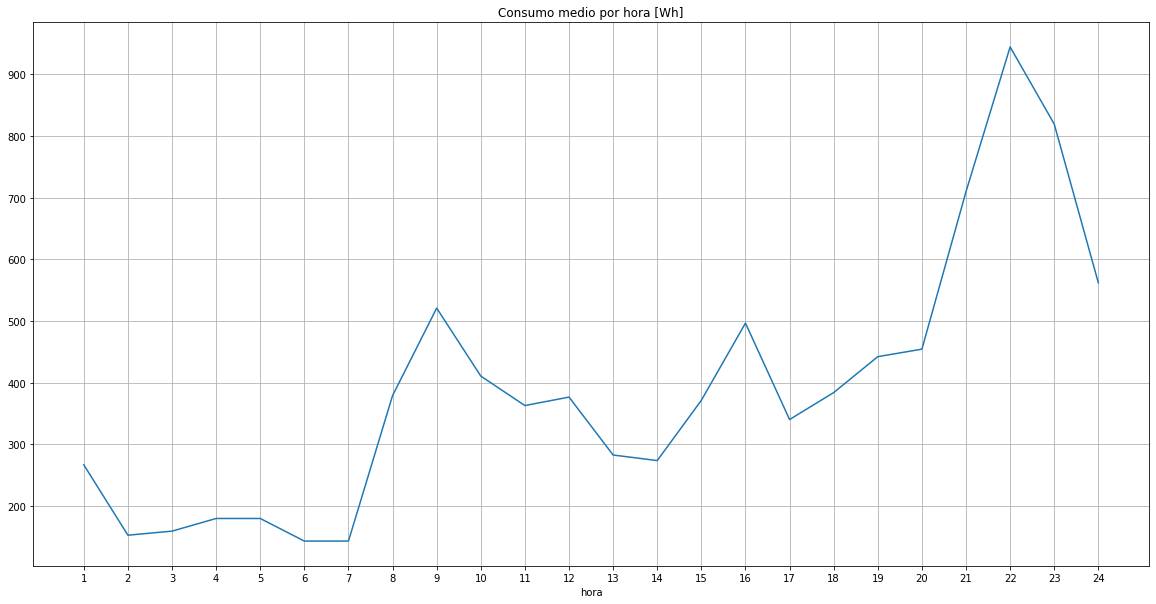

In [8]:
consumo_medio_hora.plot( 
    title='Consumo medio por hora [Wh]', 
    grid=True, kind="line", figsize=(20,10),
    xticks=[x for x in range(1, 25)])
#plt.plot(consumo_medio_hora.index, consumo_medio_hora.values)

## Cálculo de la producción de la instalación

Usamos la librería `pvlib` para relizar los cálculos. Se conecta con el sitio [web europeo de fotovoltáica](https://re.jrc.ec.europa.eu/pvg_tools/en/) (European Comission's JRC PHOTOVOLTAIC GEOGRAPHICAL INFORMATION SYSTEM) para obtener los datos. Ver también el proyecto [Solar Power](https://power.larc.nasa.gov/) de la NASA. El código está tomado del [artículo](https://towardsdatascience.com/solar-panel-power-generation-analysis-7011cc078900) de Leo van der Meulen.

In [9]:
def obtain_panel_power_data(lat, lon, start, end, name, tilt, azimuth, panels, peakpower):
    """
    Determine the solarradiation and generated power for a given solar panel configuration.
    For each hour between startdate and enddate the data is retrieved and calculated.
    :param lat: Latitude of the location
    :param lon: Longitude of the location
    :param start: Startdate for data retrievel
    :param end: Endddate for data retrievel
    :param name: Name of the panel location on the object
    :param tilt: Tilt of the solar panels (0 is flat, 90 is standing straight)
    :param azimuth: Direction the panels, 0 is South, negative from south to east, positive from south to west
    :param panels: Number of panels on the location
    :param peakpower: Peakpower per panel
    :return: dataframe 
    """
    if panels > 0:
        poa, _, _ = pvlib.iotools.get_pvgis_hourly(
            latitude=lat, longitude=lon, start=start, end=end,
            surface_tilt=tilt, surface_azimuth=-azimuth,
            pvcalculation=True, peakpower=peakpower*panels,
            components=True, raddatabase='PVGIS-SARAH2', url='https://re.jrc.ec.europa.eu/api/v5_2/',
            )
    else:
        poa, _, _ = pvlib.iotools.get_pvgis_hourly(
            latitude=lat, longitude=lon, start=start, end=end,
            surface_tilt=tilt, surface_azimuth=-azimuth,
            pvcalculation=False,
            components=True, raddatabase='PVGIS-SARAH2', url='https://re.jrc.ec.europa.eu/api/v5_2/',
            )
        poa['P'] = 0.0
    poa['date'] = pd.to_datetime(poa.index.date)
    poa['location'] = name
    poa['P'] = poa['P'].div(1000)    # change unit to kWh
    return poa

In [10]:
# calculamos la generación.
data_panel_power=obtain_panel_power_data(lat, lon, start, end, name, tilt, azimut, panels, peakpower)

In [11]:
#for col in data_panel_power.columns:
#  print(col)

print(f'Datos cargados: {data_panel_power.shape[0]} filas, {data_panel_power.shape[1]} columnas')
# data_panel_power.head(10)

# extraemos la hora y le sumamos 1 para hacerla compatible con el dataset de la compañía, además de pasarlo a CET
# atención!!, sólo válido para España
data_panel_power['hora']=data_panel_power.index.hour+1

# seleccionamos las columnas de interés
pot_generada=data_panel_power[["date","hora", "P"]]

# seleccionamos el periodo
pot_generada_periodo=pot_generada[pot_generada['date']>=str_start]
pot_generada_periodo=pot_generada_periodo[pot_generada_periodo['date']<=str_fins]

#print(f'\nProducción media por hora [kWh] desde {str_start} hasta {str_fins}')
produccion_media_hora=pot_generada_periodo.groupby(["hora"])['P'].mean()*1000

#produccion_media_hora['produccion']=list(consumo_medio_hora.values)


#lista_datos=[pd.Series(produccion_media_hora.values, index=cols), pd.Series(consumo_medio_hora.values, index=cols)]
comparativa=pd.DataFrame(columns=['produccion', 'consumo'])#, 'diferencia'])

comparativa.produccion=produccion_media_hora.values
comparativa.consumo=consumo_medio_hora.values
#comparativa.diferencia=produccion_media_hora.values-consumo_medio_hora.values

#print(comparativa.head(28))



Datos cargados: 8784 filas, 10 columnas


## Gráfica de producción y consumo

Consumo medio/dia: 9.332 kWh


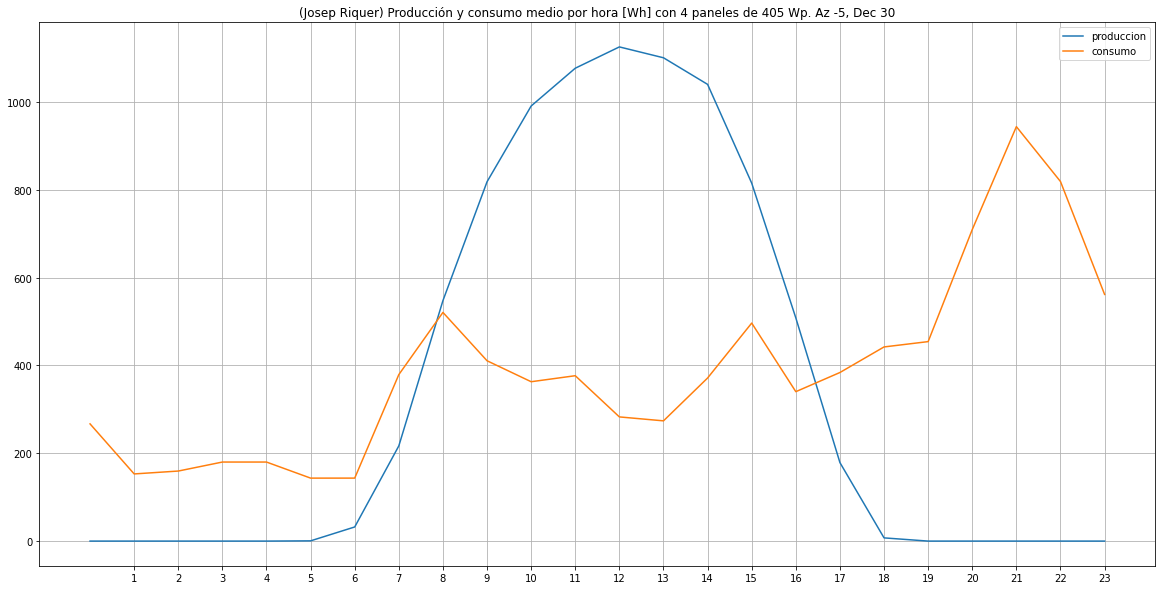

In [12]:
comparativa.plot(
    title=f'({name}) Producción y consumo medio por hora [Wh] con {panels} paneles de {peakpower*1000:.0f} Wp. Az {azimut}, Dec {tilt}', 
    grid=True, kind="line", figsize=(20,10),
    xticks=[x for x in range(1, 24)]
)

print(f'Consumo medio/dia: {(total_consumo/1000)/dias:.3f} kWh')

## Recursos


PVGIS Photovoltaic Geographical Information System

> European Commission. [PVGIS](https://joint-research-centre.ec.europa.eu/pvgis-photovoltaic-geographical-information-system_en)


Librería pvlib
> William F. Holmgren, Clifford W. Hansen, and Mark A. Mikofski. “pvlib python: a python package for modeling solar energy systems.” Journal of Open Source Software, 3(29), 884, (2018). https://doi.org/10.21105/joss.00884

The power project

> NASA. [https://power.larc.nasa.gov/](https://power.larc.nasa.gov/)

Solar panel power generation analysis

> Leo van der Meulen. "How much energy will you be able to generate with your solar panels? Make your own calculations to stay in control" Medium. [https://towardsdatascience.com/solar-panel-power-generation-analysis-7011cc078900](https://towardsdatascience.com/solar-panel-power-generation-analysis-7011cc078900)

Shadow Calculator

> KameoCode. "Sun position calculator on google maps.
Predict size of shadows at different times of the day for google maps location." [http://shadowcalculator.eu/](http://shadowcalculator.eu/)